## Import your stuff

In [11]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
#import pydelfi.delfi as delfi
import pydelfi.delfi_edit as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [12]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [13]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [14]:
import simulators.mass_function_n_counts.simulator_trapz_3params as n_counts_simulator
#importlib.reload(n_counts_simulator)

In [15]:
importlib.reload(delfi)

<module 'pydelfi.delfi_edit' from '/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi_edit.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [16]:
lower = np.array([0.1125, 0.020, 0.6])
upper = np.array([0.1275, 0.024, 1.1])
prior = priors.Uniform(lower, upper)

In [17]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76])
n_params = len(theta_fiducial)

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [18]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_3params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_3params.py'>

In [19]:
N_countsSimulator = n_counts_simulator.Model()

N_countsSimulator.N_counts

array([1.78485558e+04, 5.76970955e+04, 7.91959673e+04, 7.60280551e+04,
       5.88513395e+04, 2.53149917e+03, 6.50857065e+03, 6.79905624e+03,
       4.77690342e+03, 2.60821304e+03, 1.41326957e+02, 2.40973379e+02,
       1.54407659e+02, 6.19686706e+01, 1.80224732e+01, 1.15792928e+00,
       8.97137339e-01, 2.22002922e-01, 2.95445872e-02, 2.45078214e-03])

In [20]:
log10masses = np.linspace(14, 16, num = 5)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)

In [21]:
N_countsSimulator.n_counts_trapz(theta_fiducial, 0.1, 0.2, 14.0, 14.5)

computing cosmo: 0.00022232899999963252 s
computing halo mass function object: 0.11471929599999964 s
computing factors: 0.11394513599999989 s
loop over z_steps: 0.03472579499999995 s


17848.555764027973

In [22]:
N_countsSimulator.n_counts_trapz_all(theta_fiducial, z_min, z_max, log10masses)

array([1.78485558e+04, 5.76970955e+04, 7.91959673e+04, 7.60280551e+04,
       5.88513395e+04, 2.53149917e+03, 6.50857065e+03, 6.79905624e+03,
       4.77690342e+03, 2.60821304e+03, 1.41326957e+02, 2.40973379e+02,
       1.54407659e+02, 6.19686706e+01, 1.80224732e+01, 1.15792928e+00,
       8.97137339e-01, 2.22002922e-01, 2.95445872e-02, 2.45078214e-03])

In [23]:
N_countsSimulator.N_counts.shape

(20,)

In [24]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

In [25]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [26]:
N_counts_data = np.load('N_counts_random_data.npy')
N_counts_data

array([[17720, 57628, 78955, 75947, 58462],
       [ 2499,  6606,  6684,  4733,  2579],
       [  140,   228,   173,    55,    15],
       [    1,     0,     0,     1,     0]])

## Define ensemble of NDEs

In [27]:
NDEs1 = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=20, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [28]:
DelfiEnsemble = delfi.Delfi(N_counts_data.reshape(20), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_3params_print_statements_500sims/")

## Sequential Neural Likelihood

In [29]:
n_initial = 10 #200
n_batch = 10 #200
n_populations = 50 #20

training_loss: [array([85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819]), array([85.1725769 , 85.1725769 , 85.1725769 , 85.1725769 , 85.1725769 ,
       85.1725769 , 85.1725769 , 85.1725769 , 85.1725769 , 85.1725769 ,
       85.1725769 , 85.1725769 , 85.1725769 , 85.1725769 , 85.1725769 ,
       85.1725769 , 85.1725769 , 85.1725769 , 85.1725769 , 85.1725769 ,
       85.1725769 , 85.18411255, 85.18411255, 85.18411255, 85.18411255,
       85.184

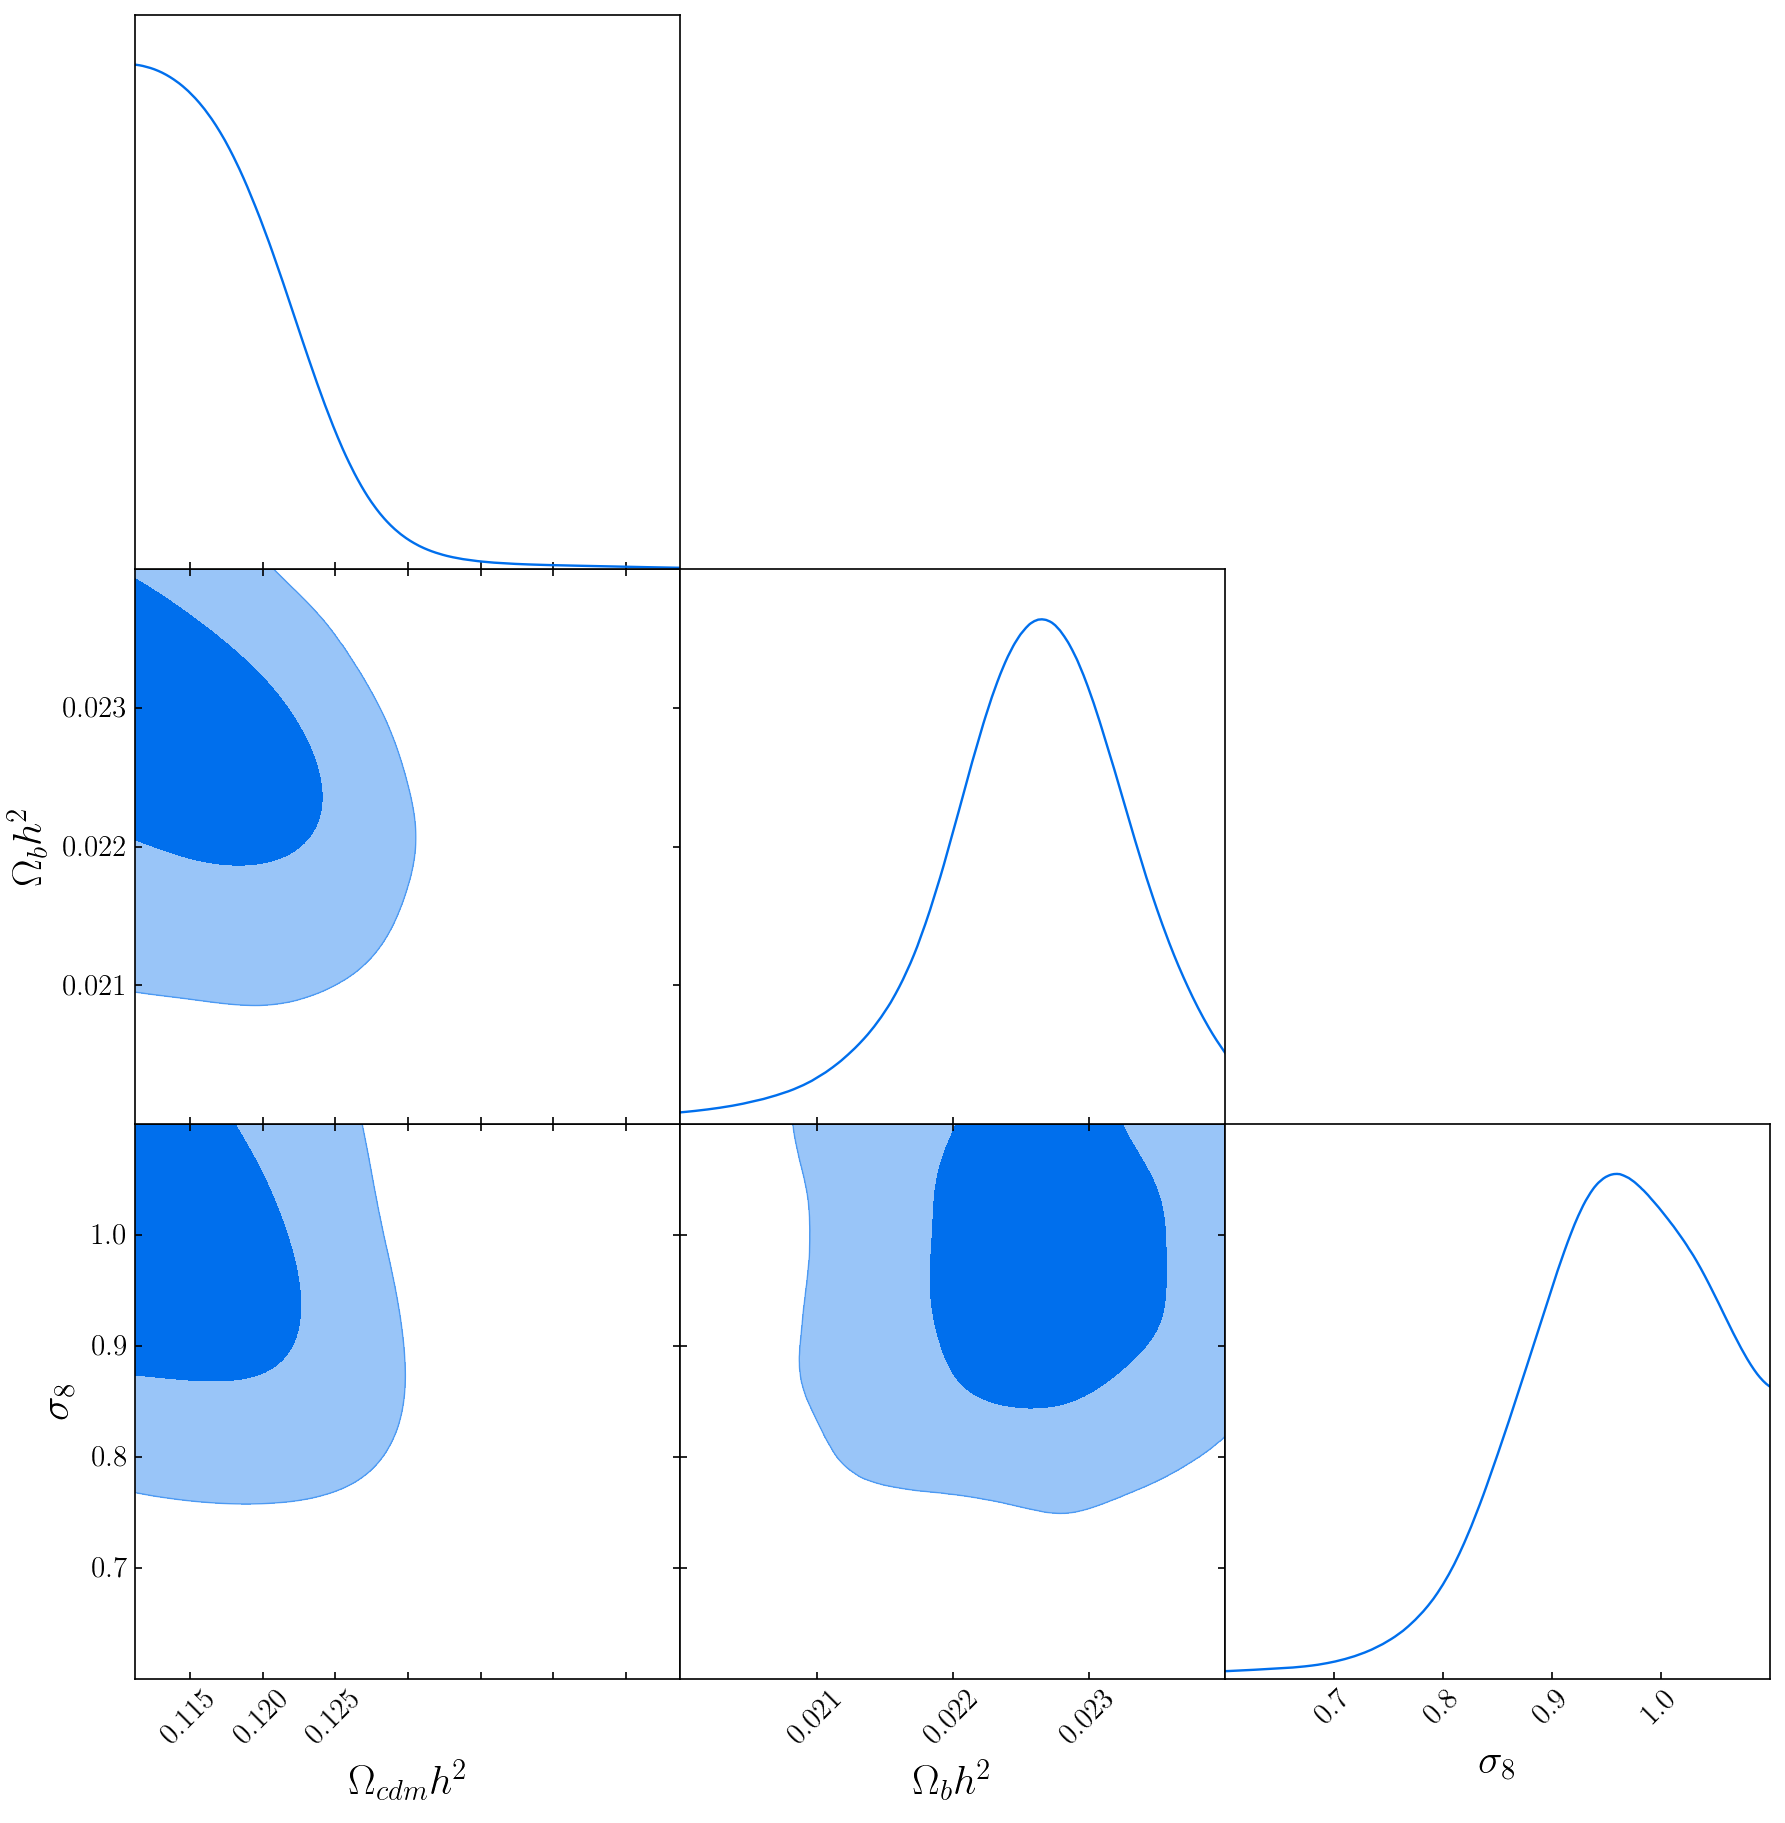

Population 1/50
Sampling proposal density...
Done.


training_loss: [array([85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819]), array([85.1725769 , 85.1725769 , 85.1725769 , 85.1725769 , 85.1725769 ,


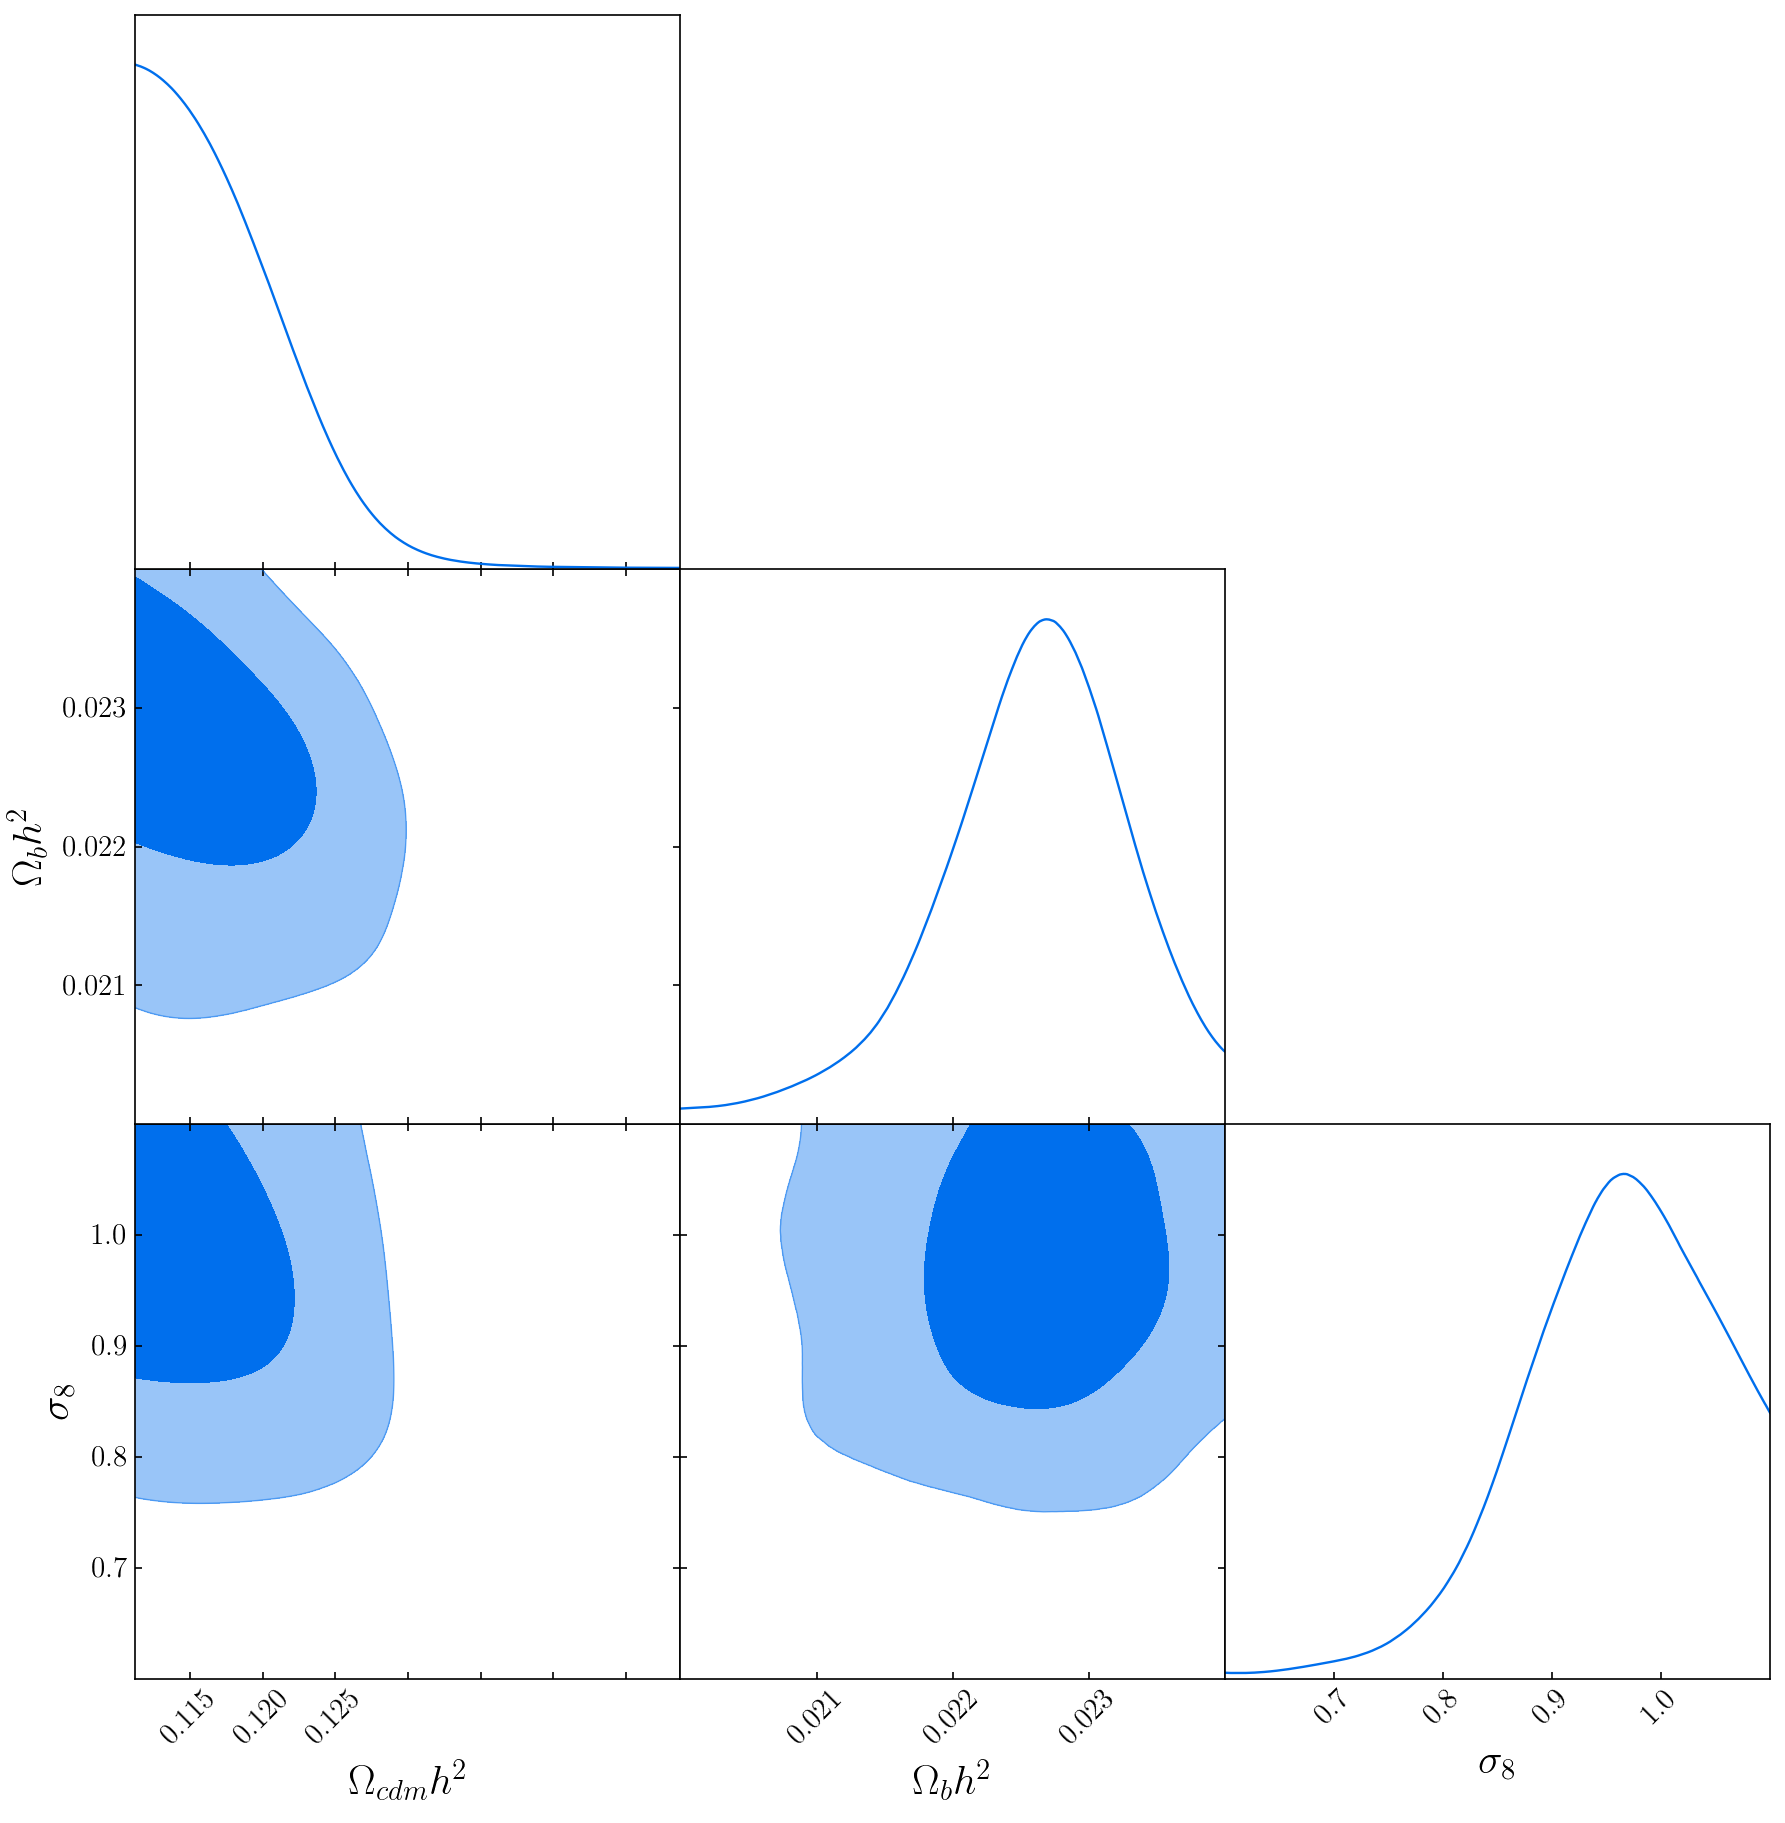

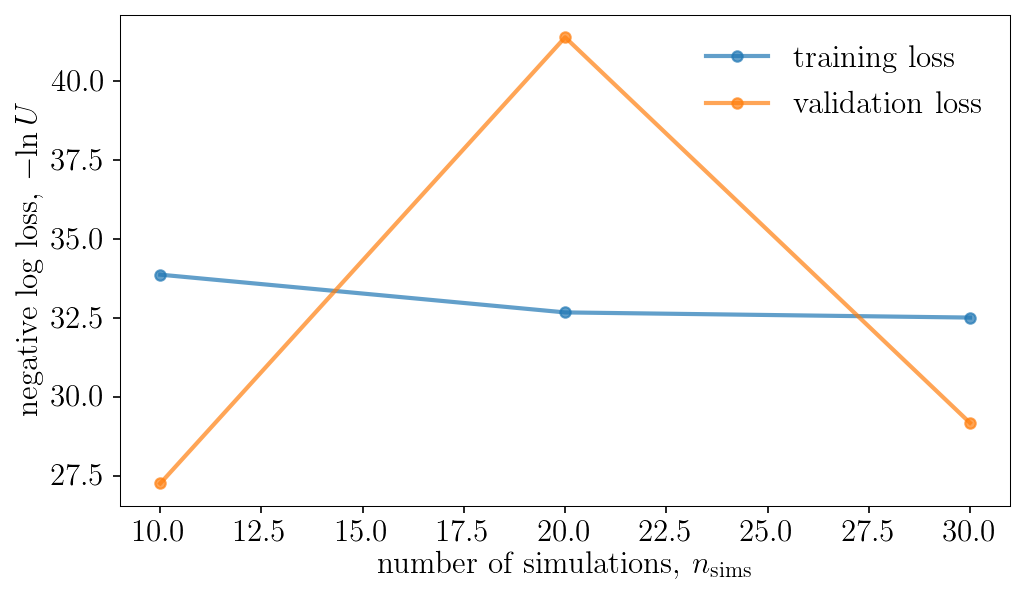

Population 2/50
Sampling proposal density...
Done.


training_loss: [array([85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 84.83361816, 84.83361816,
       84.83361816, 84.83361816, 84.83361816, 84

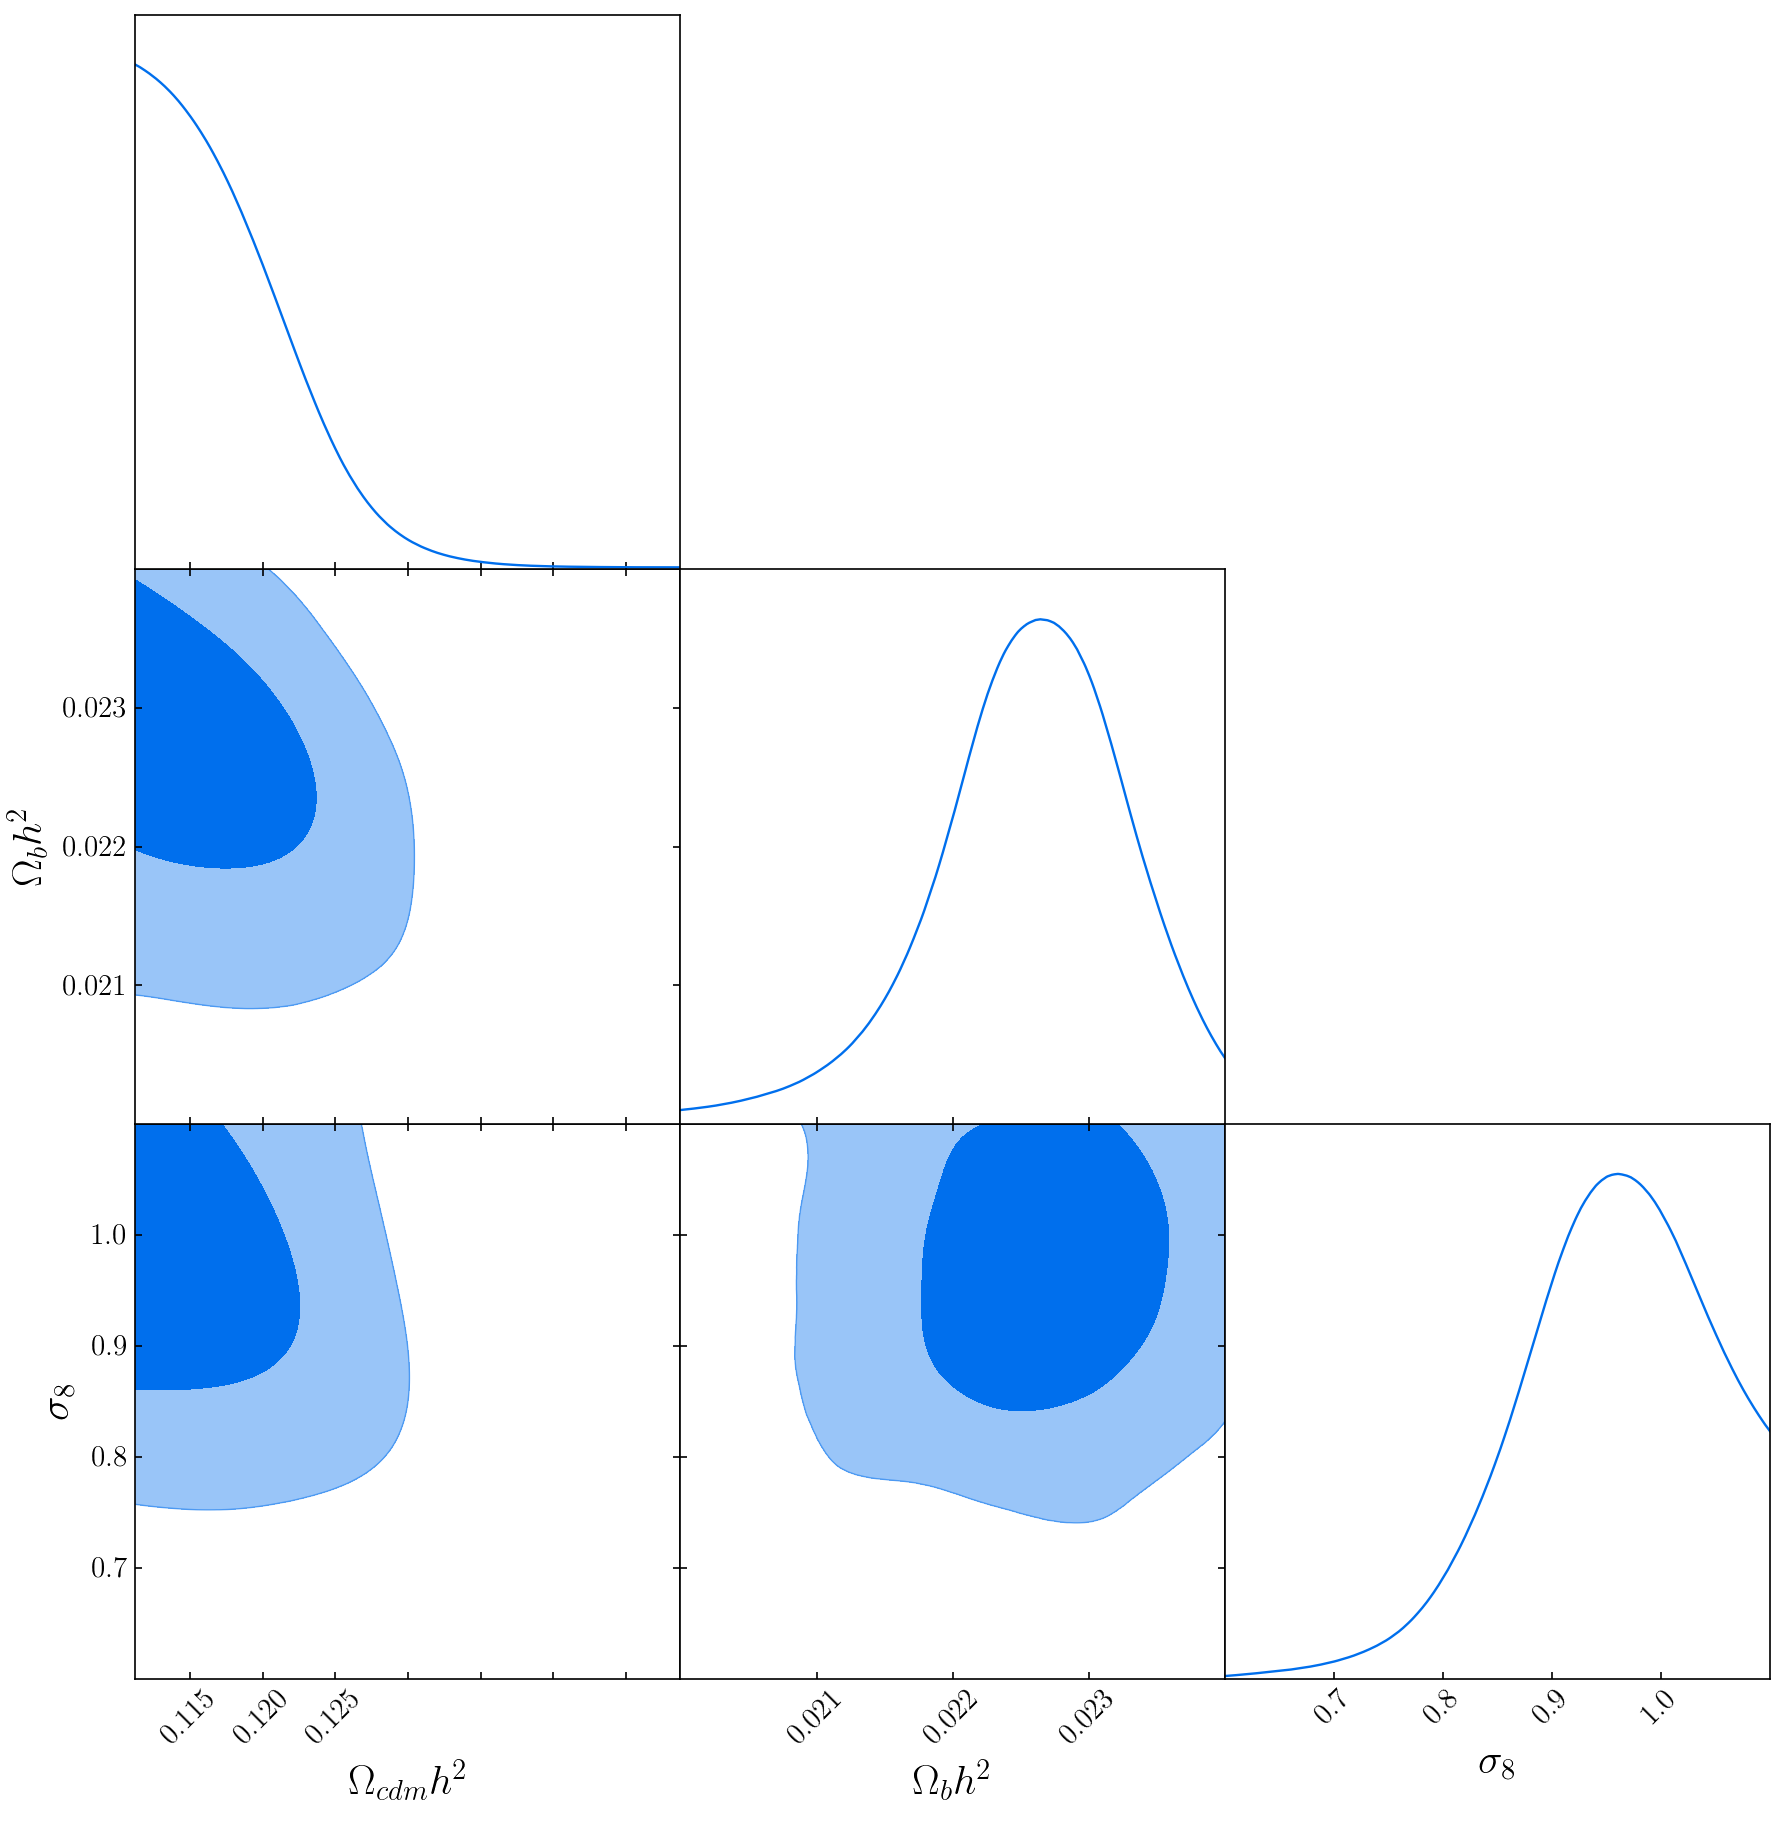

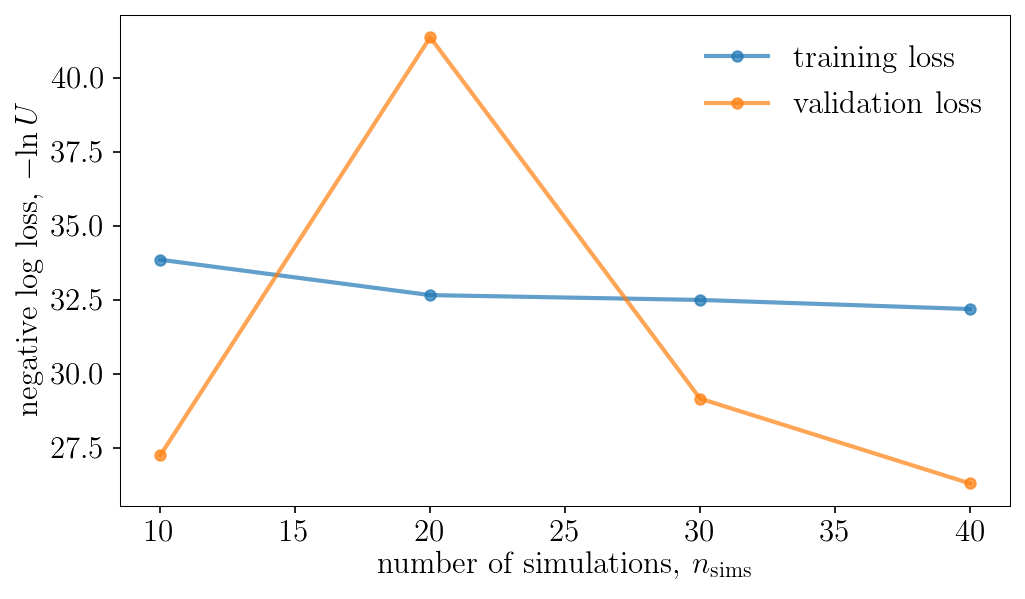

Population 3/50
Sampling proposal density...
Done.


training_loss: [array([85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 84.83361816, 84.83361816,
       84.83361816, 84.83361816, 84.83361816, 84

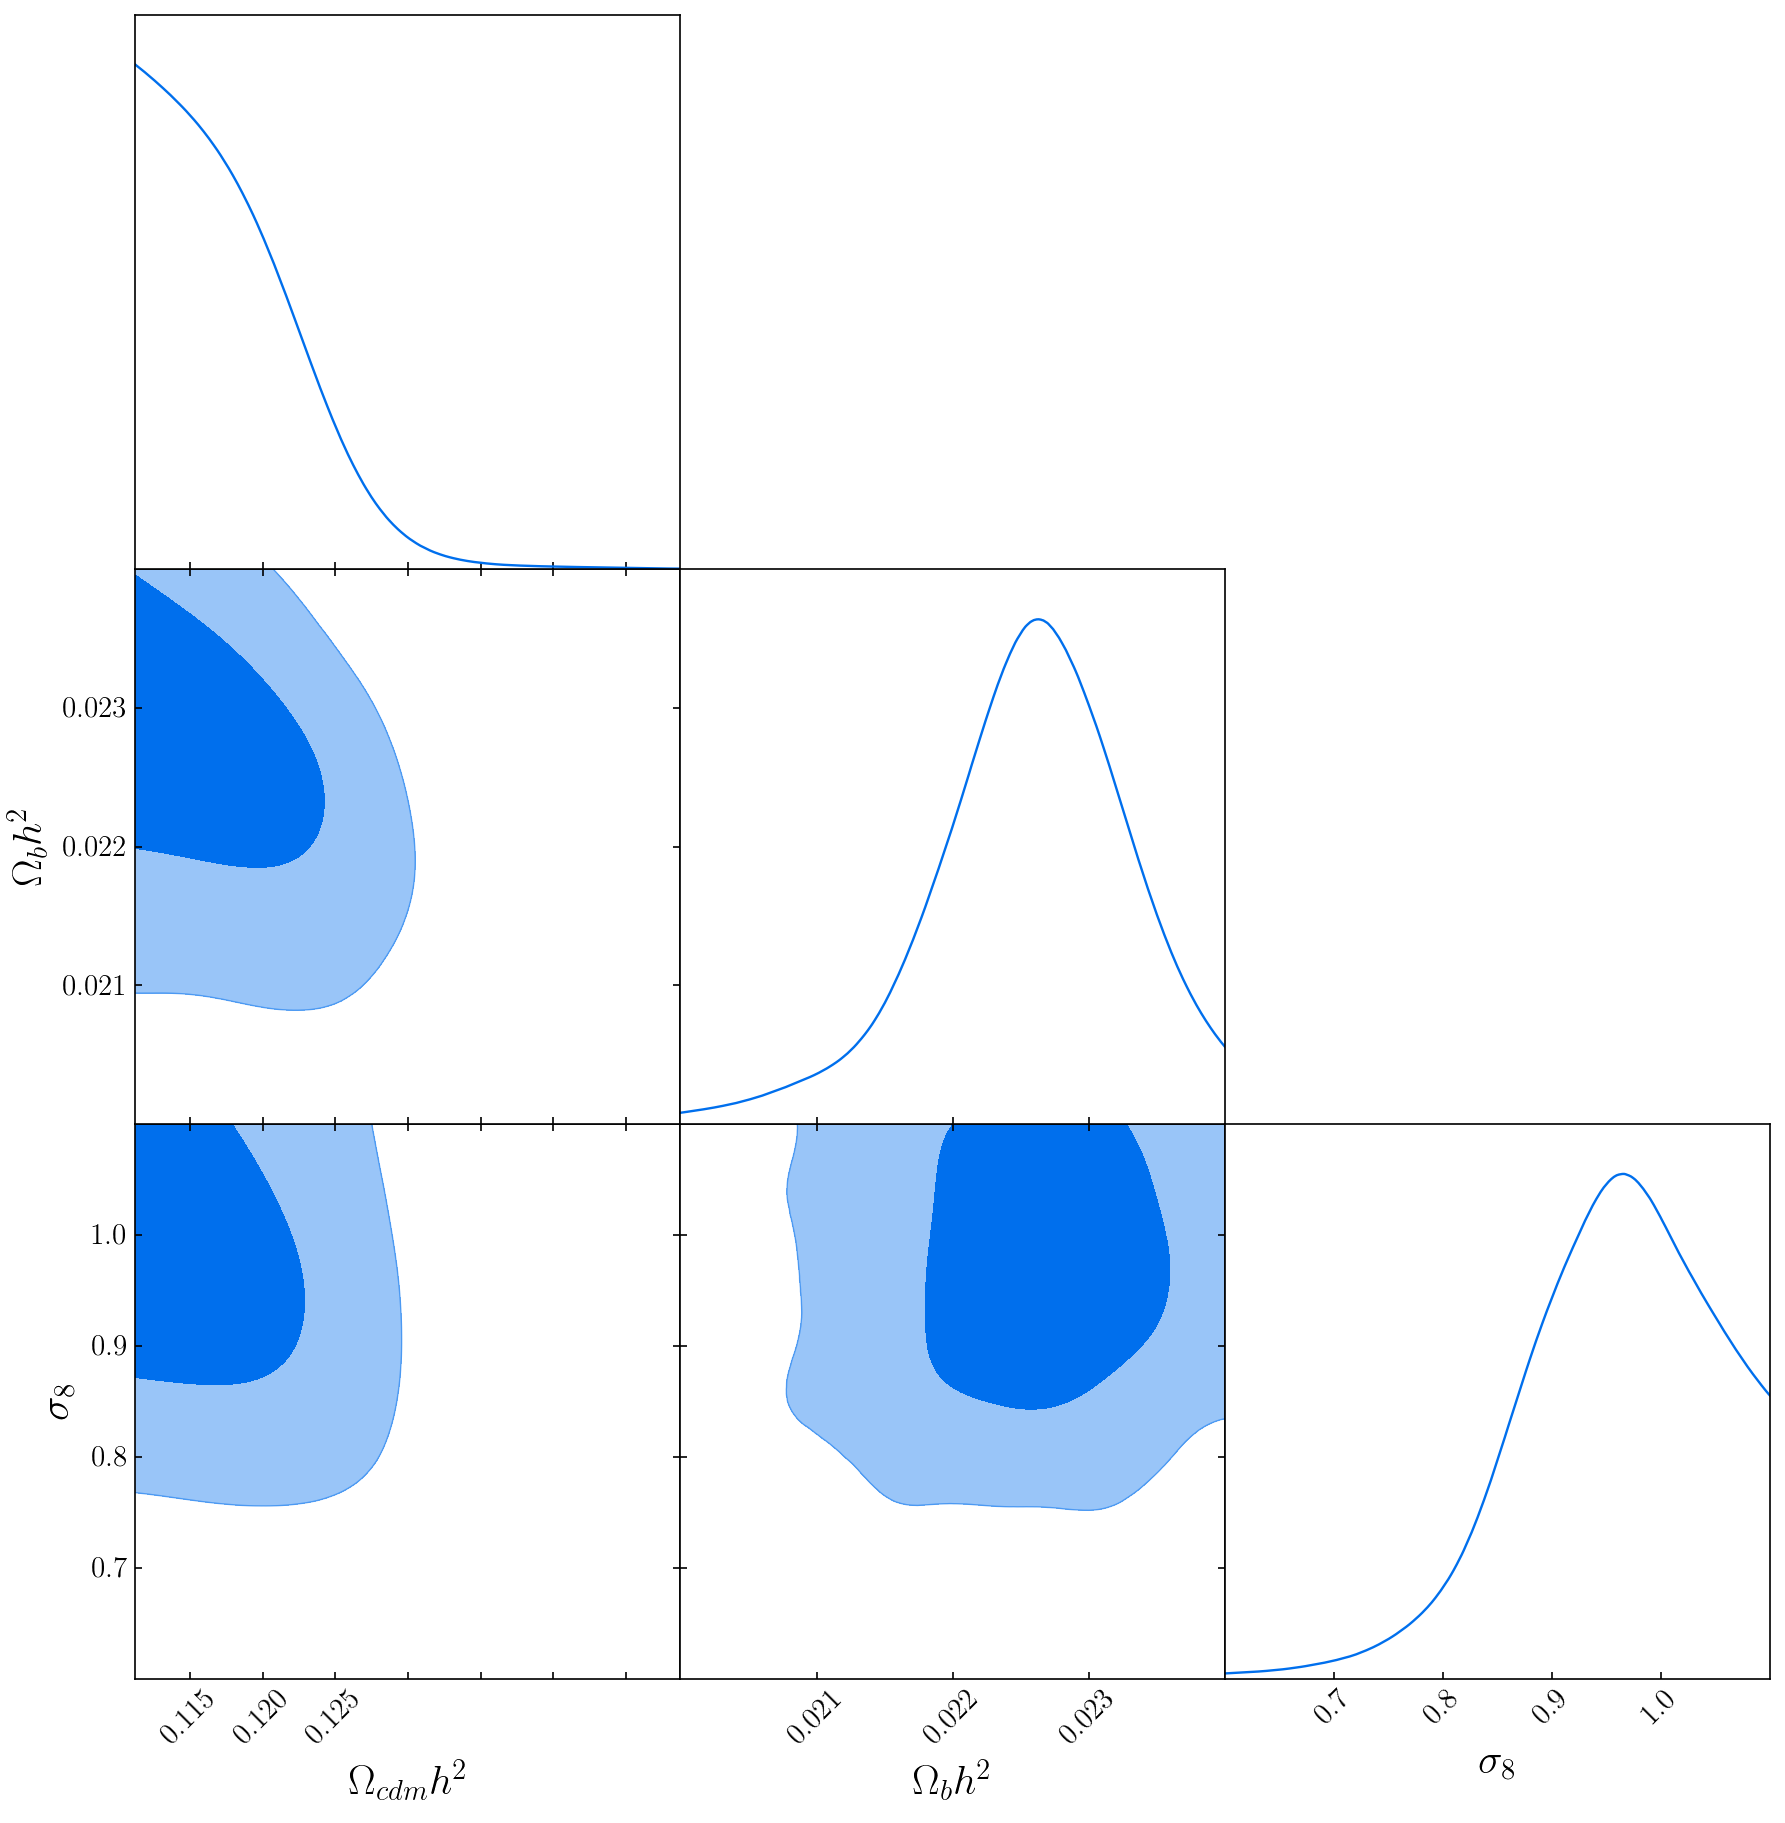

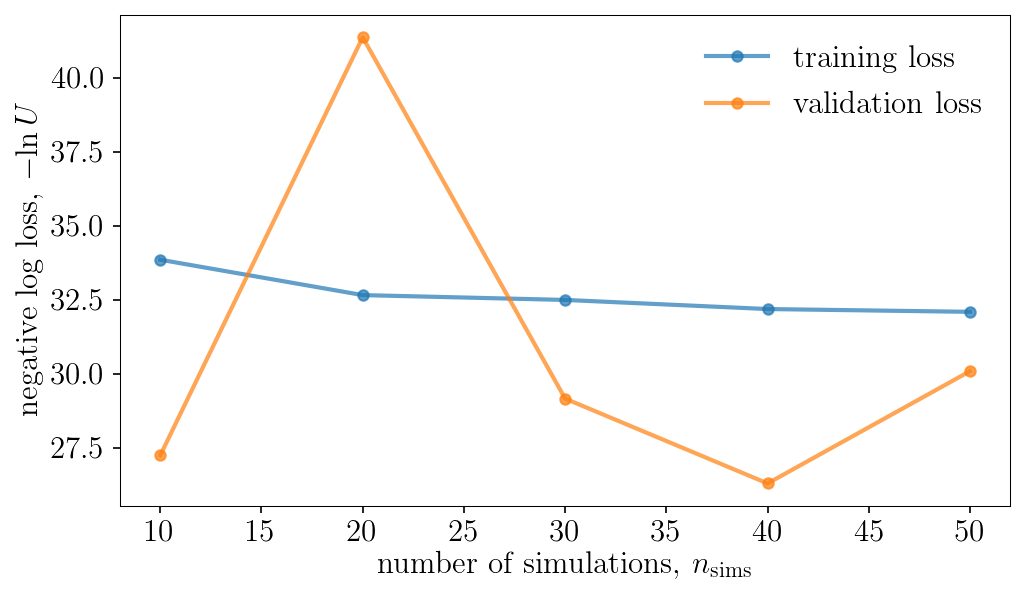

Population 4/50
Sampling proposal density...
Done.


training_loss: [array([85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 84.83361816, 84.83361816,
       84.83361816, 84.83361816, 84.83361816, 84

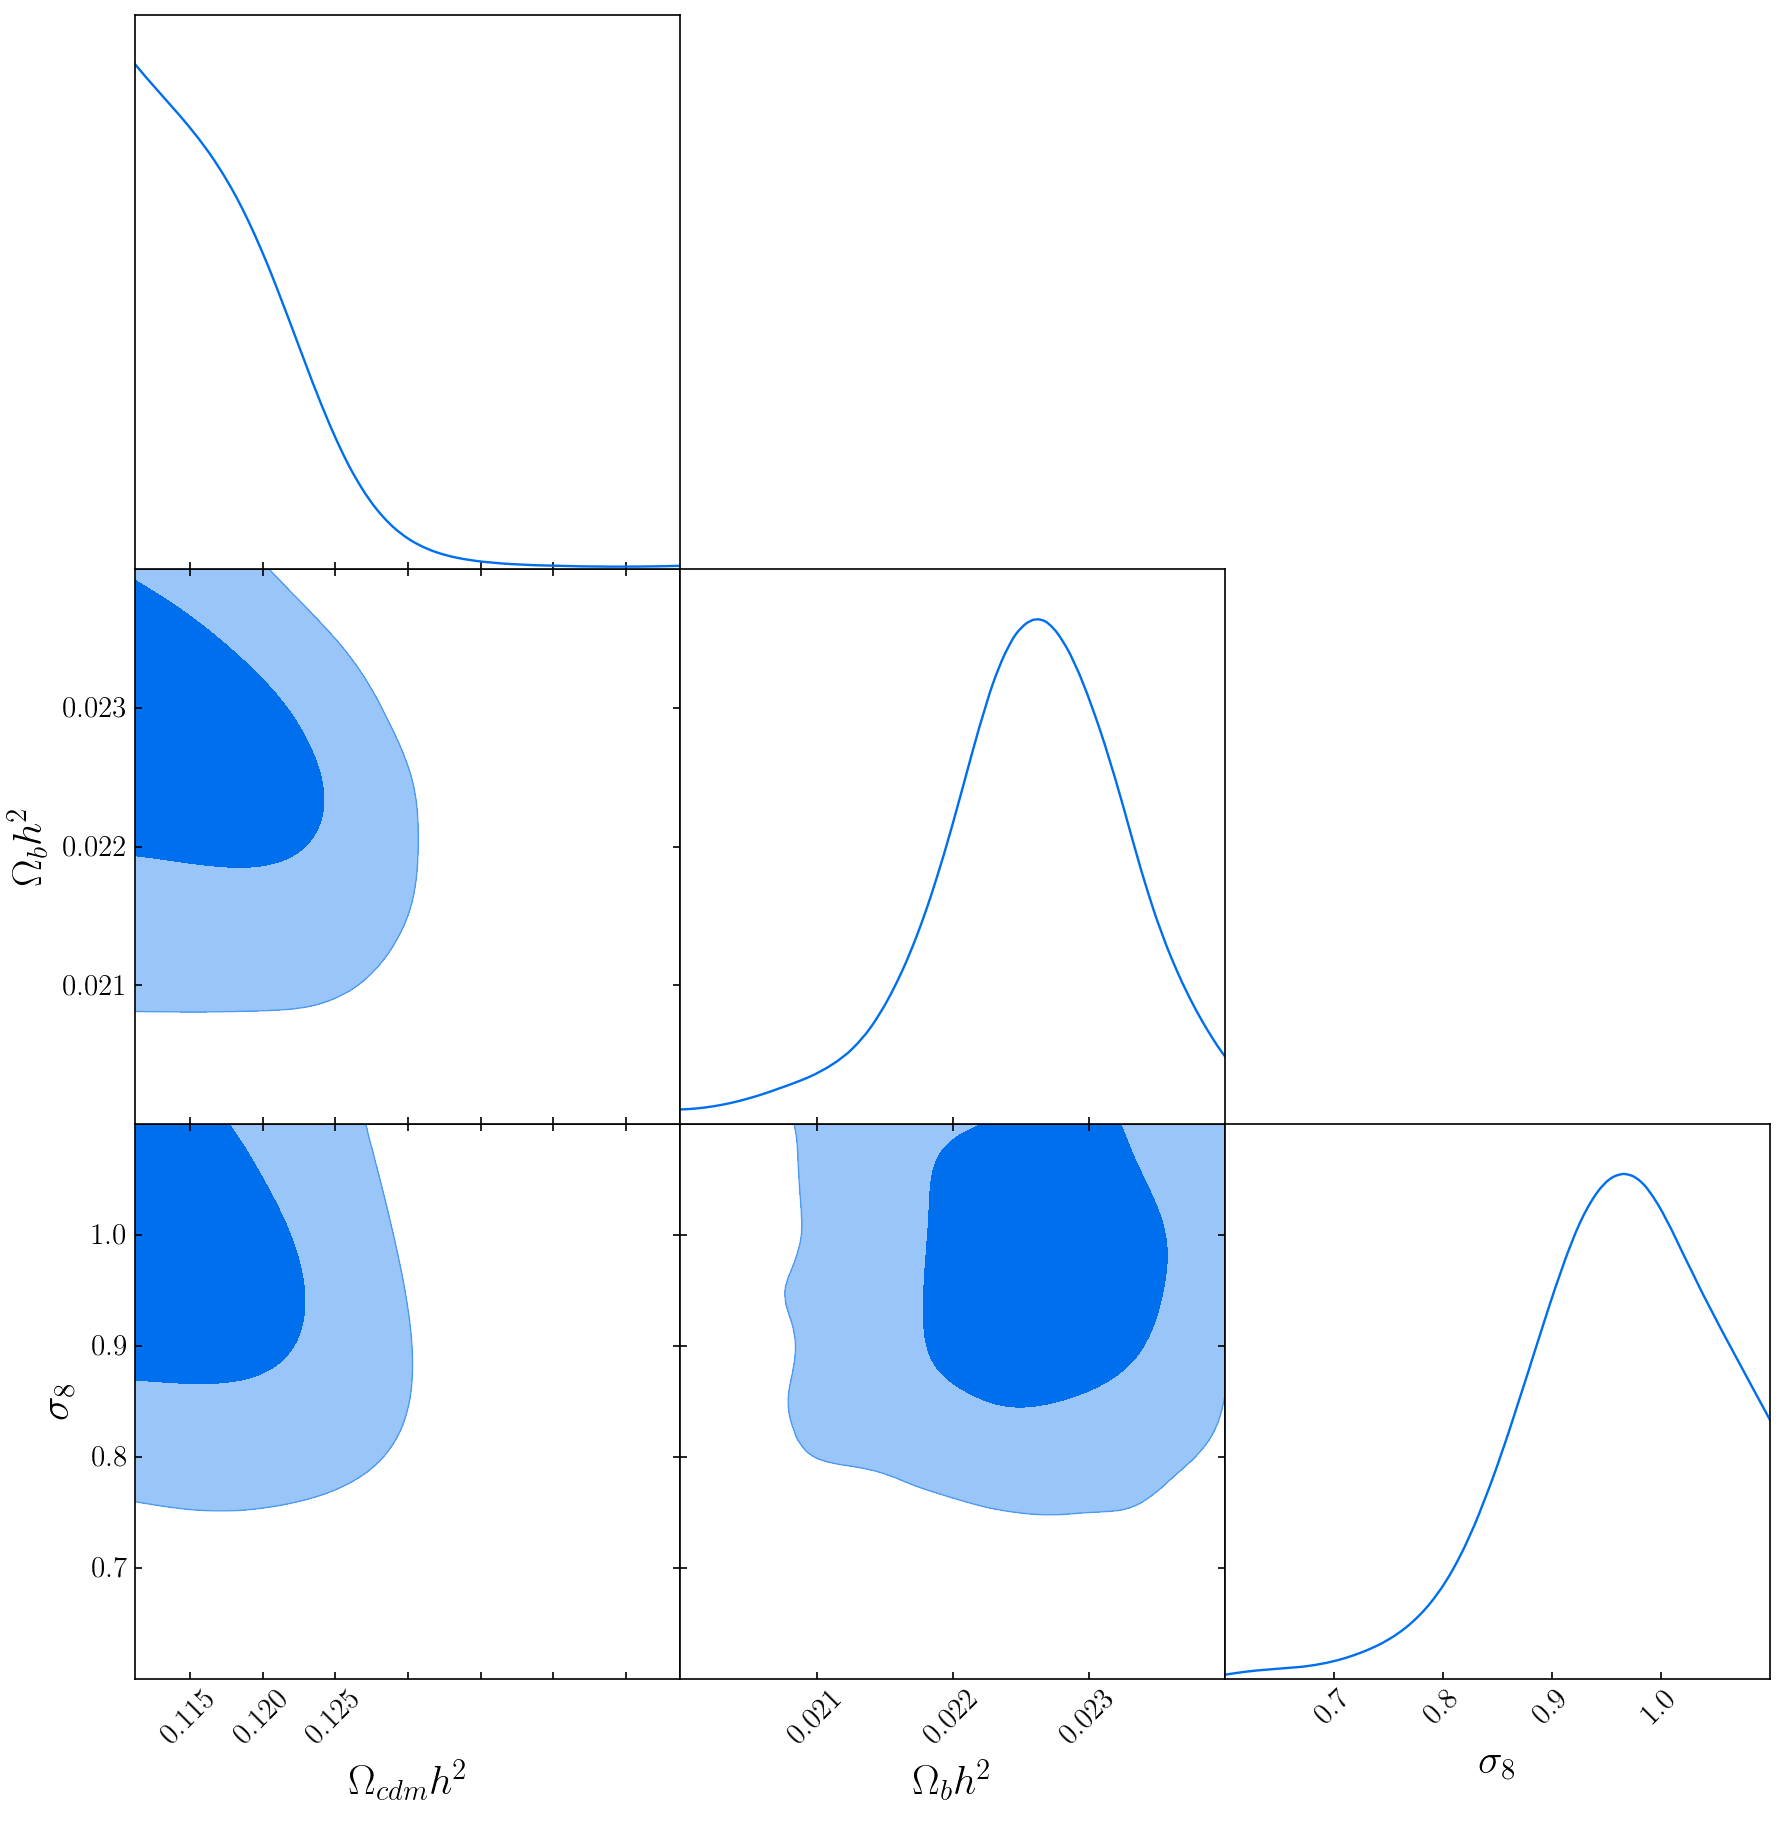

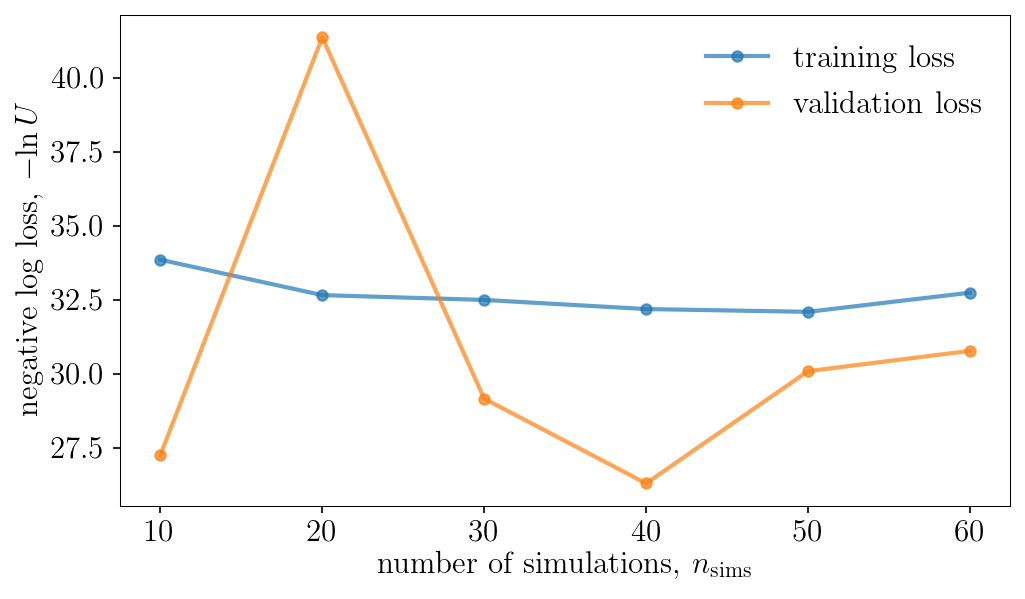

Population 5/50
Sampling proposal density...
Done.


training_loss: [array([85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 84.83361816, 84.83361816,
       84.83361816, 84.83361816, 84.83361816, 84

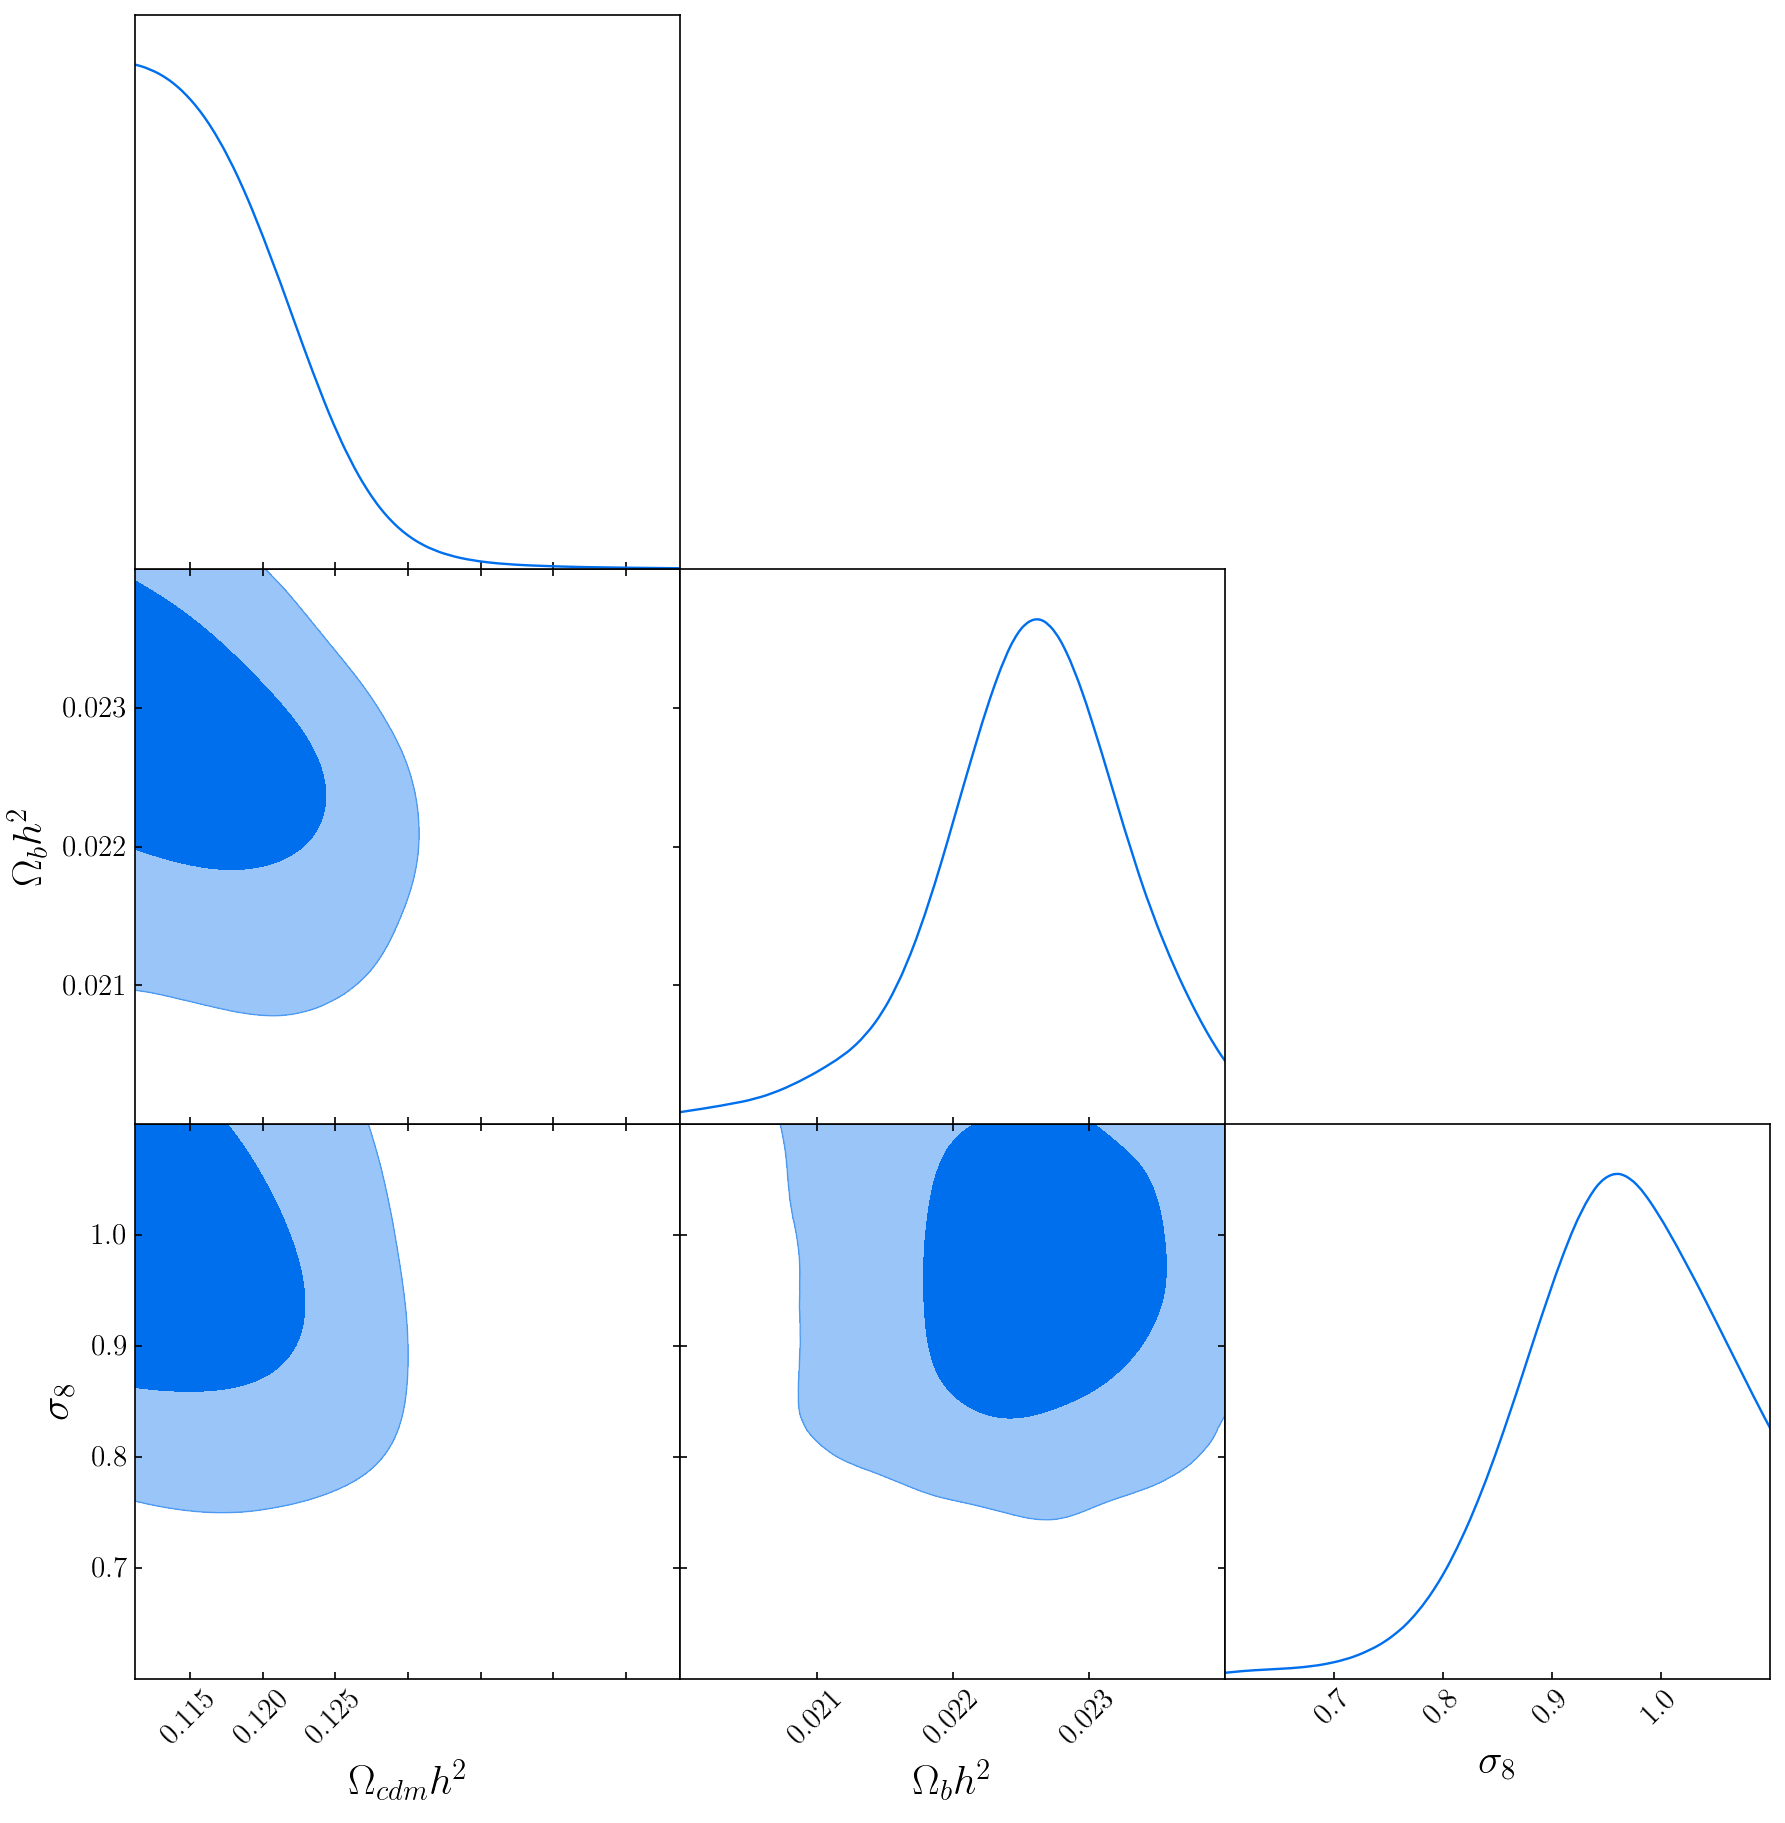

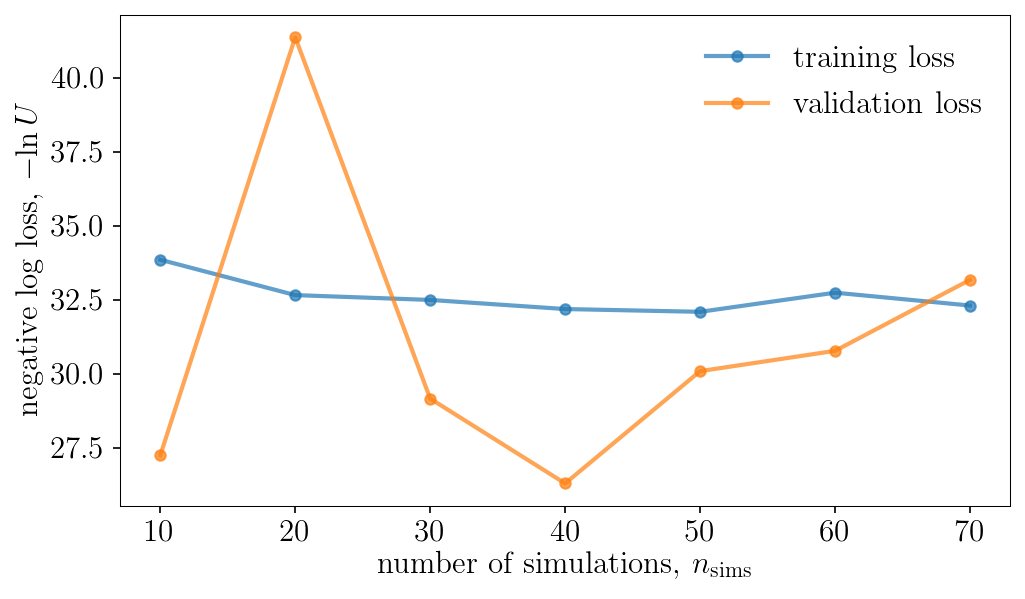

Population 6/50
Sampling proposal density...
Done.


training_loss: [array([85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 84.83361816, 84.83361816,
       84.83361816, 84.83361816, 84.83361816, 84

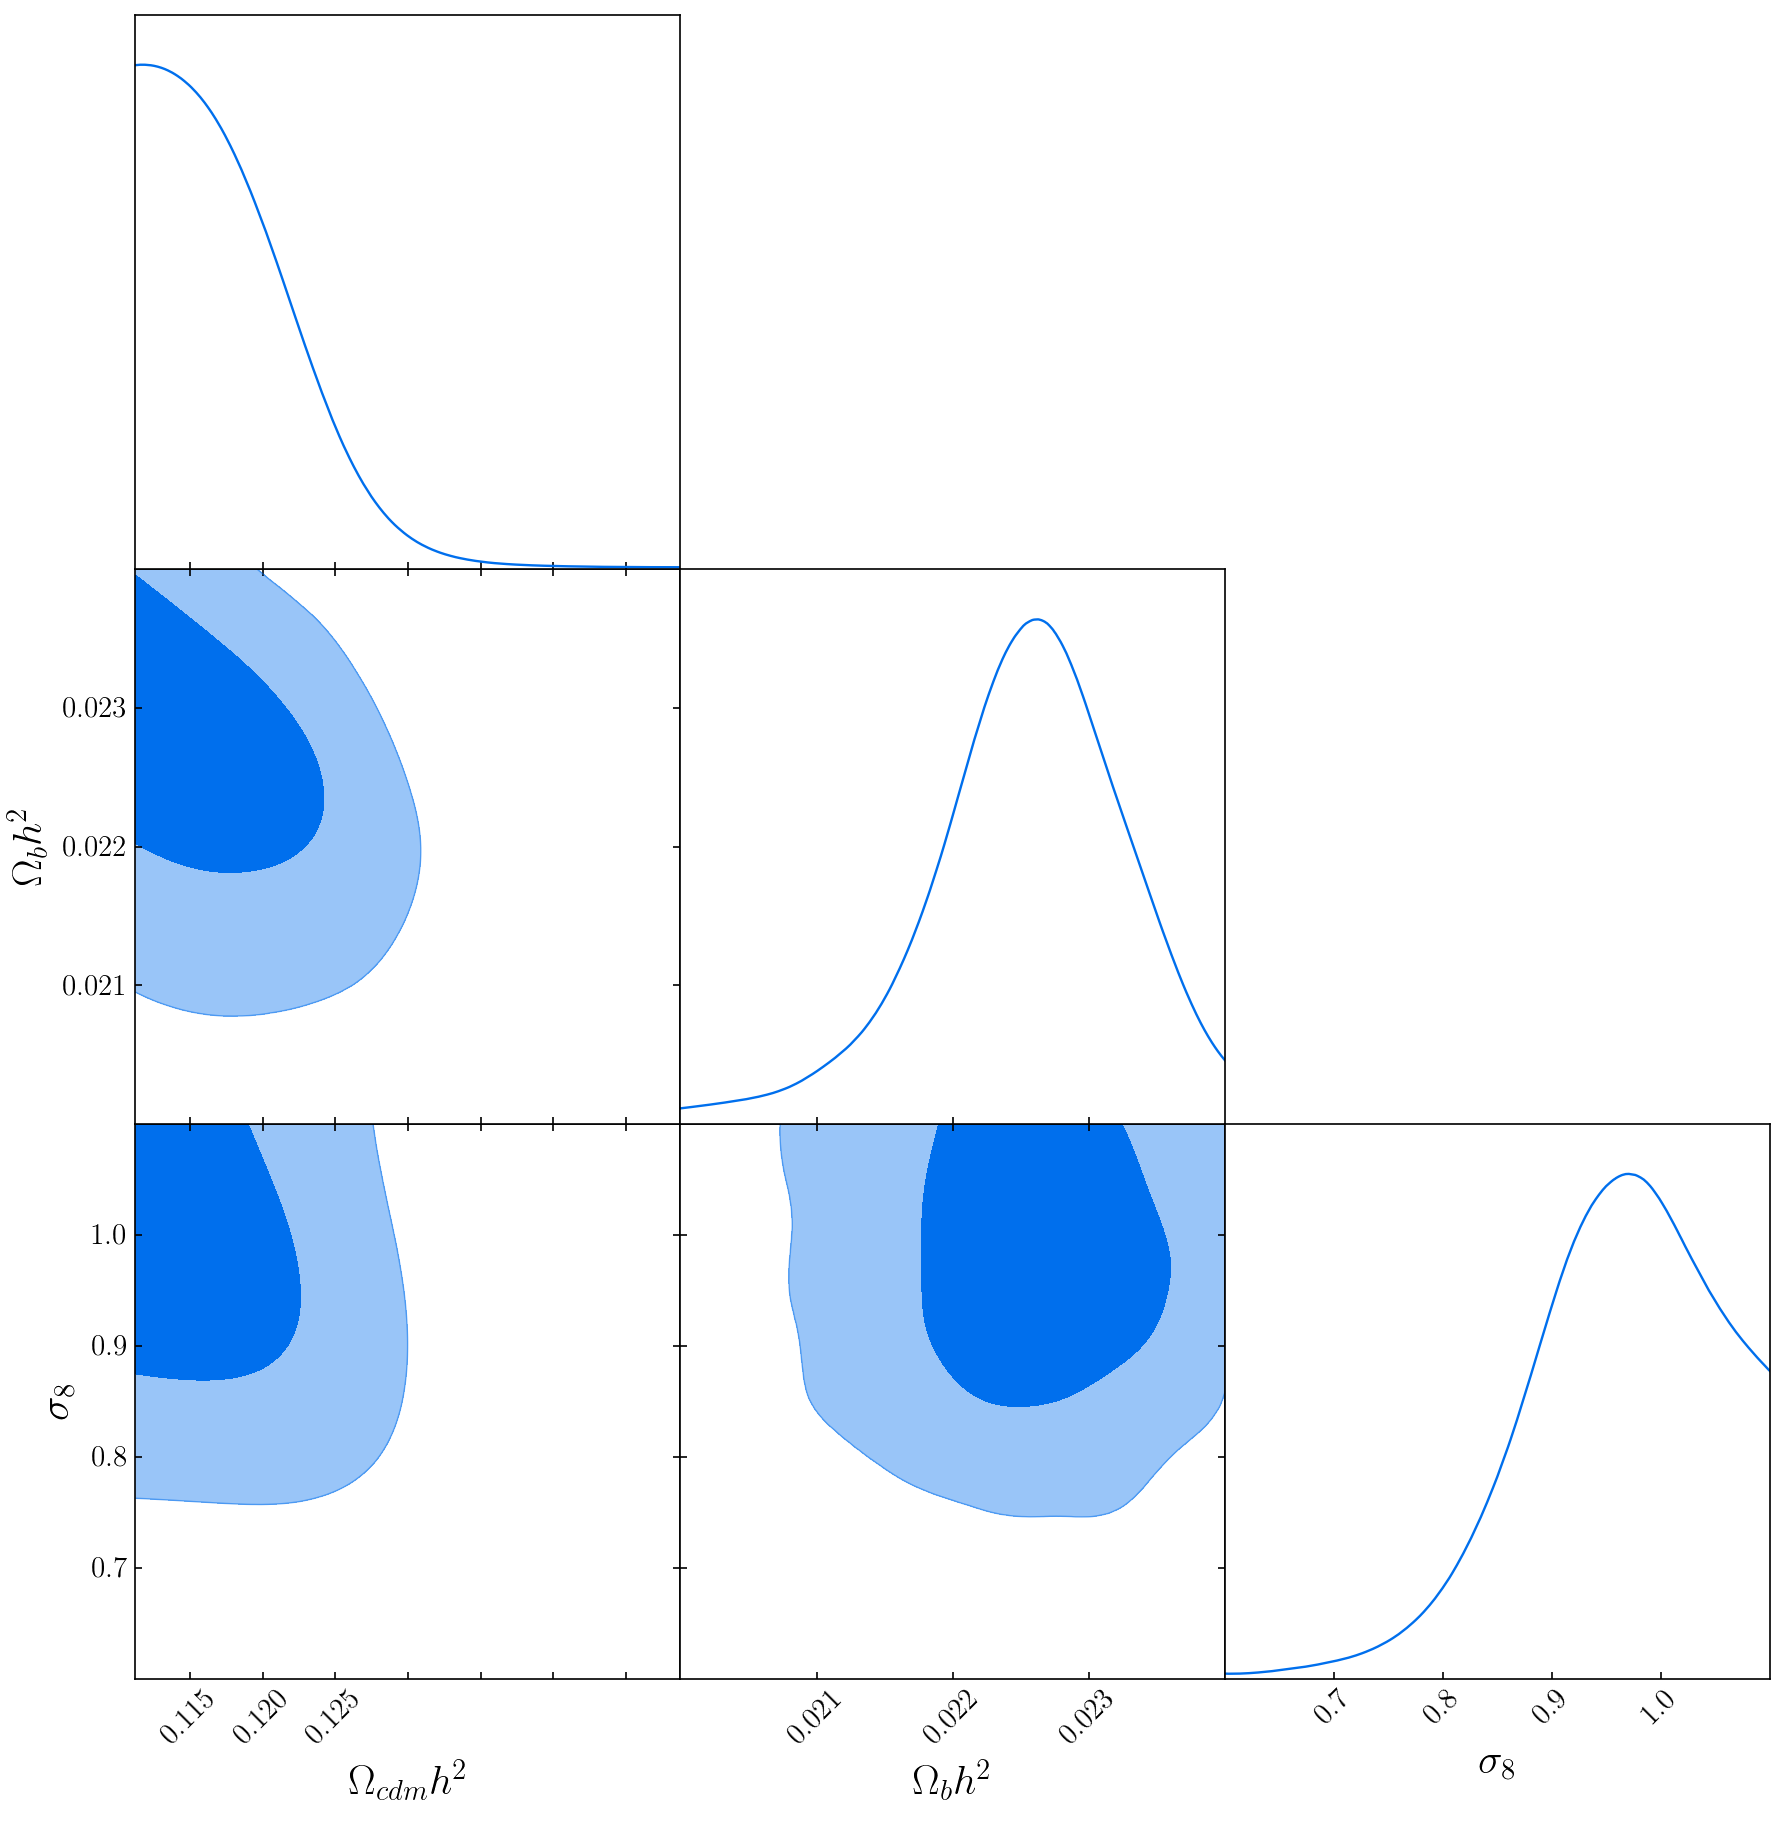

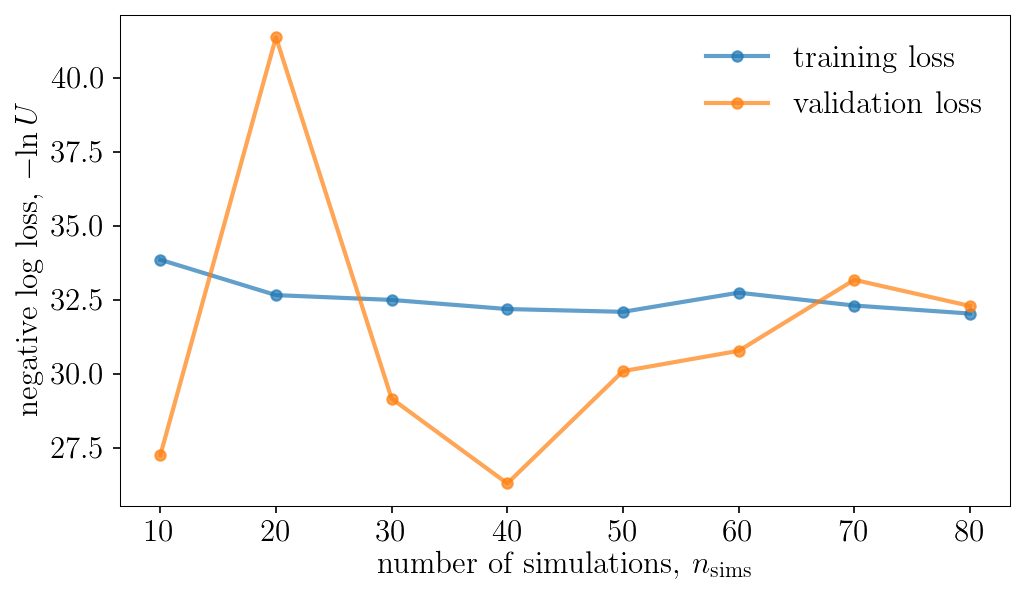

Population 7/50
Sampling proposal density...
Done.


training_loss: [array([85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 84.83361816, 84.83361816,
       84.83361816, 84.83361816, 84.83361816, 84

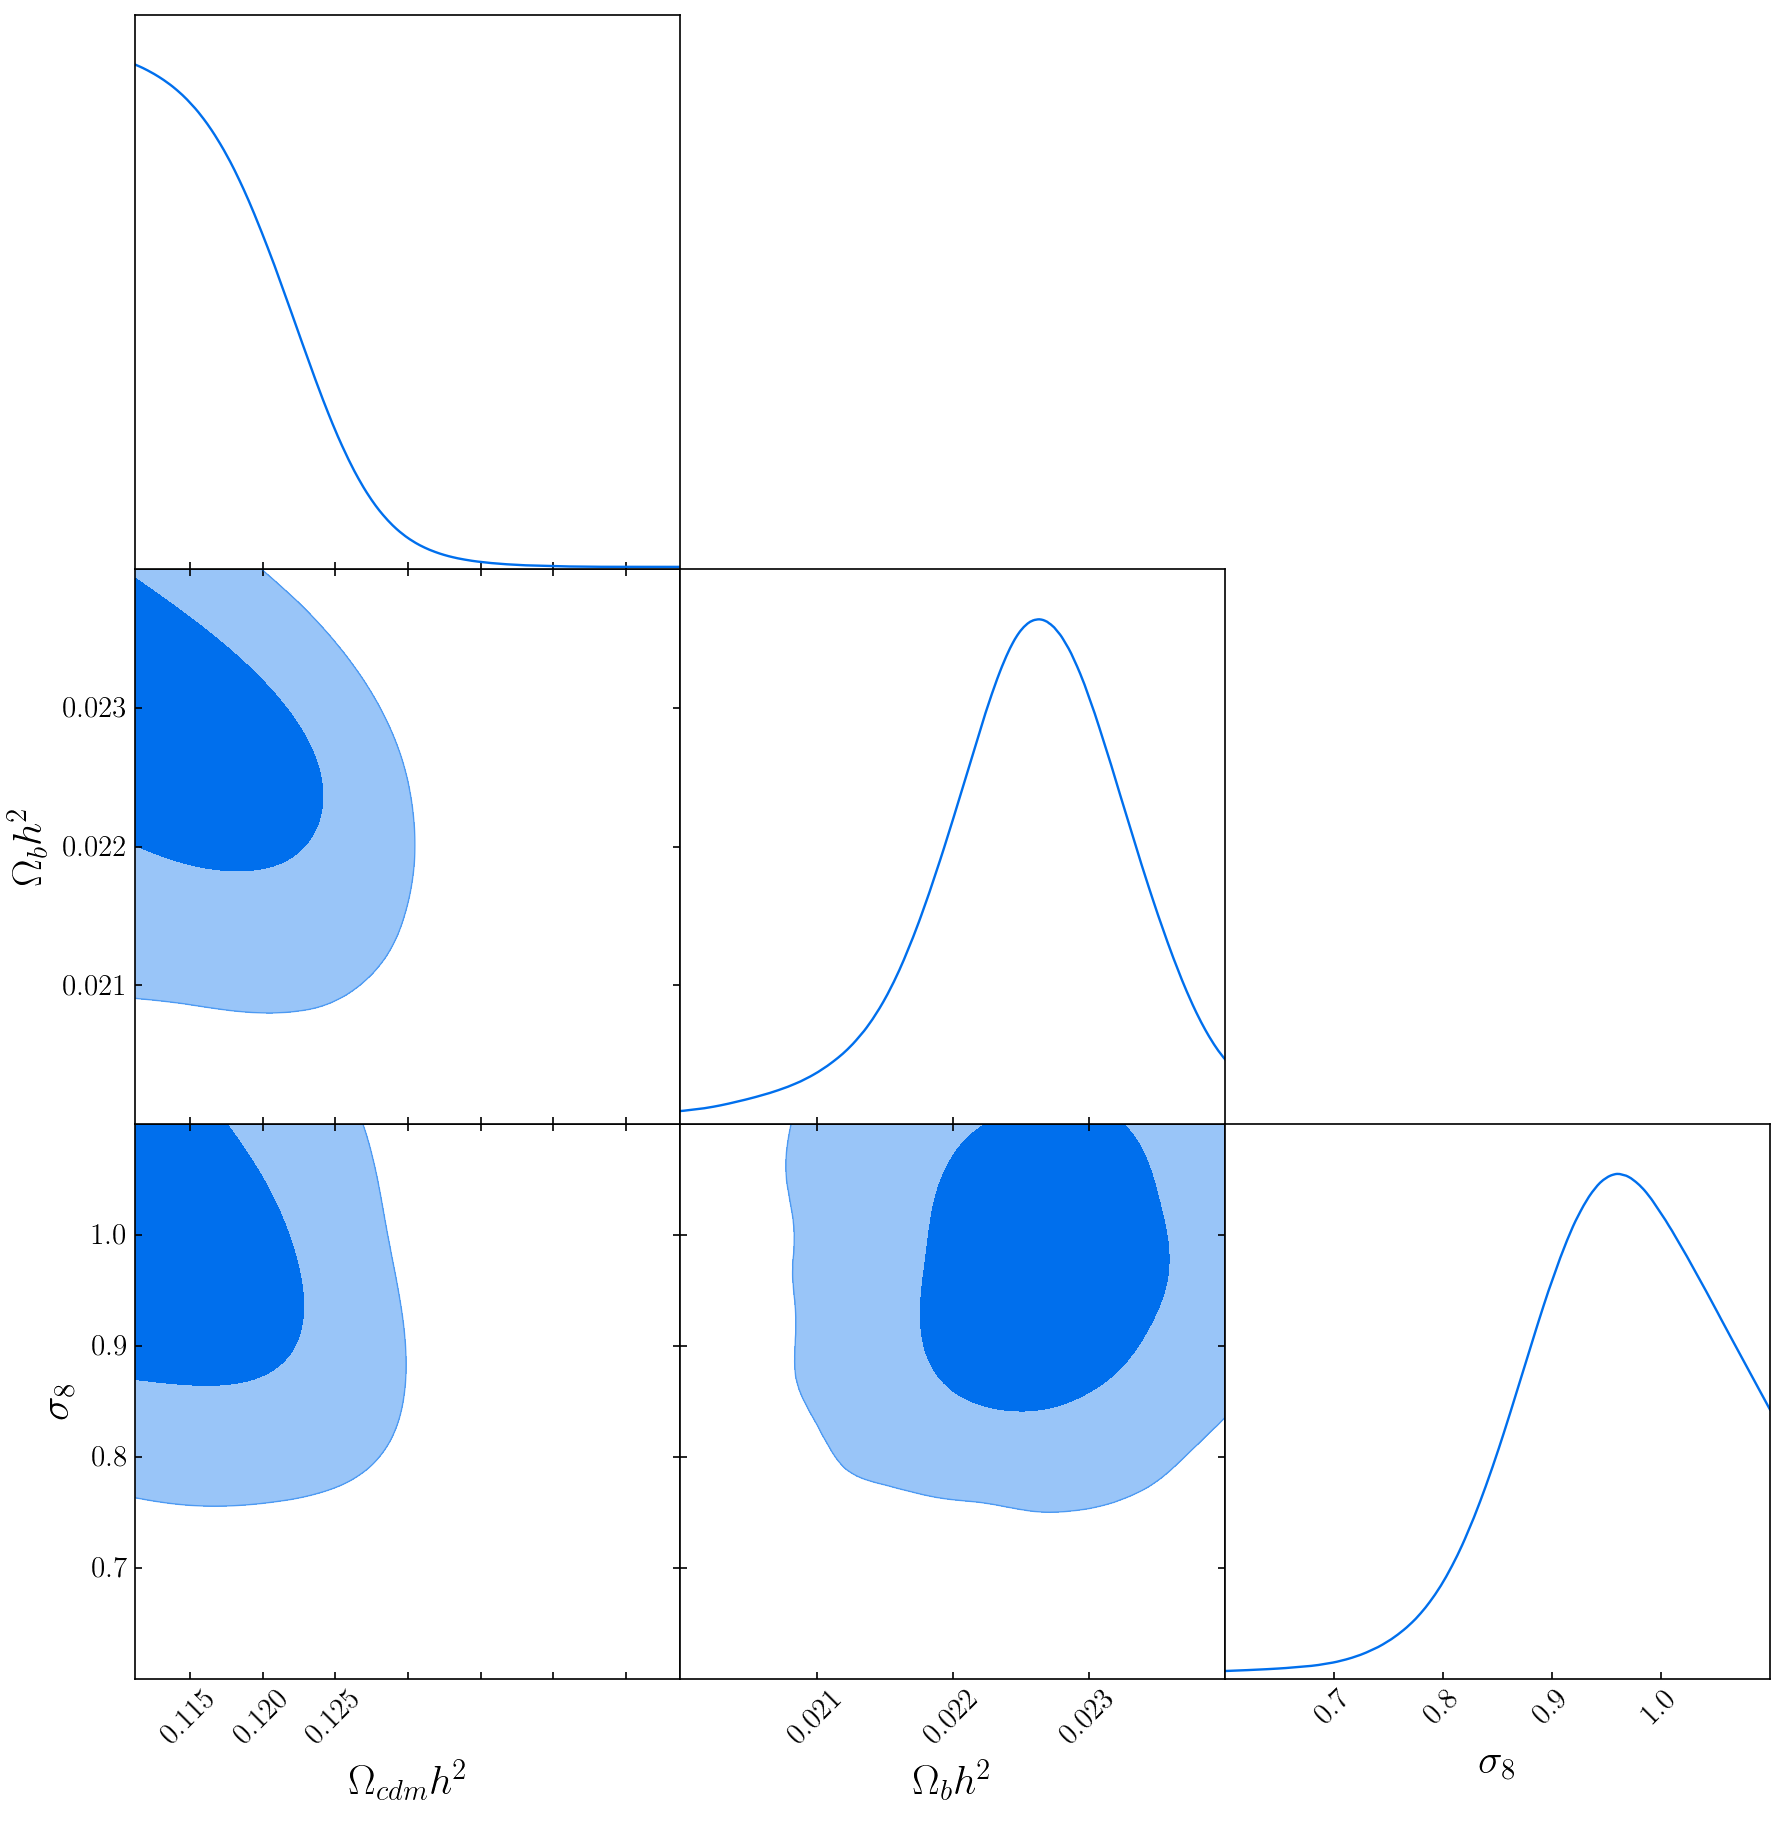

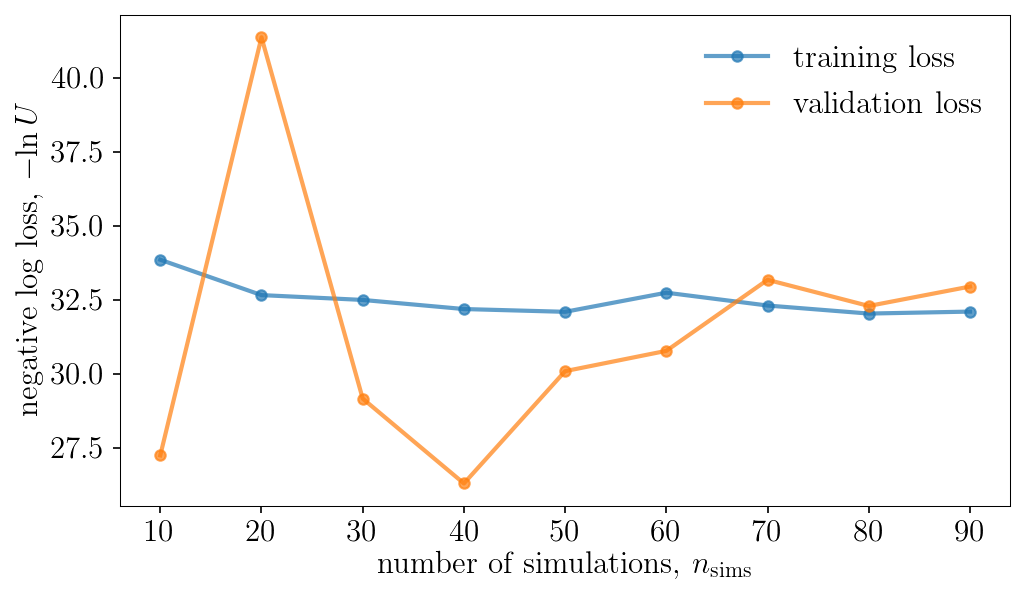

Population 8/50
Sampling proposal density...
Done.


training_loss: [array([85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 84.83361816, 84.83361816,
       84.83361816, 84.83361816, 84.83361816, 84

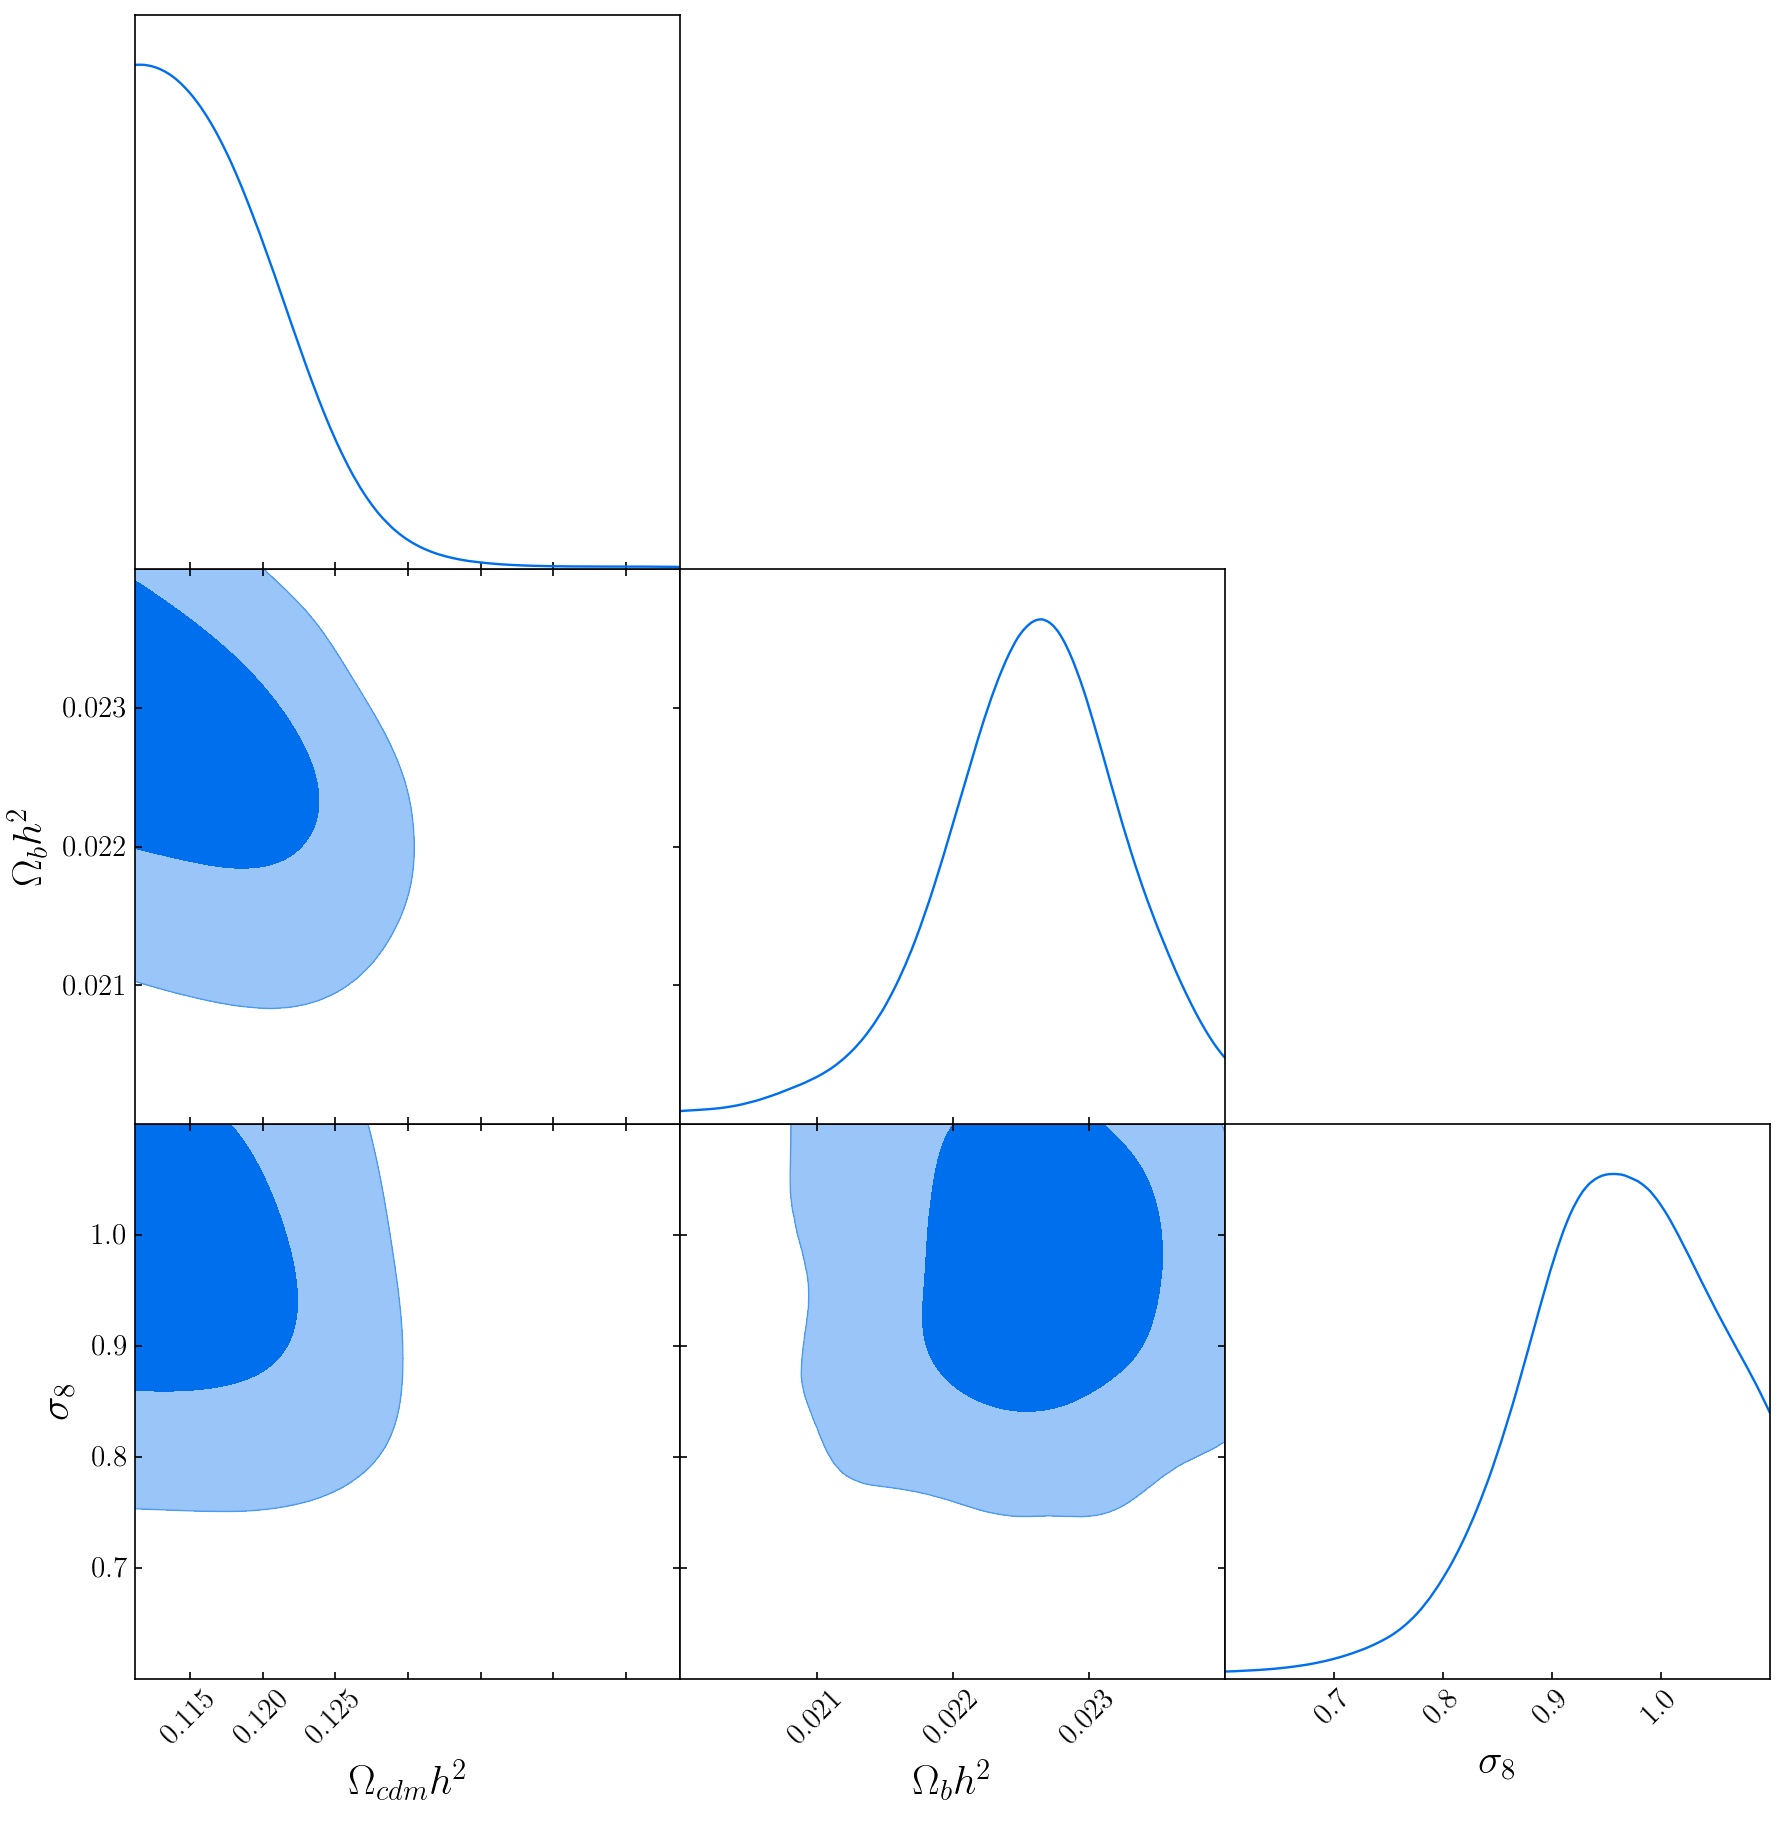

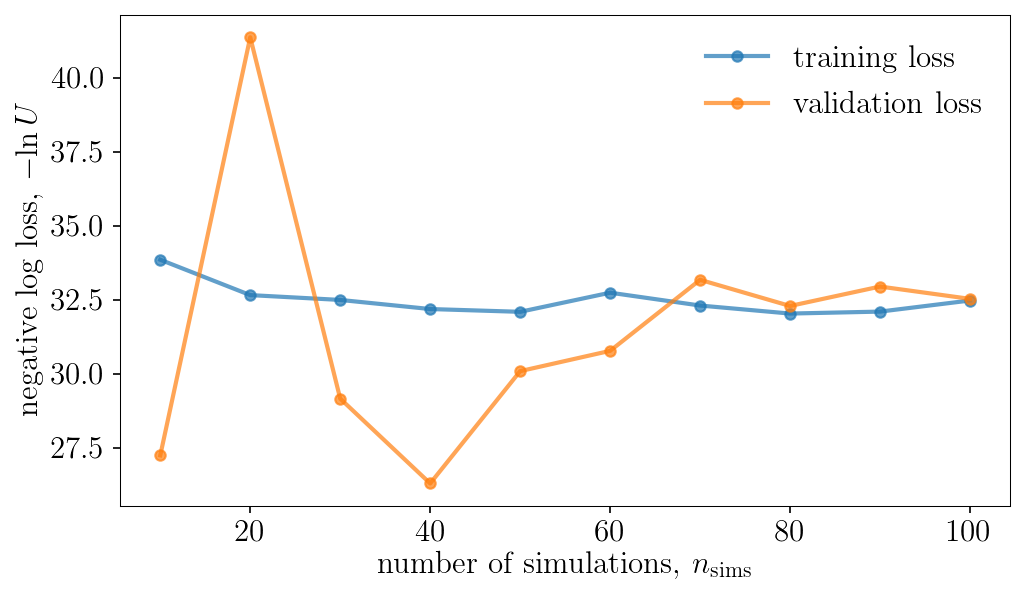

Population 9/50
Sampling proposal density...
Done.


training_loss: [array([85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 85.19564819, 85.19564819,
       85.19564819, 85.19564819, 85.19564819, 84.83361816, 84.83361816,
       84.83361816, 84.83361816, 84.83361816, 84

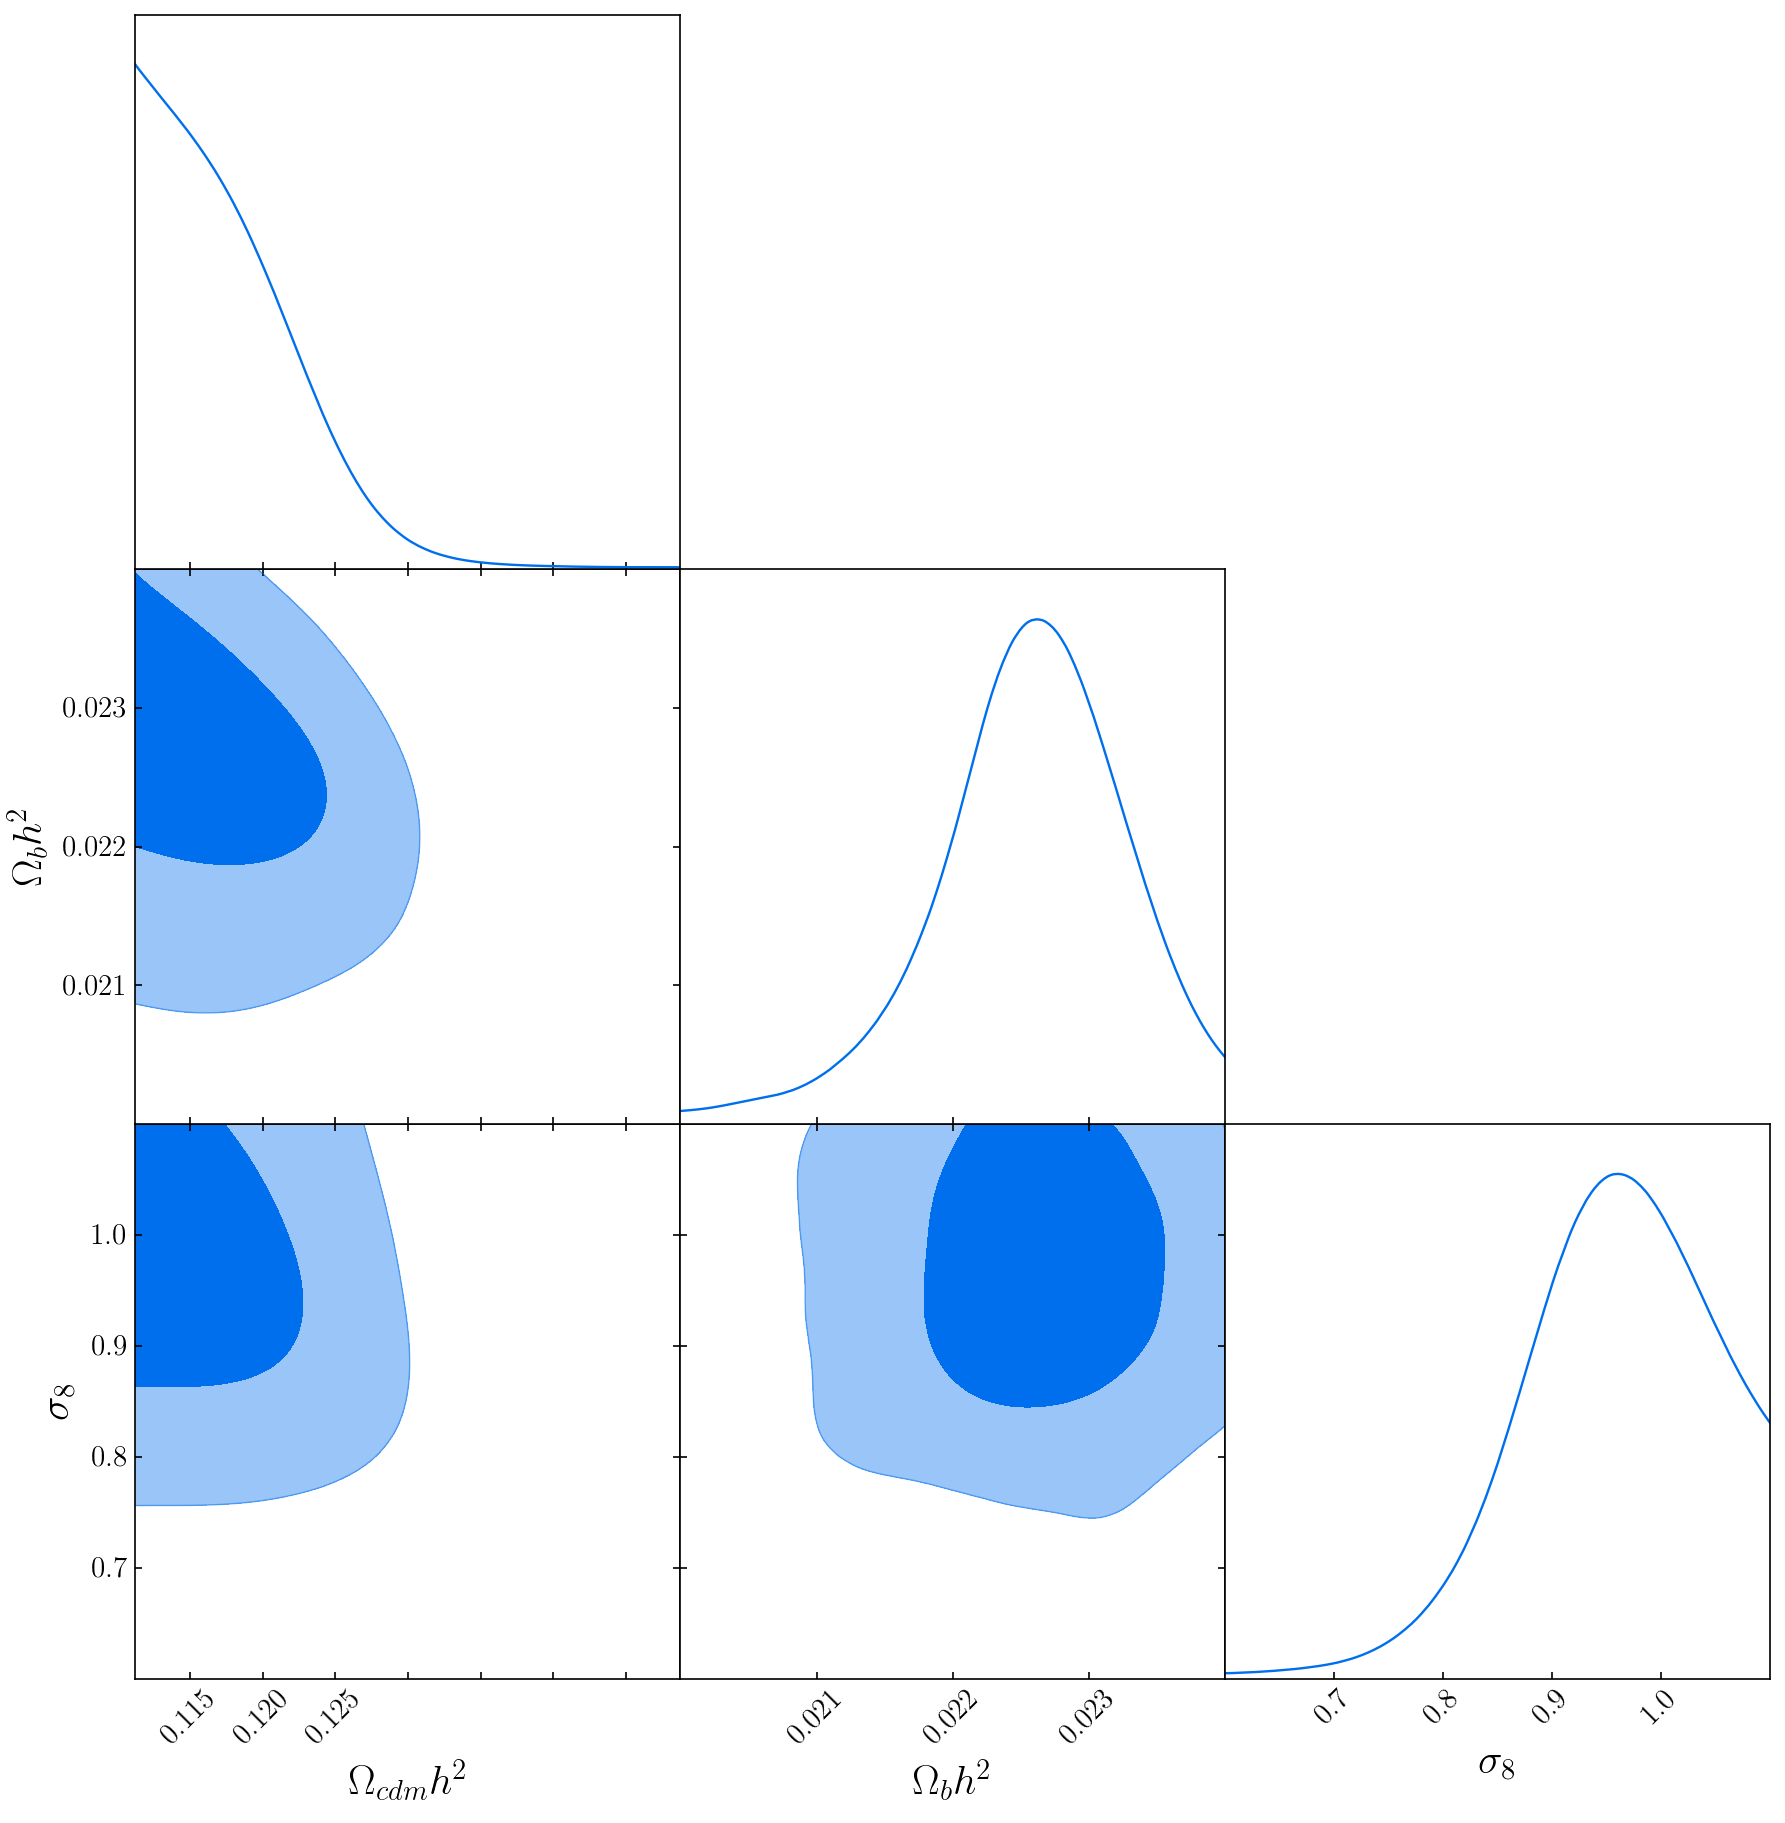

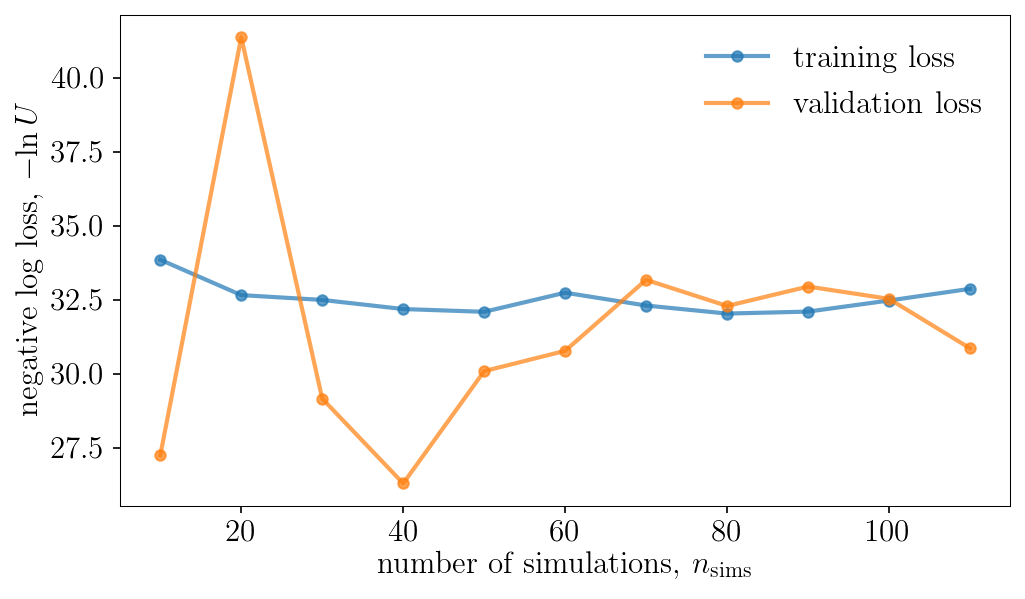

Population 10/50
Sampling proposal density...
Done.


training_loss: [array([ 8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8

/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.
Removed no burn in


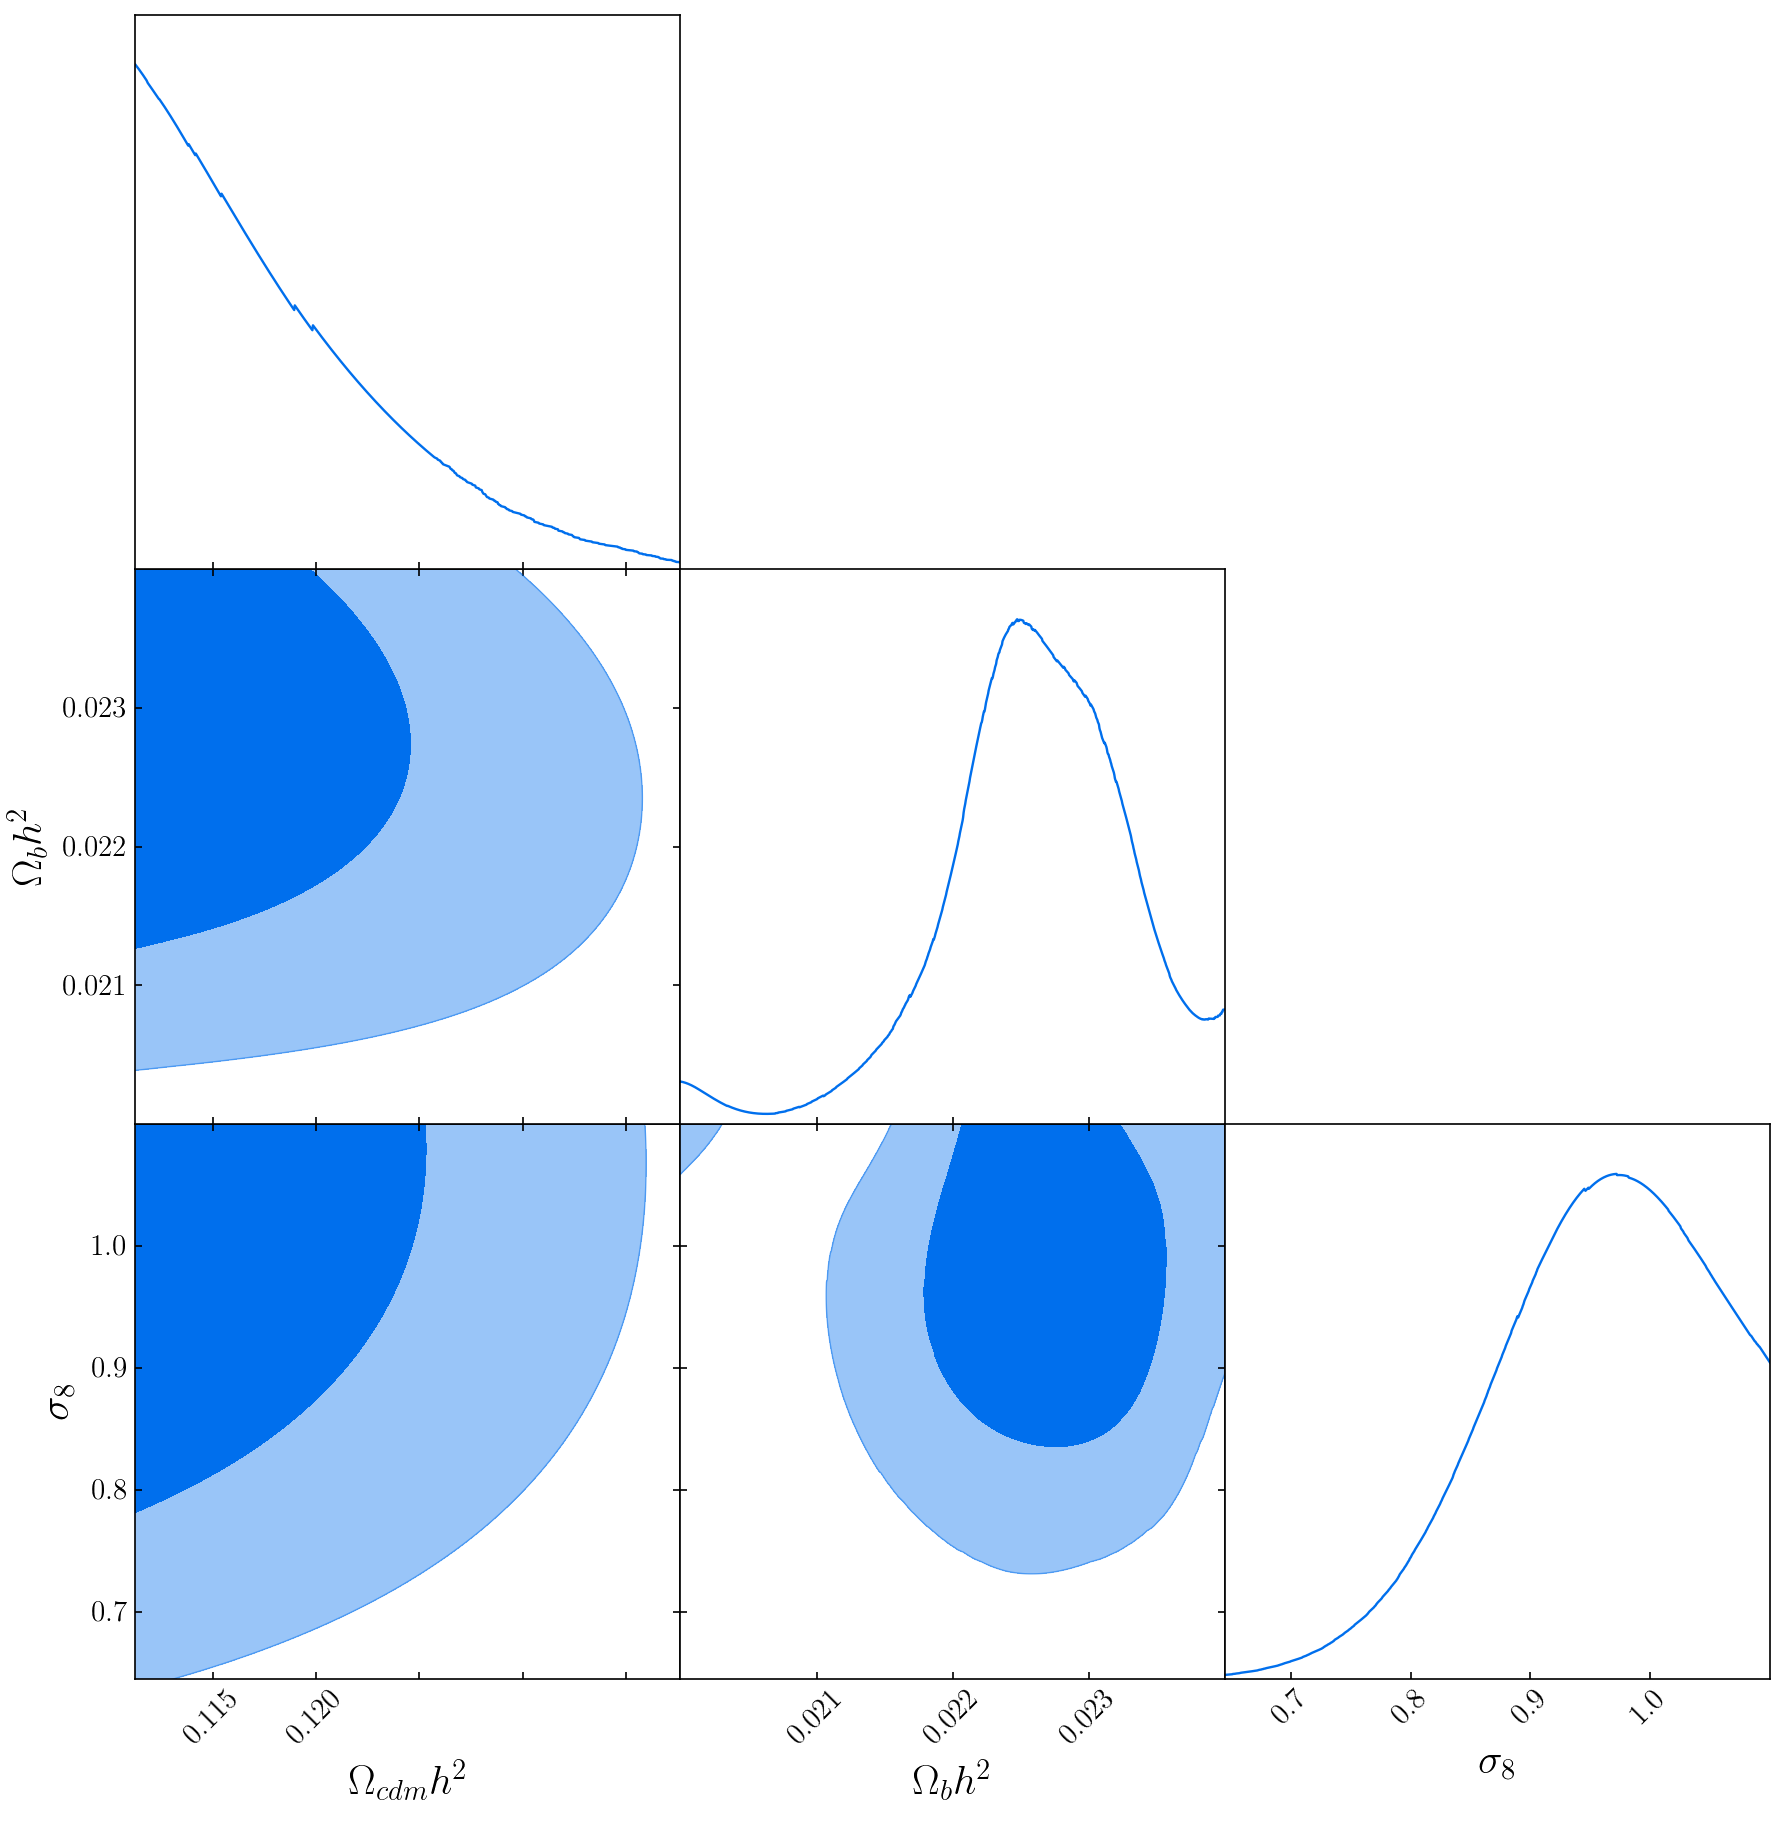

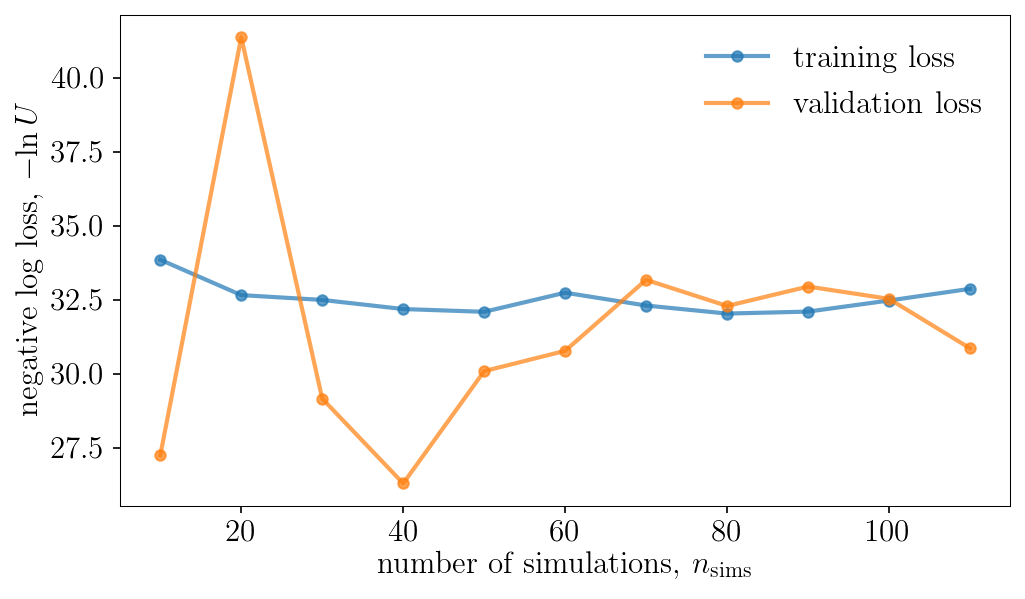

Population 11/50
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


training_loss: [array([ 8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8

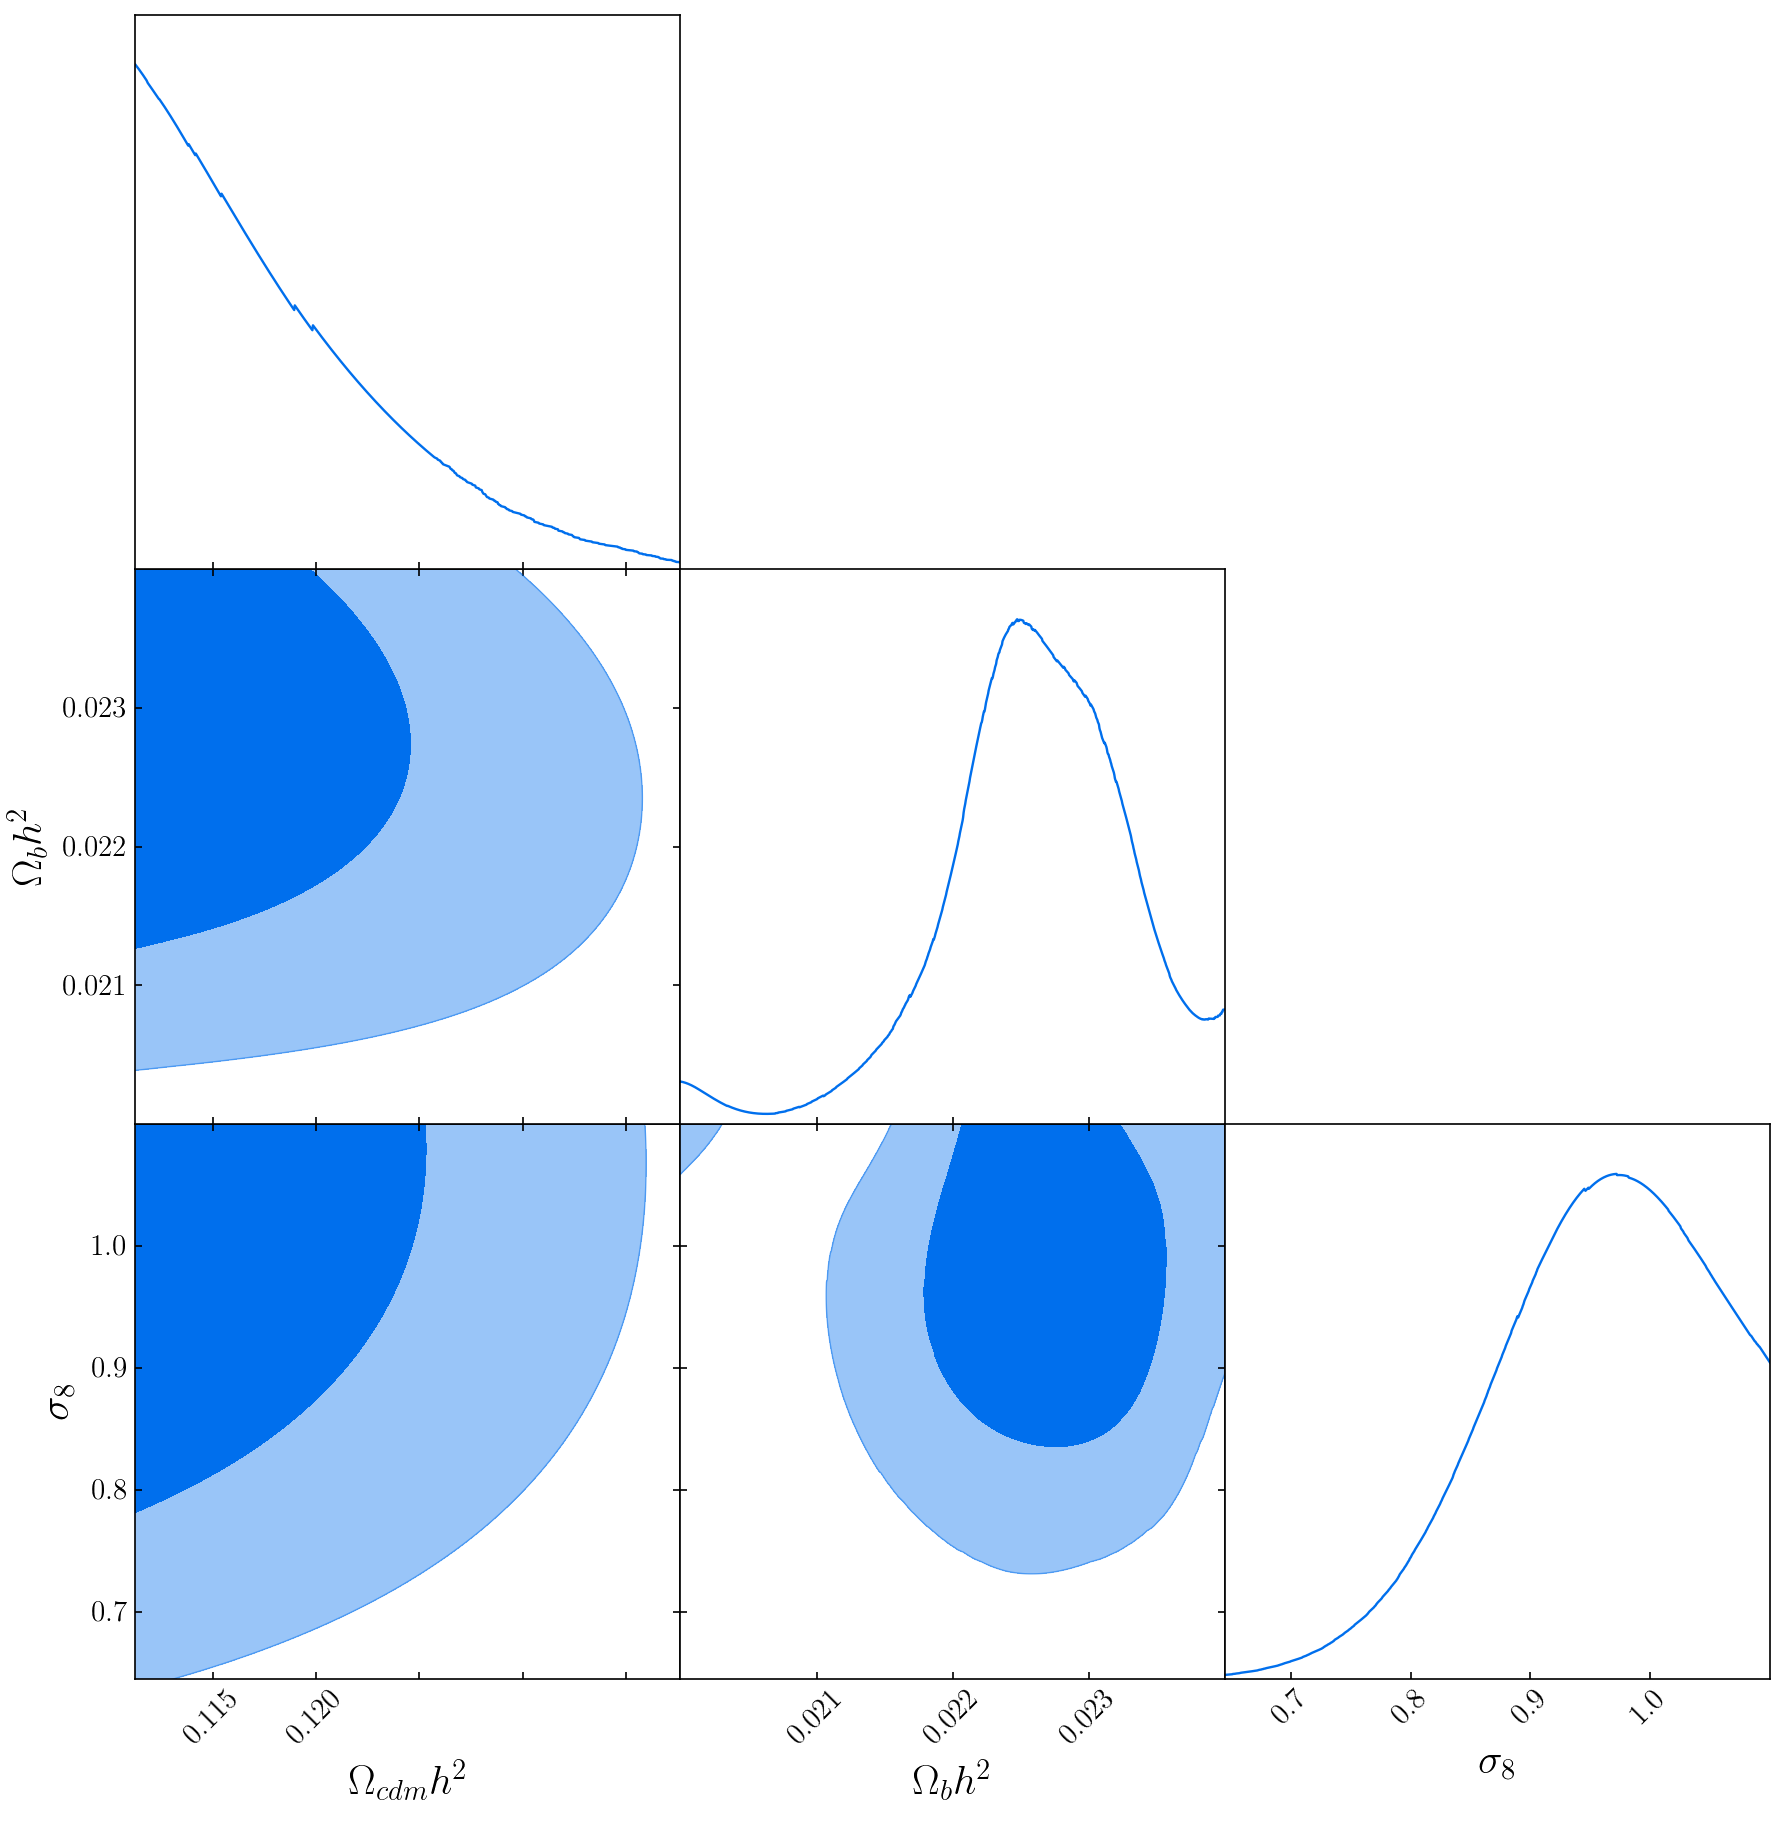

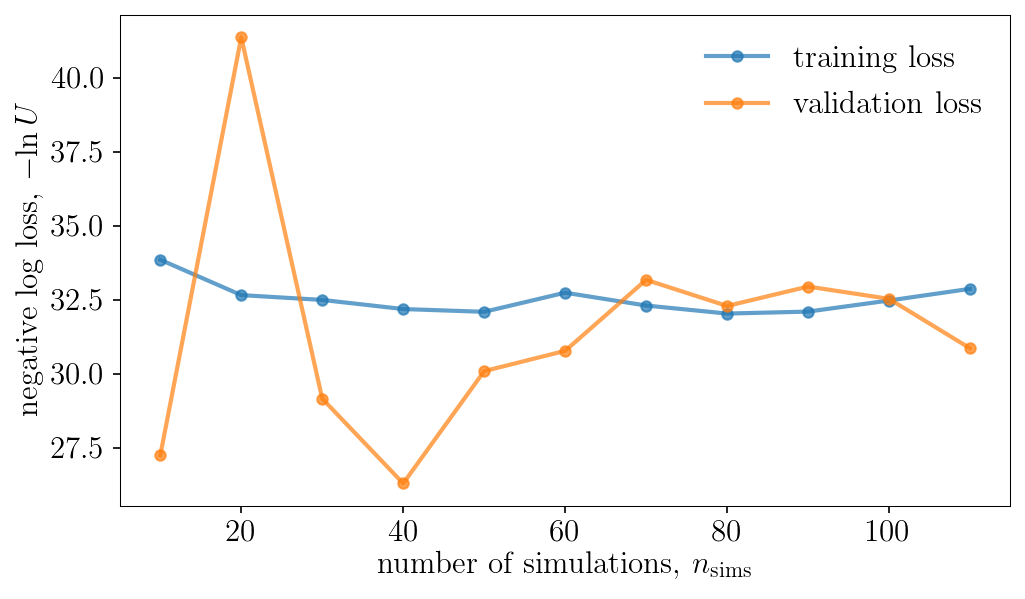

Population 12/50
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


training_loss: [array([ 8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8.51956482e+01,  8.51956482e+01,  8.51956482e+01,  8.51956482e+01,
        8

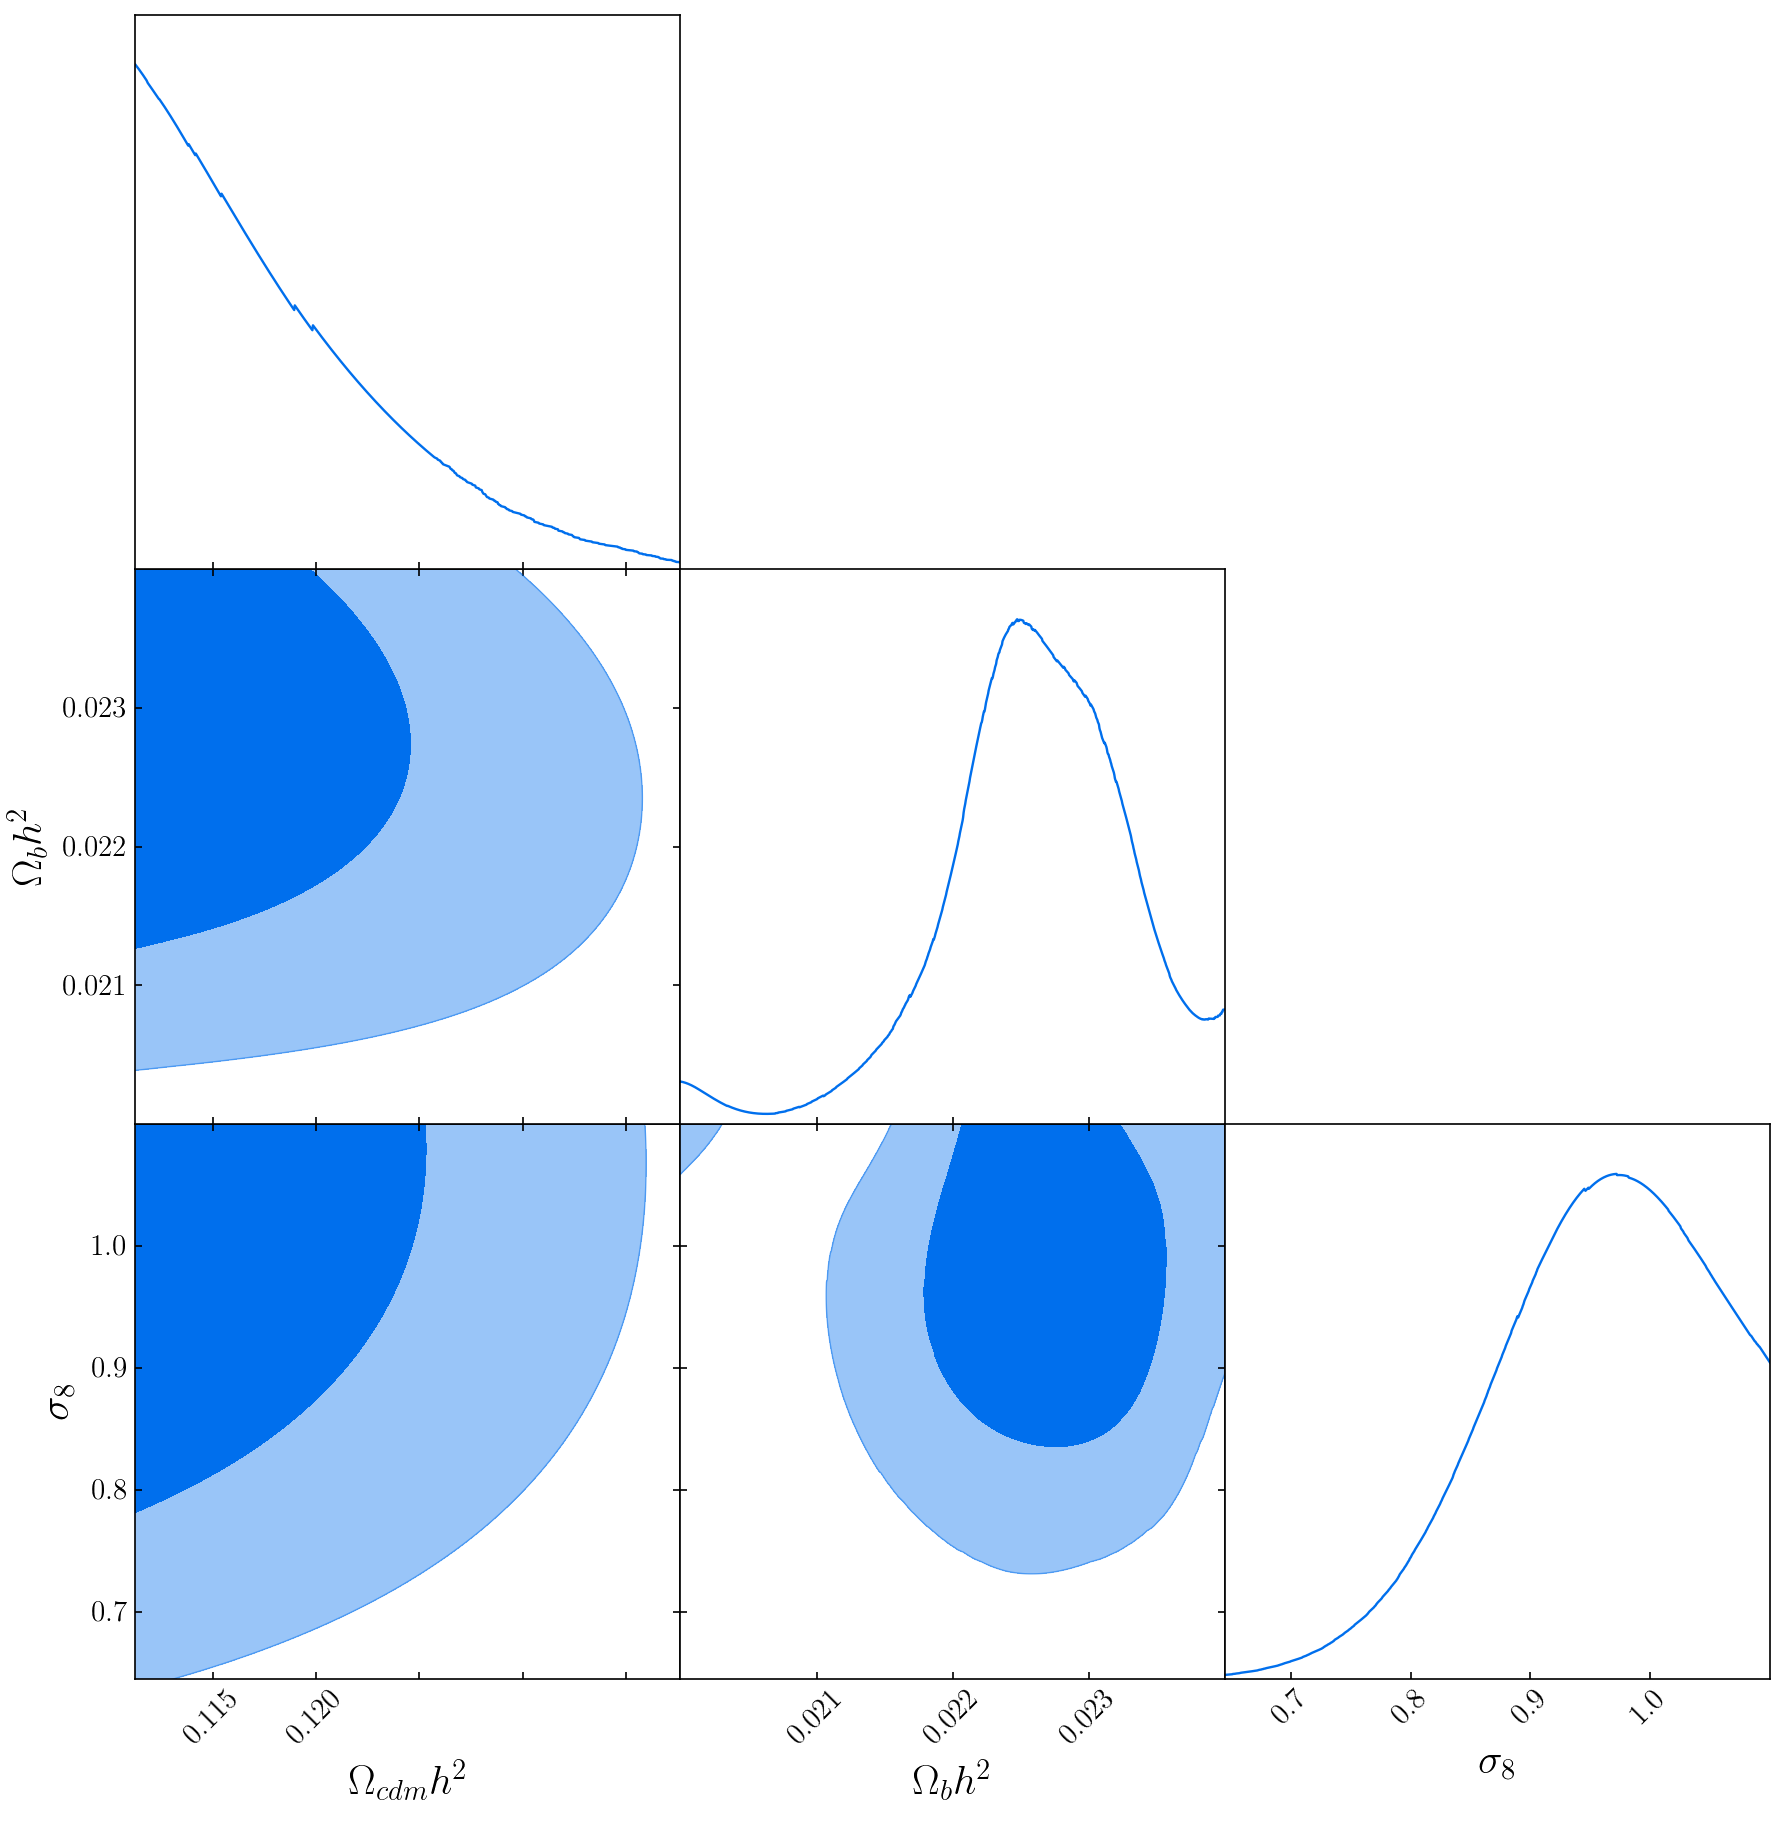

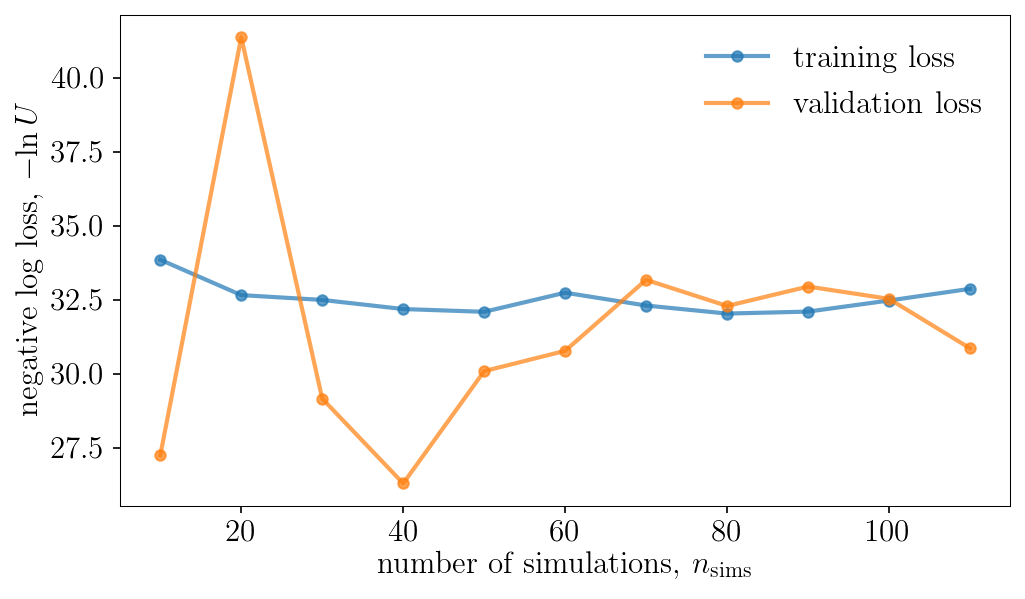

Population 13/50
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


training_loss: [array([ 85.19564819,  85.19564819,  85.19564819, ..., -29.42408562,
       -29.43144035, -29.45630264]), array([ 85.1725769 ,  85.1725769 ,  85.1725769 , ..., -31.86074257,
       -31.89814758, -31.81352806]), array([ 7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01, 

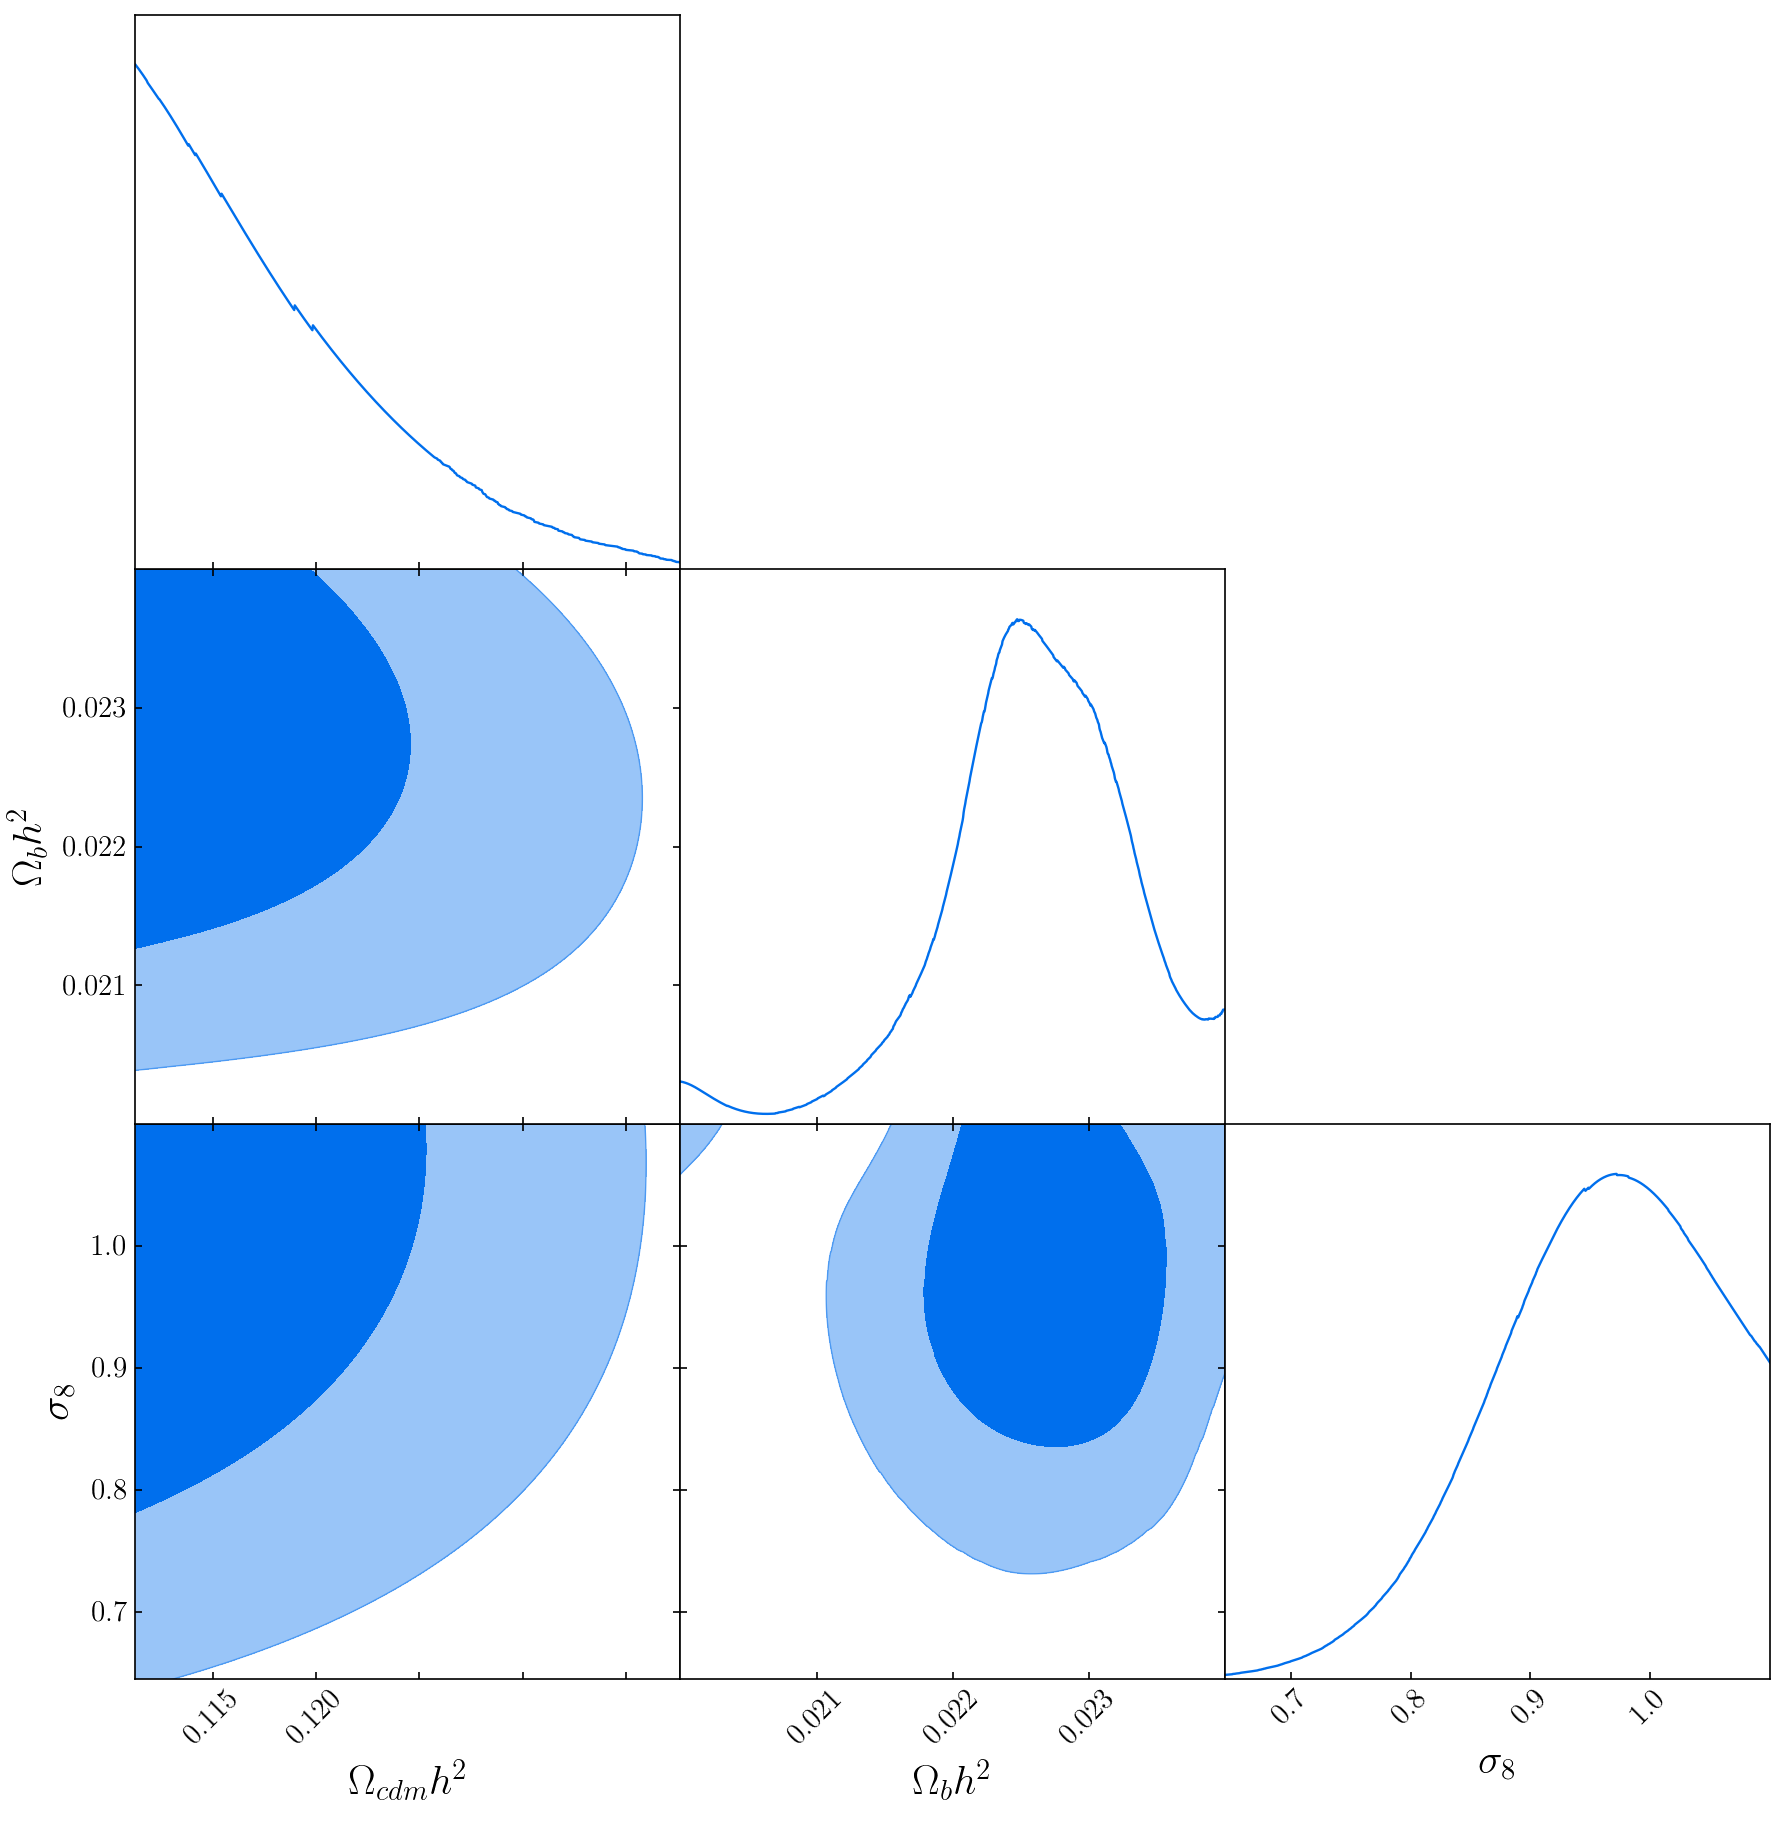

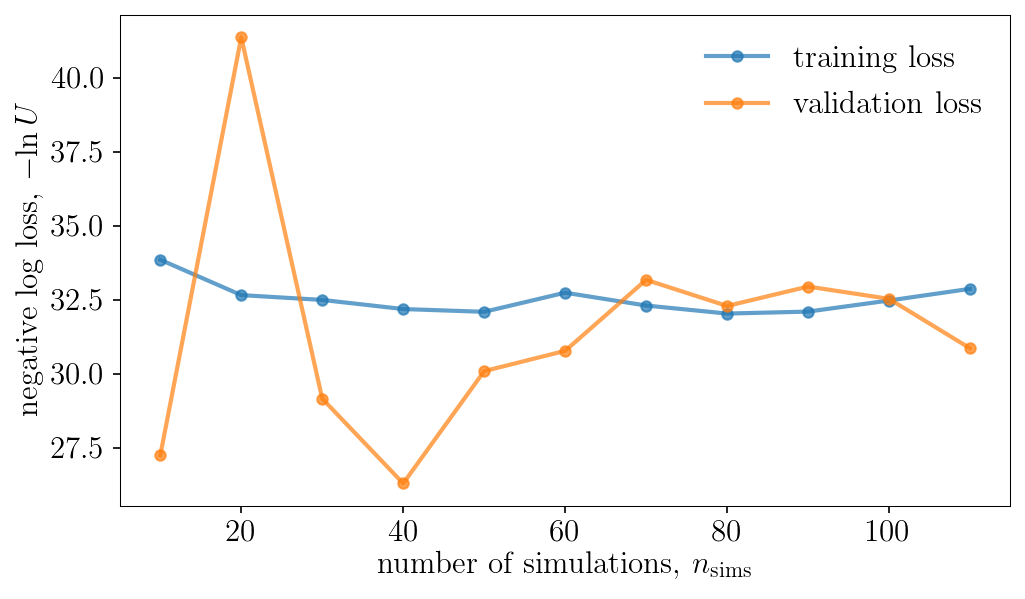

Population 14/50
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


training_loss: [array([ 85.19564819,  85.19564819,  85.19564819, ..., -28.25667572,
       -28.27845001, -28.30739975]), array([ 85.1725769 ,  85.1725769 ,  85.1725769 , ..., -31.94499969,
       -31.81397247, -31.88703156]), array([ 7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01, 

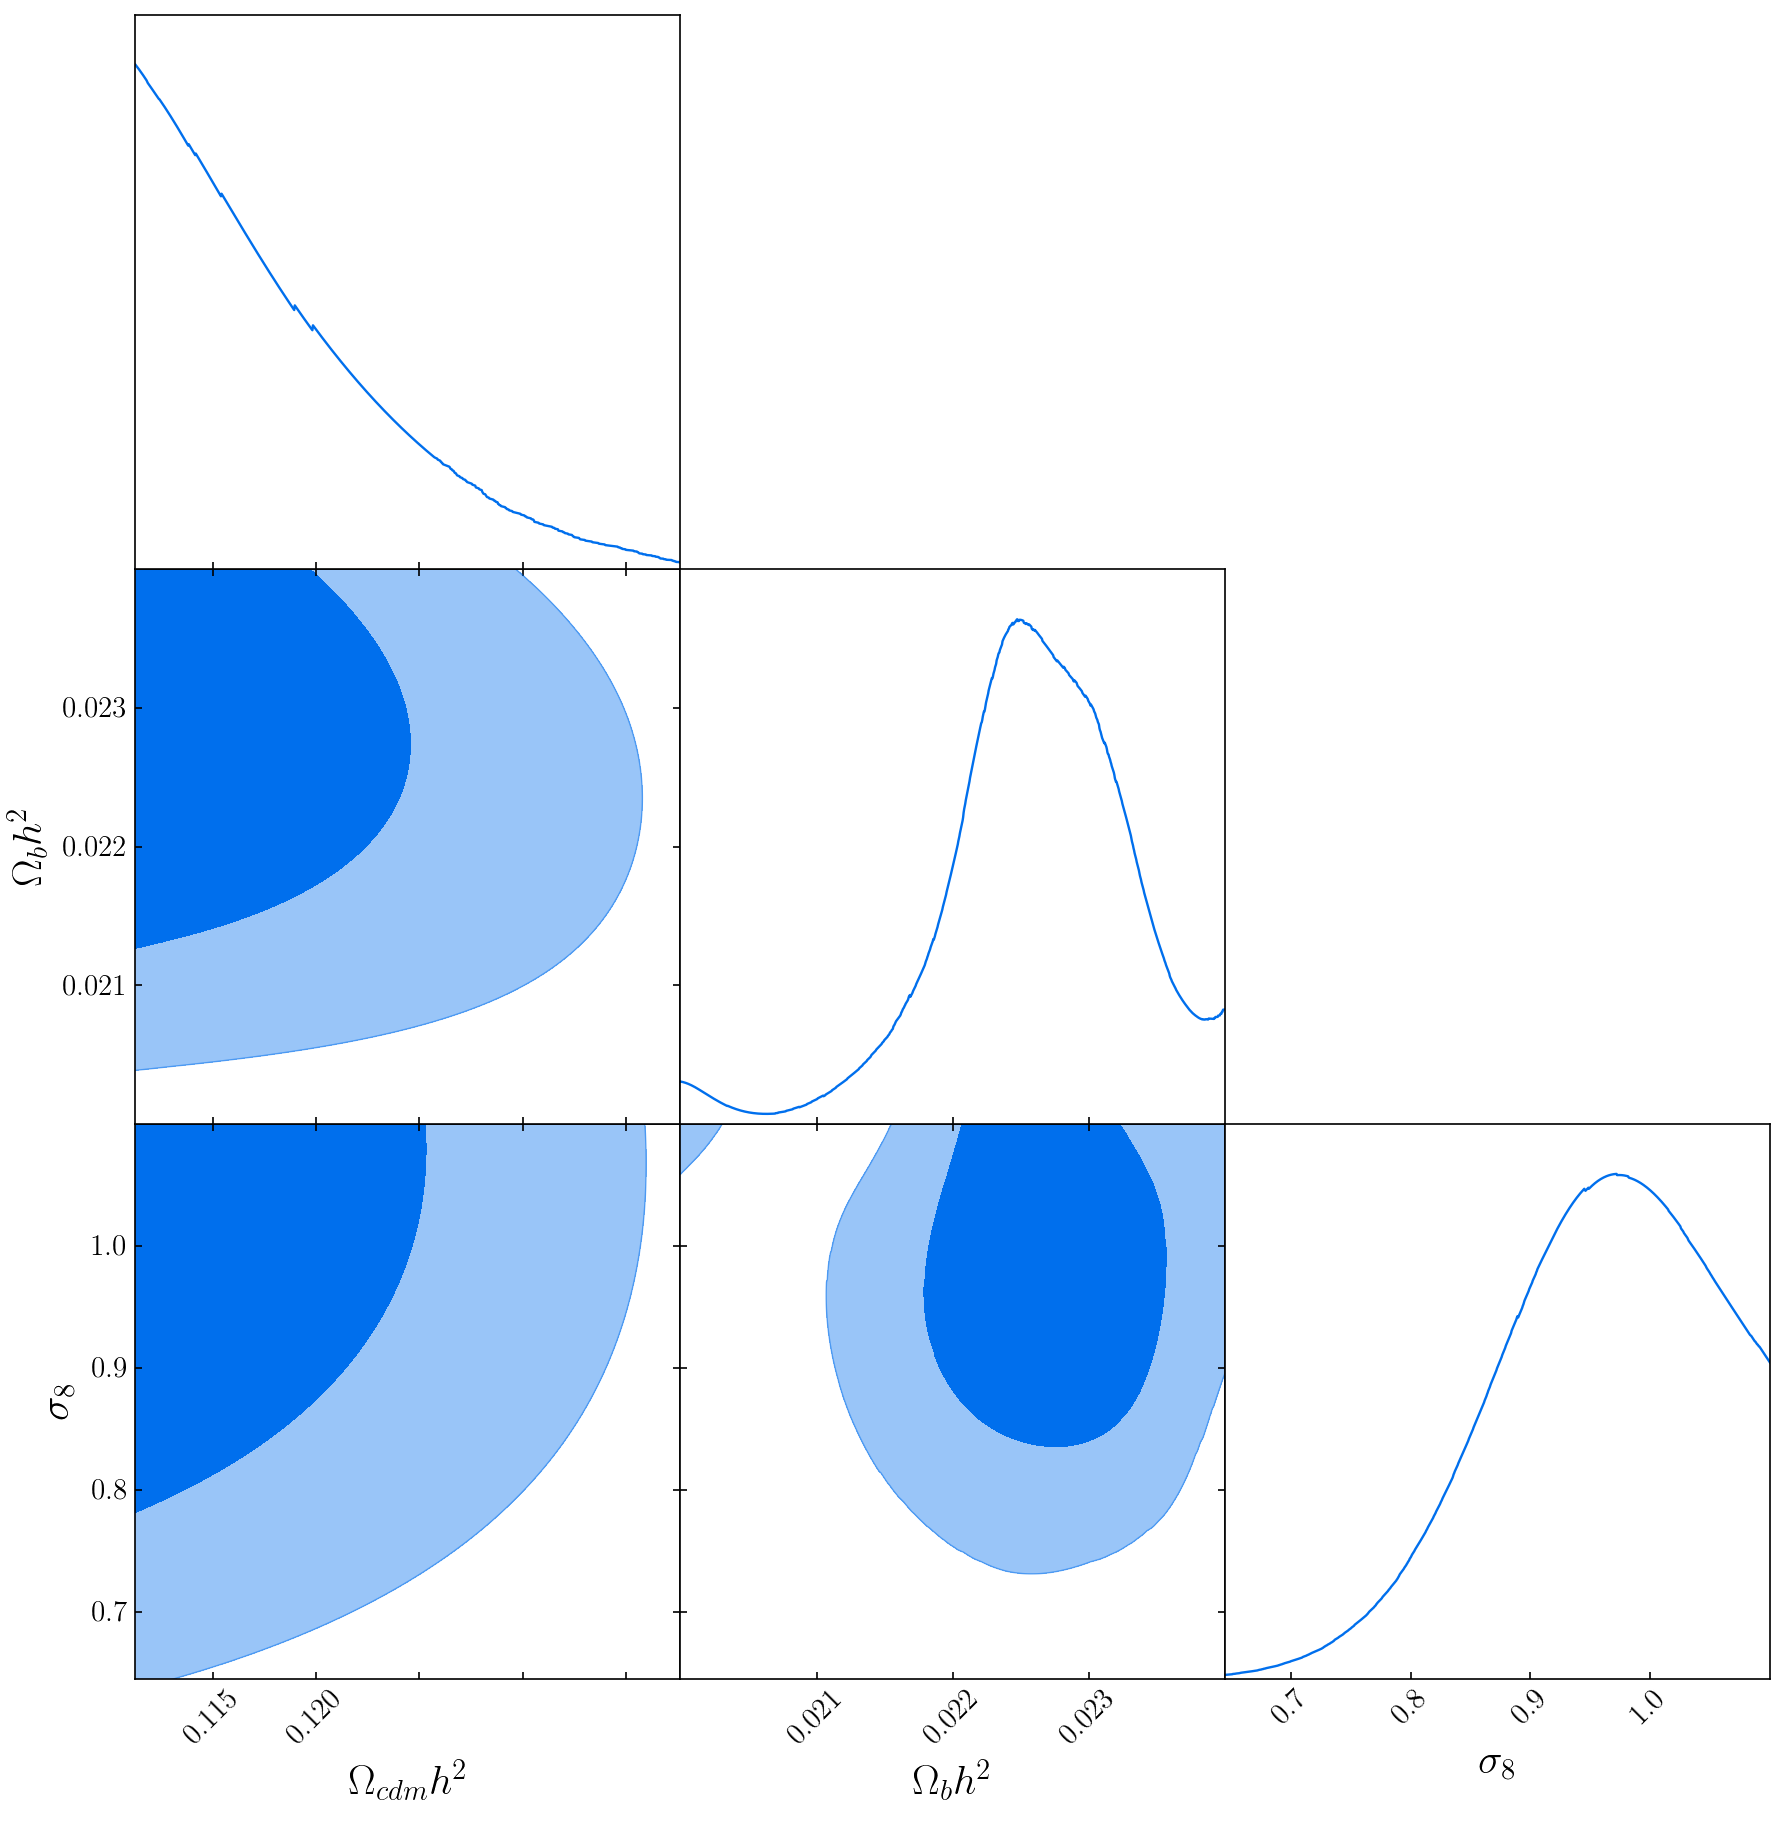

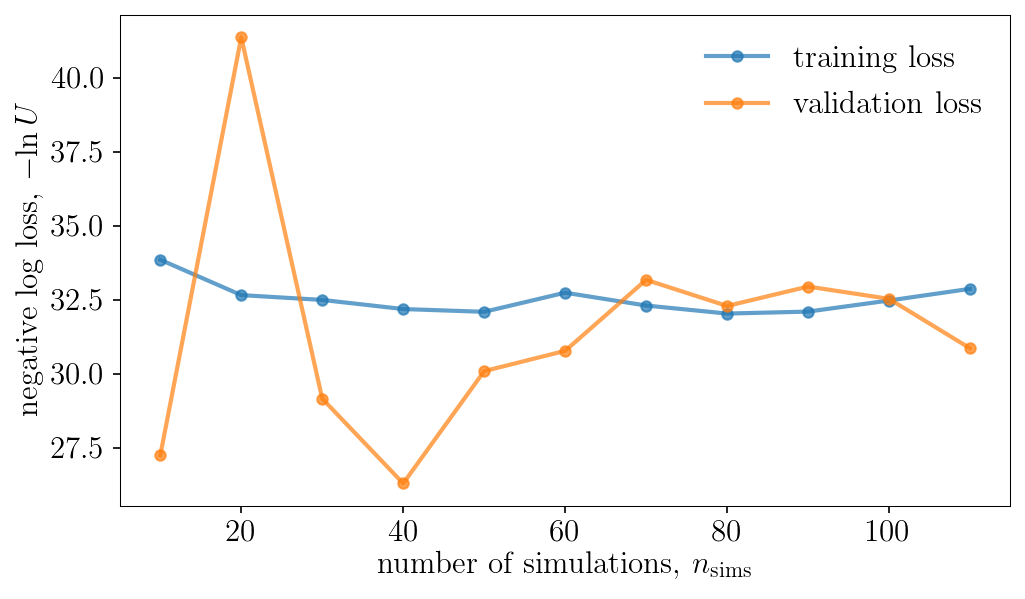

Population 15/50
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


training_loss: [array([ 85.19564819,  85.19564819,  85.19564819, ..., -27.80949402,
       -27.84837341, -27.92570877]), array([ 85.1725769 ,  85.1725769 ,  85.1725769 , ..., -30.29679108,
       -30.23778725, -30.42737007]), array([ 7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01, 

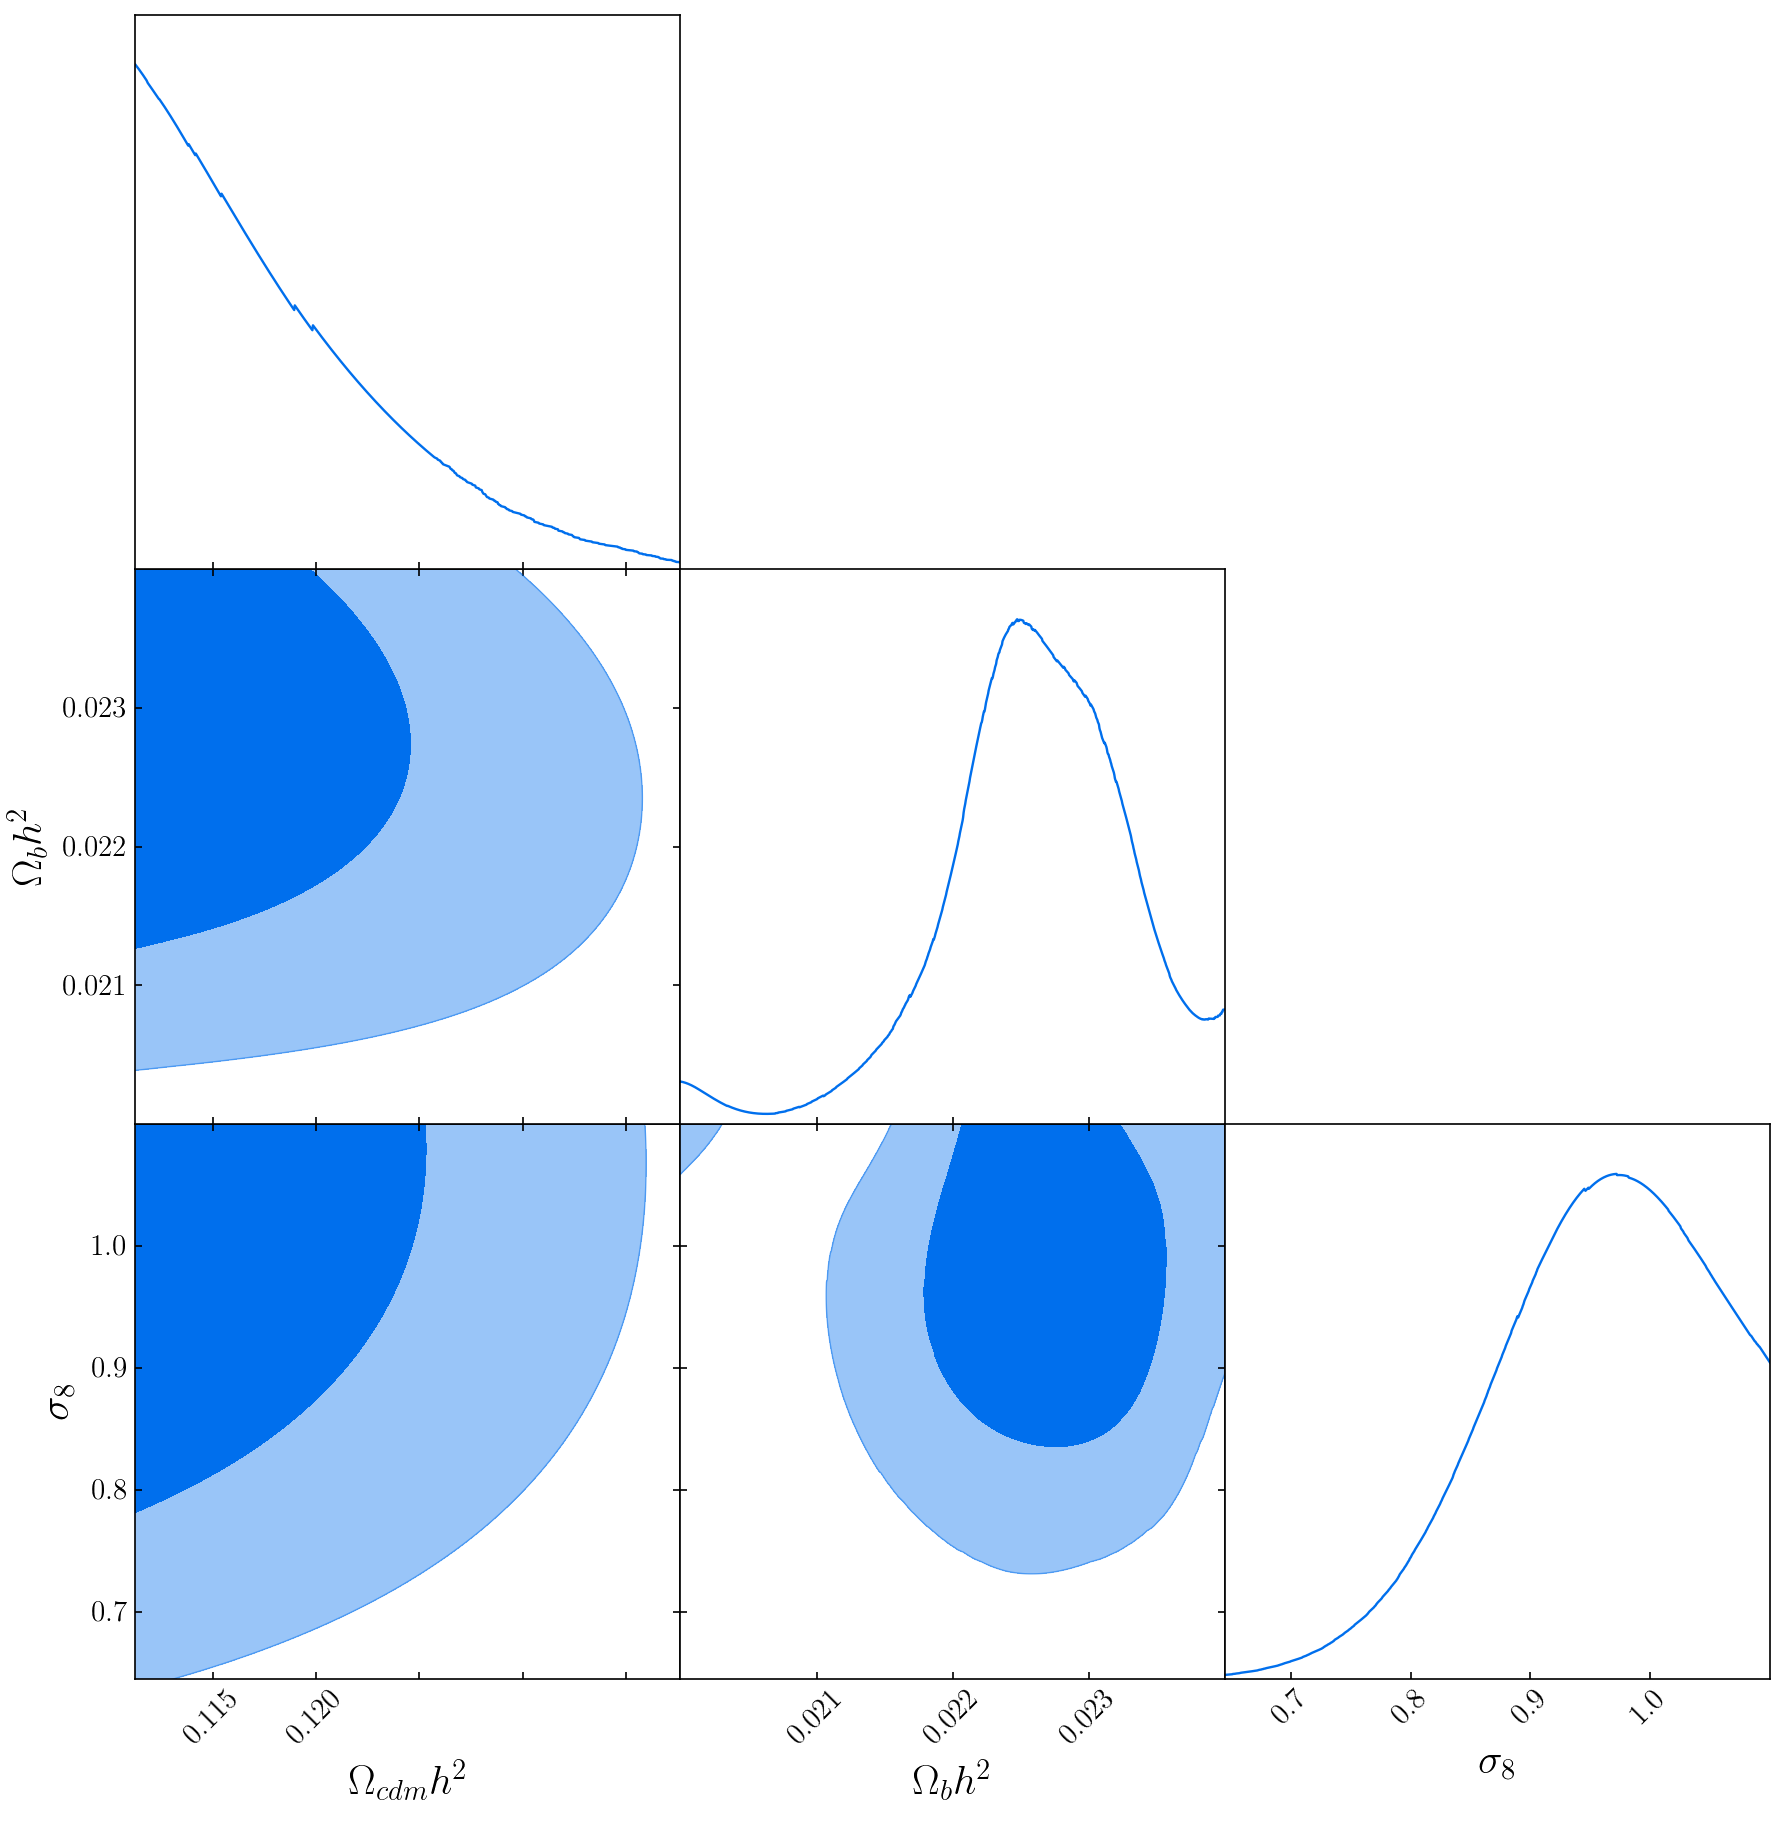

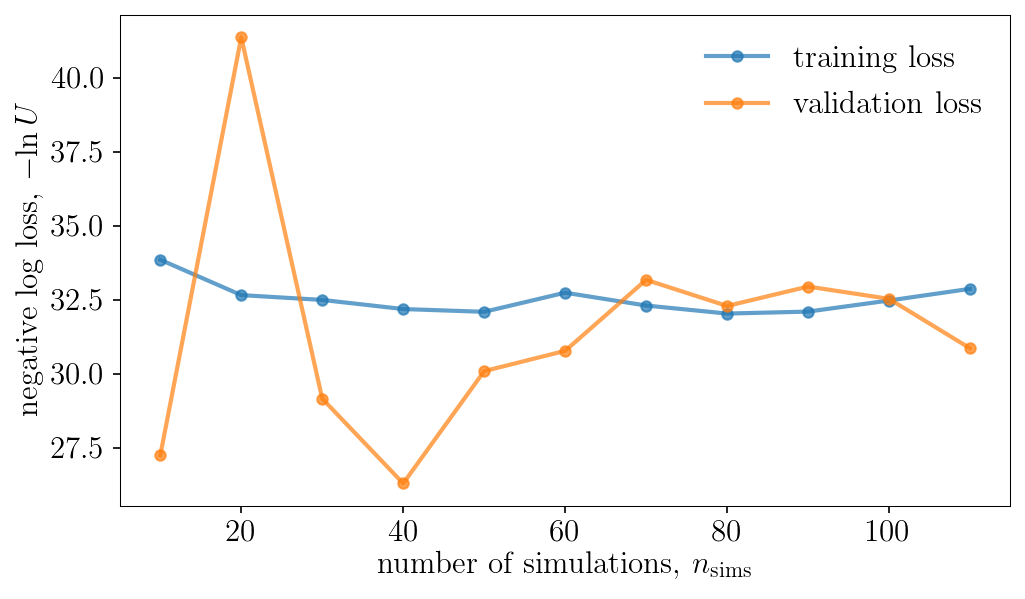

Population 16/50
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


training_loss: [array([ 85.19564819,  85.19564819,  85.19564819, ..., -27.90293694,
       -27.90184975, -27.97657776]), array([ 85.1725769 ,  85.1725769 ,  85.1725769 , ..., -29.9861927 ,
       -29.94636536, -29.94754219]), array([ 7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01, 

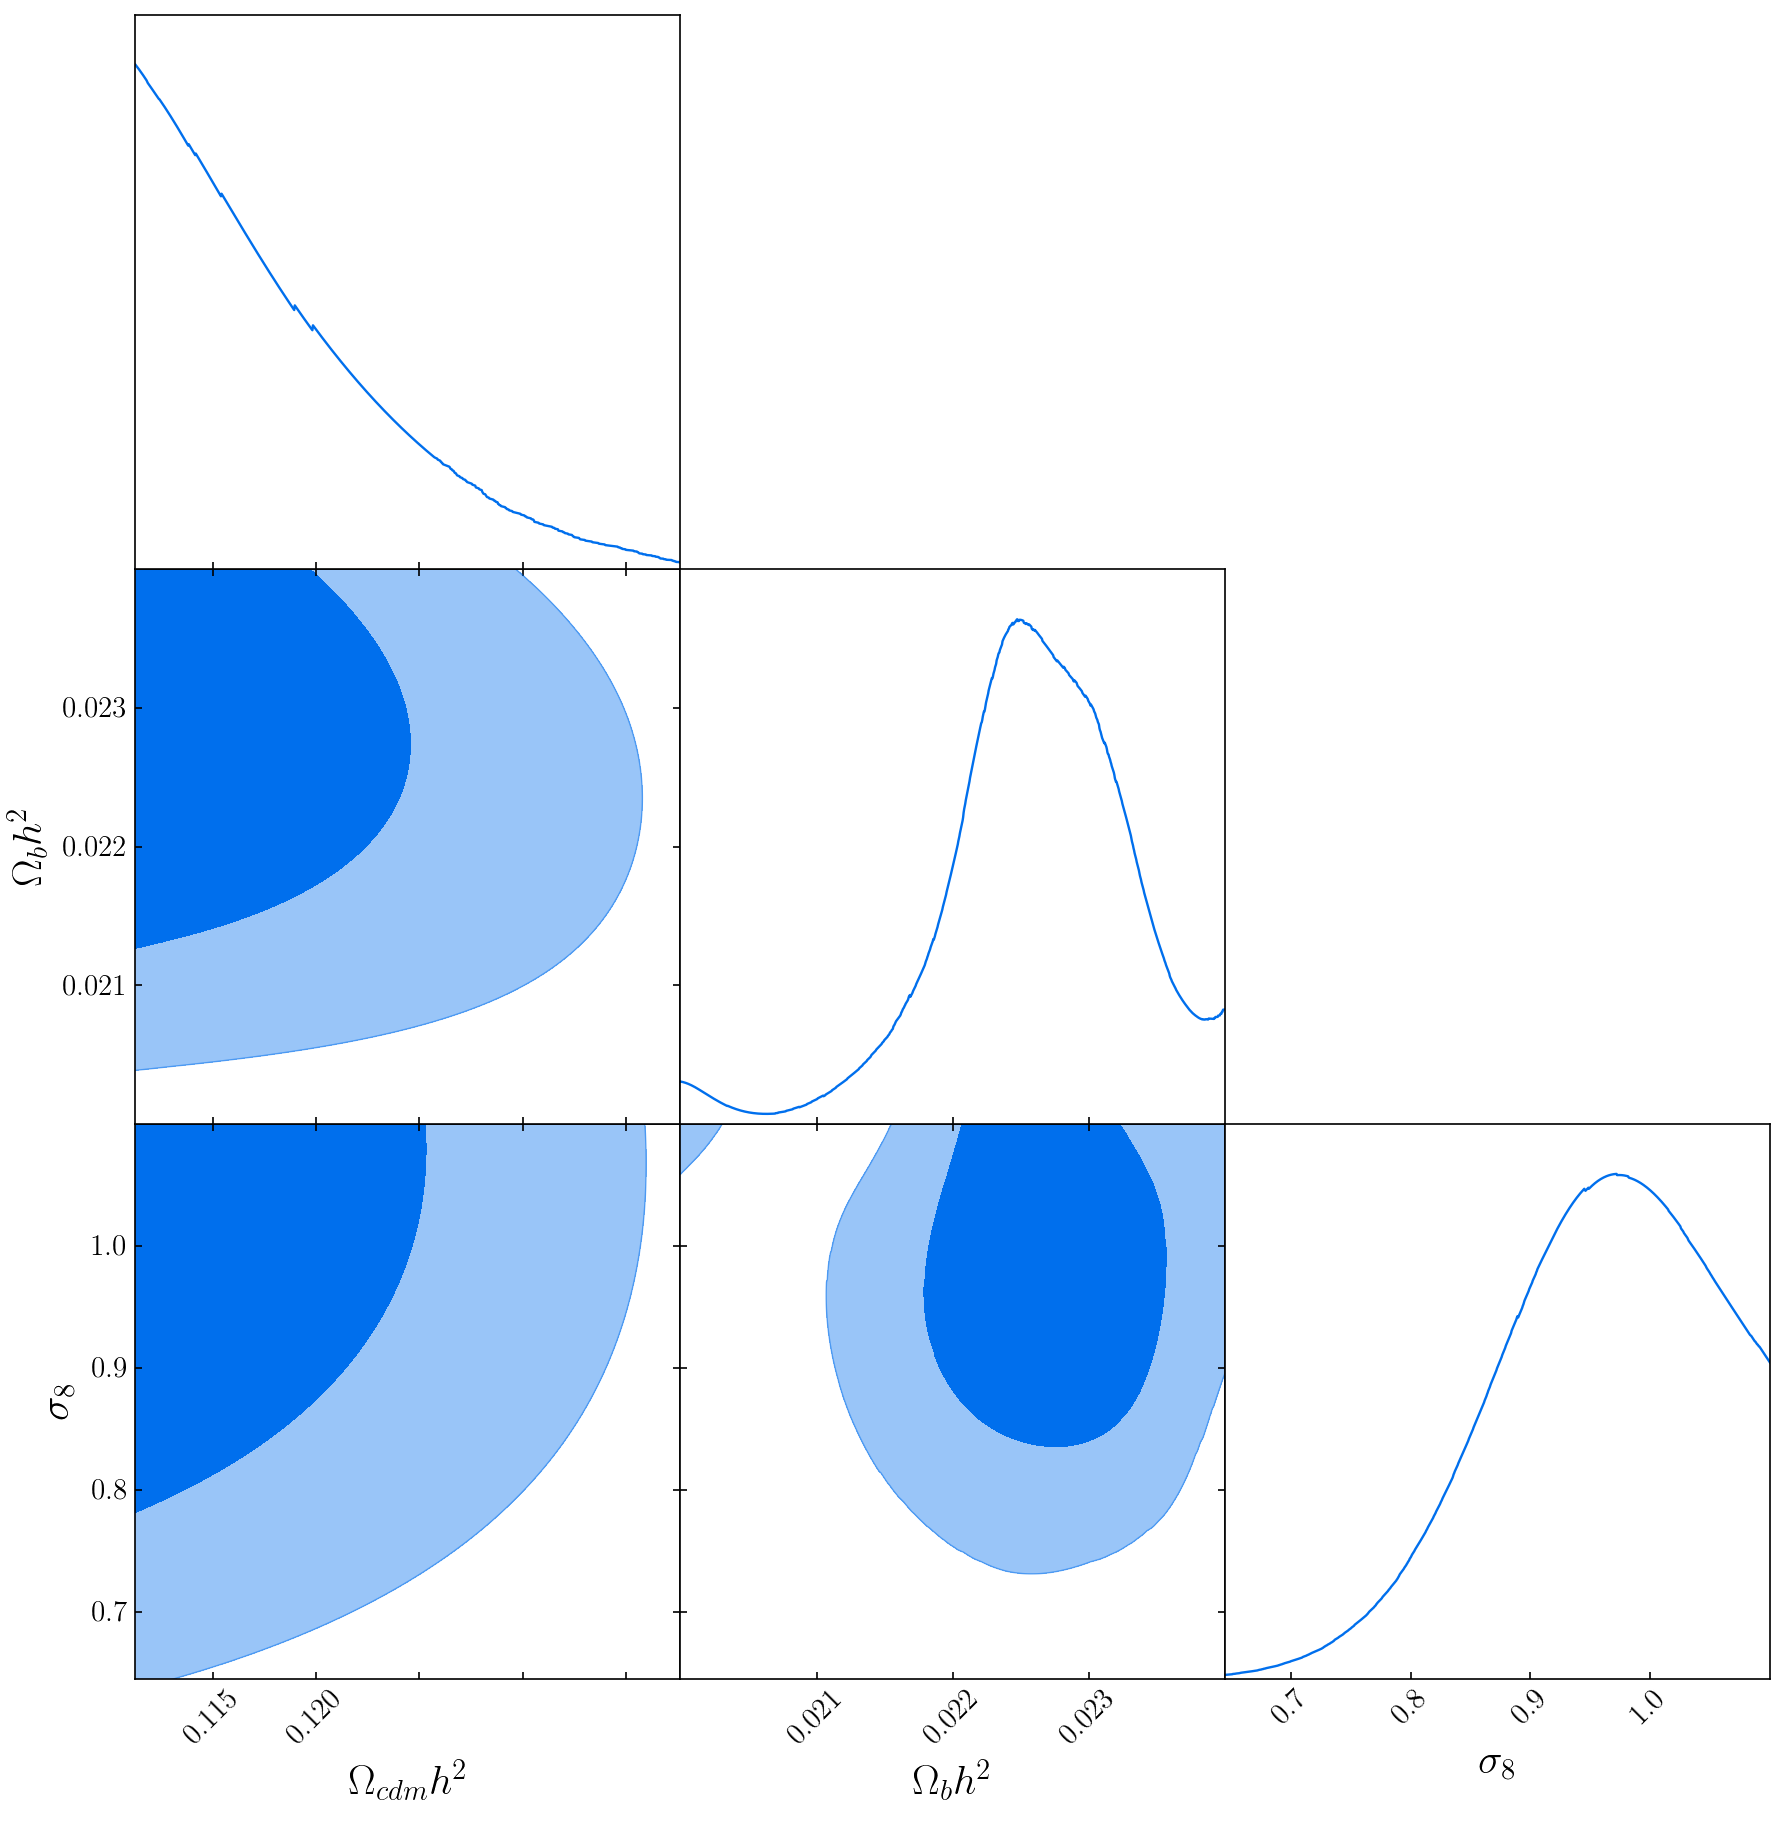

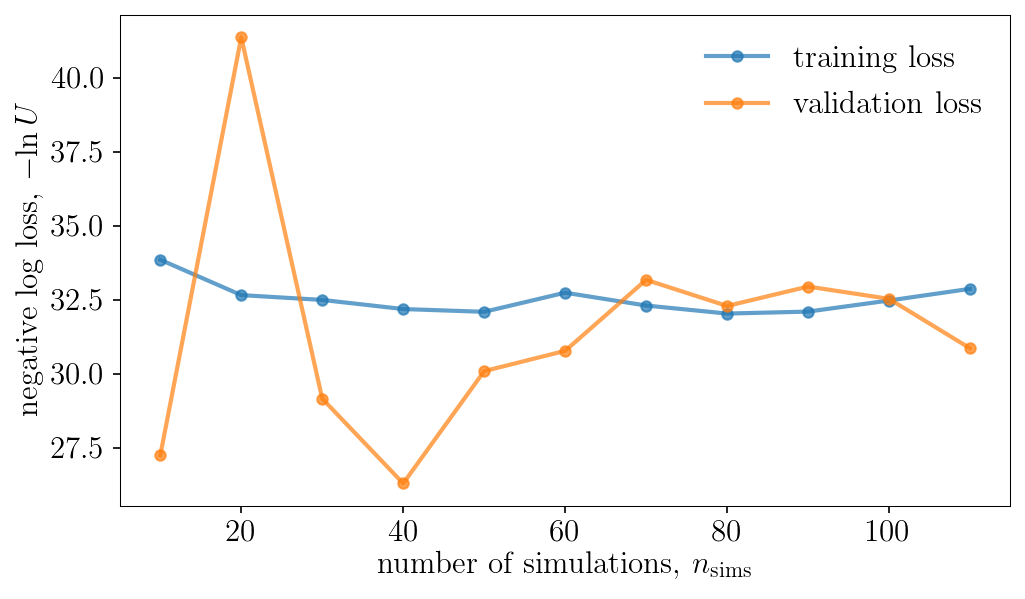

Population 17/50
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


training_loss: [array([ 85.19564819,  85.19564819,  85.19564819, ..., -26.44348526,
       -26.49272919, -26.45427895]), array([ 85.1725769 ,  85.1725769 ,  85.1725769 , ..., -29.50627136,
       -29.62134171, -29.51503944]), array([ 7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01, 

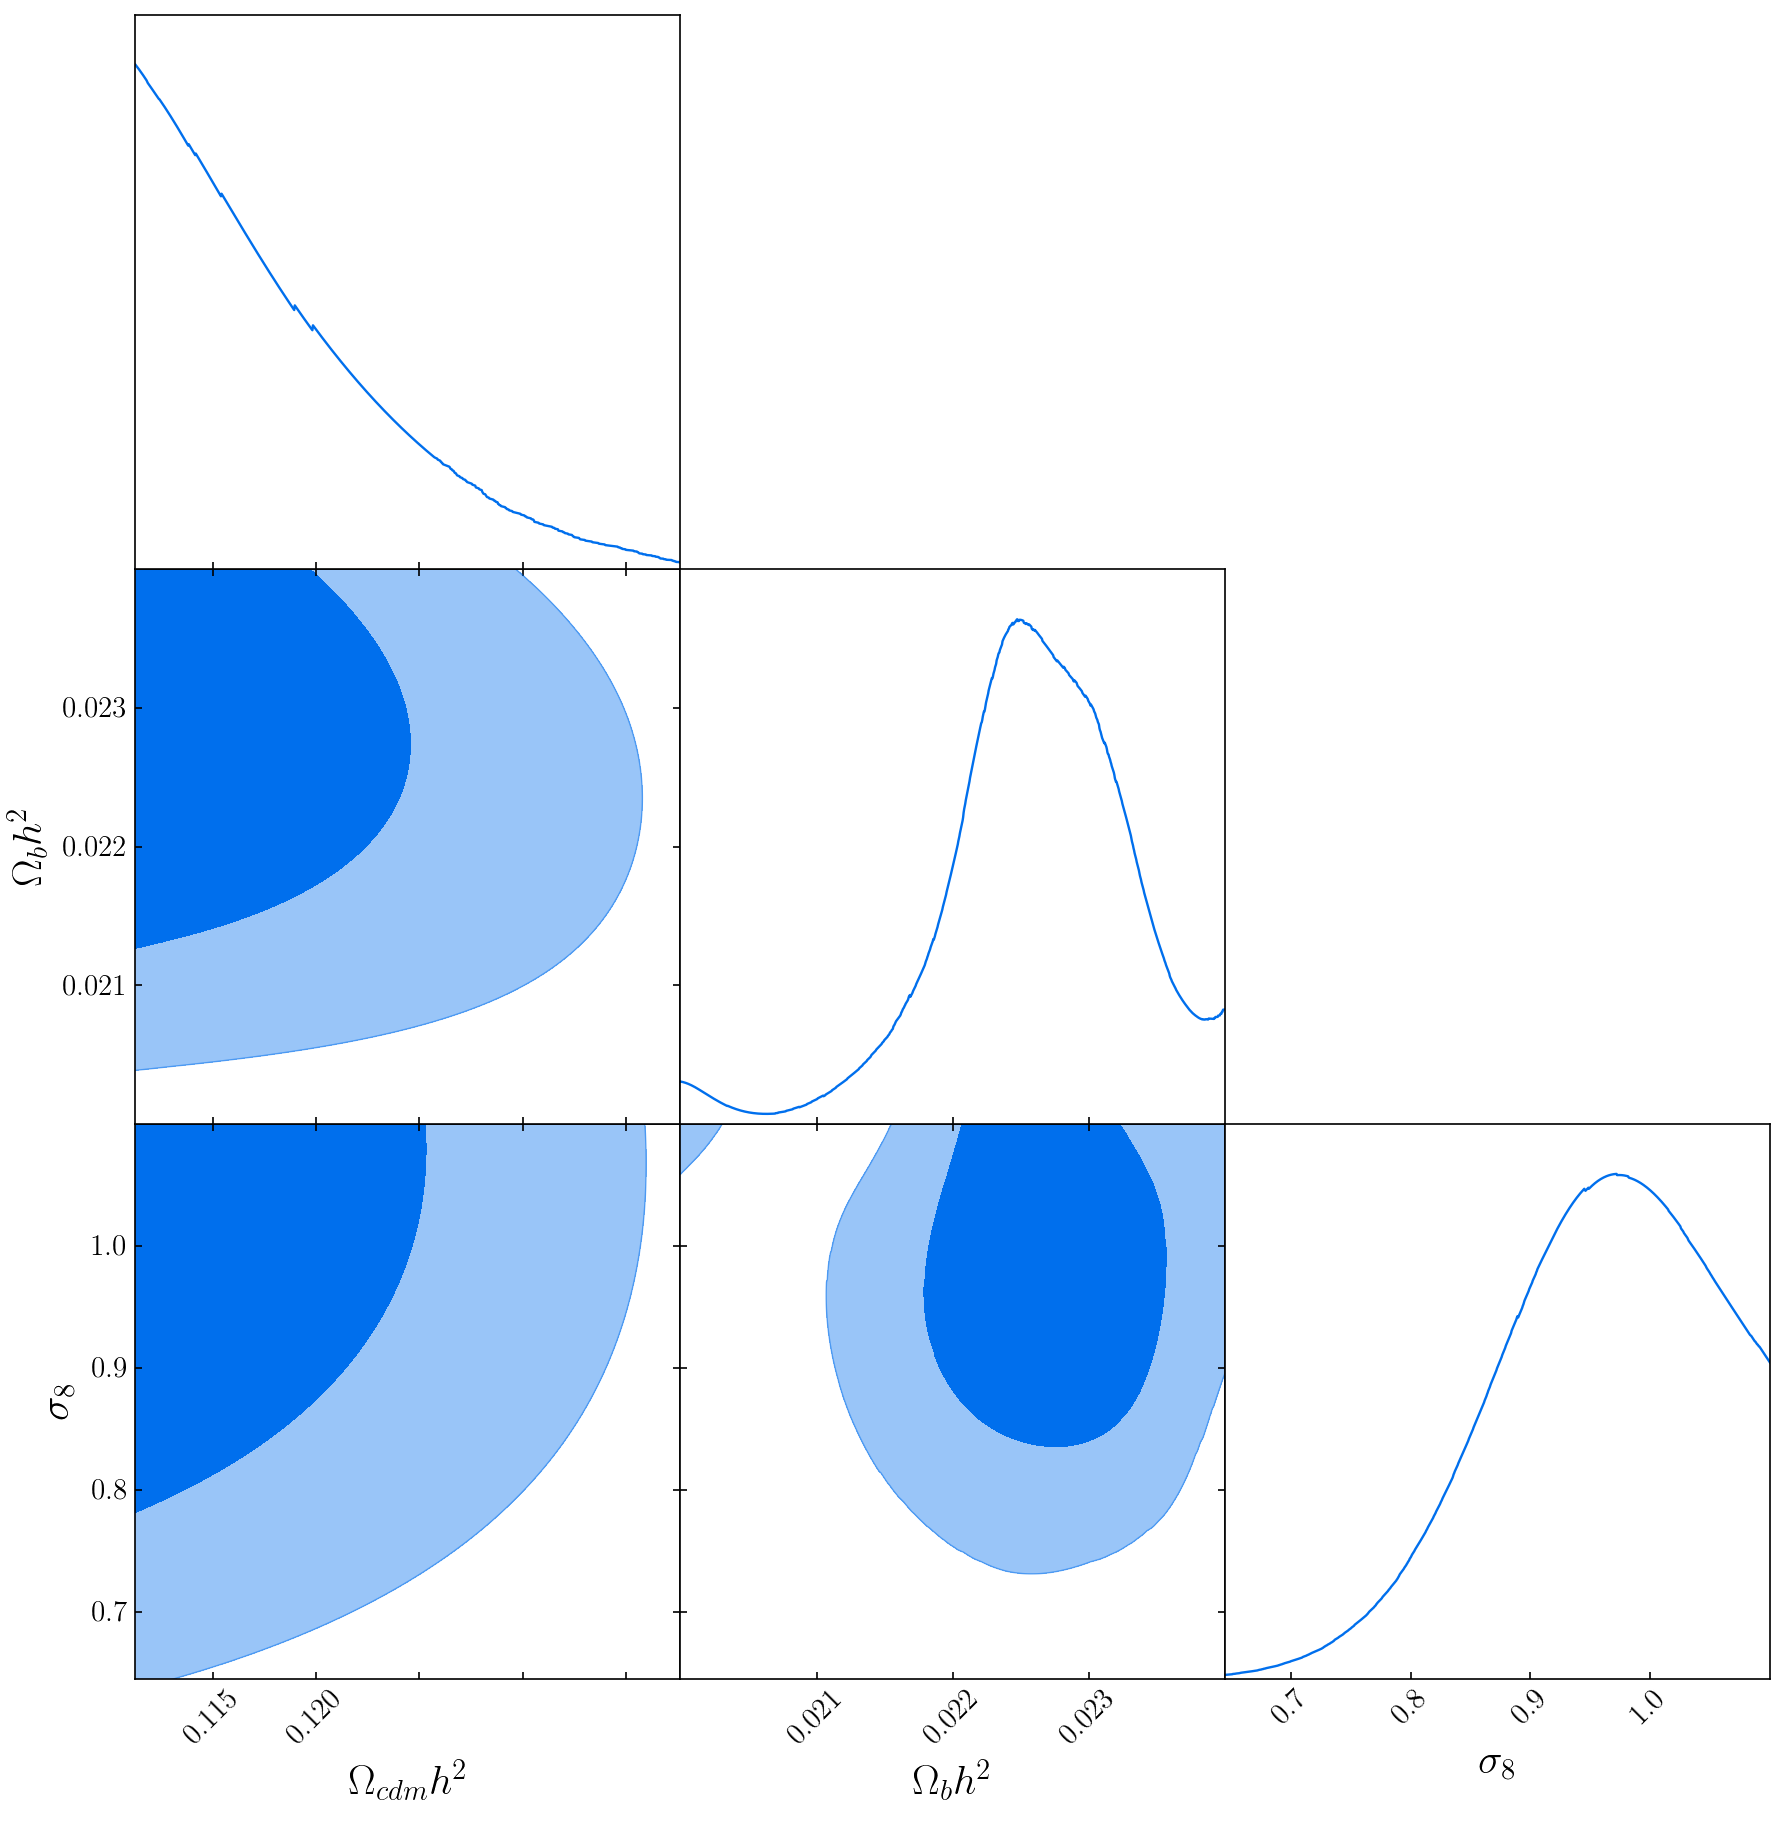

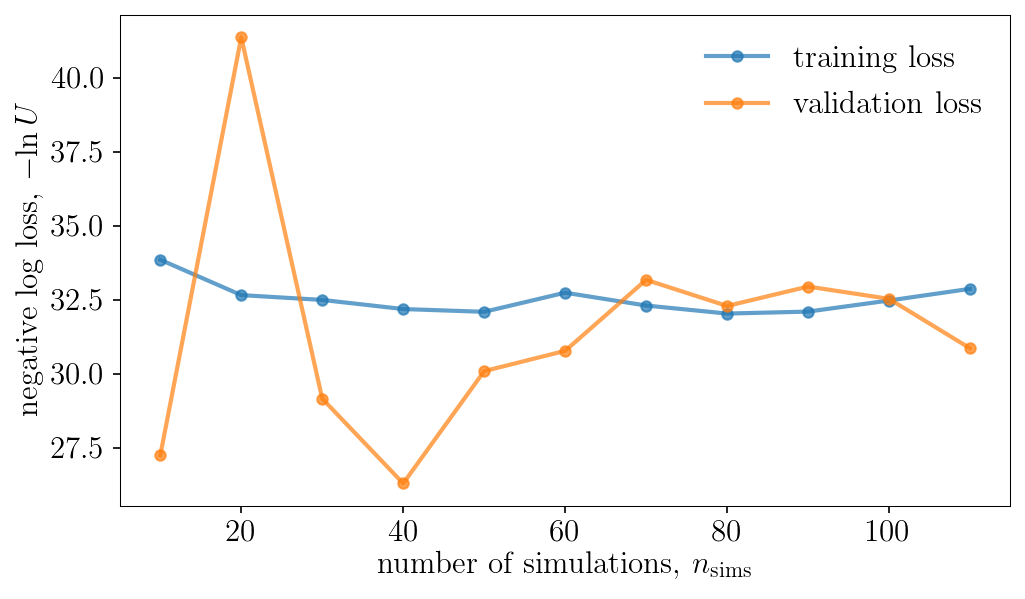

Population 18/50
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


training_loss: [array([ 85.19564819,  85.19564819,  85.19564819, ..., -27.57936287,
       -27.65387154, -27.6589222 ]), array([ 85.1725769 ,  85.1725769 ,  85.1725769 , ..., -27.89777756,
       -27.97856903, -27.99929428]), array([ 7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.60231400e+01,  7.60231400e+01,  7.60231400e+01,
        7.60231400e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01,  7.87858047e+01,  7.87858047e+01,  7.87858047e+01,
        7.87858047e+01, 

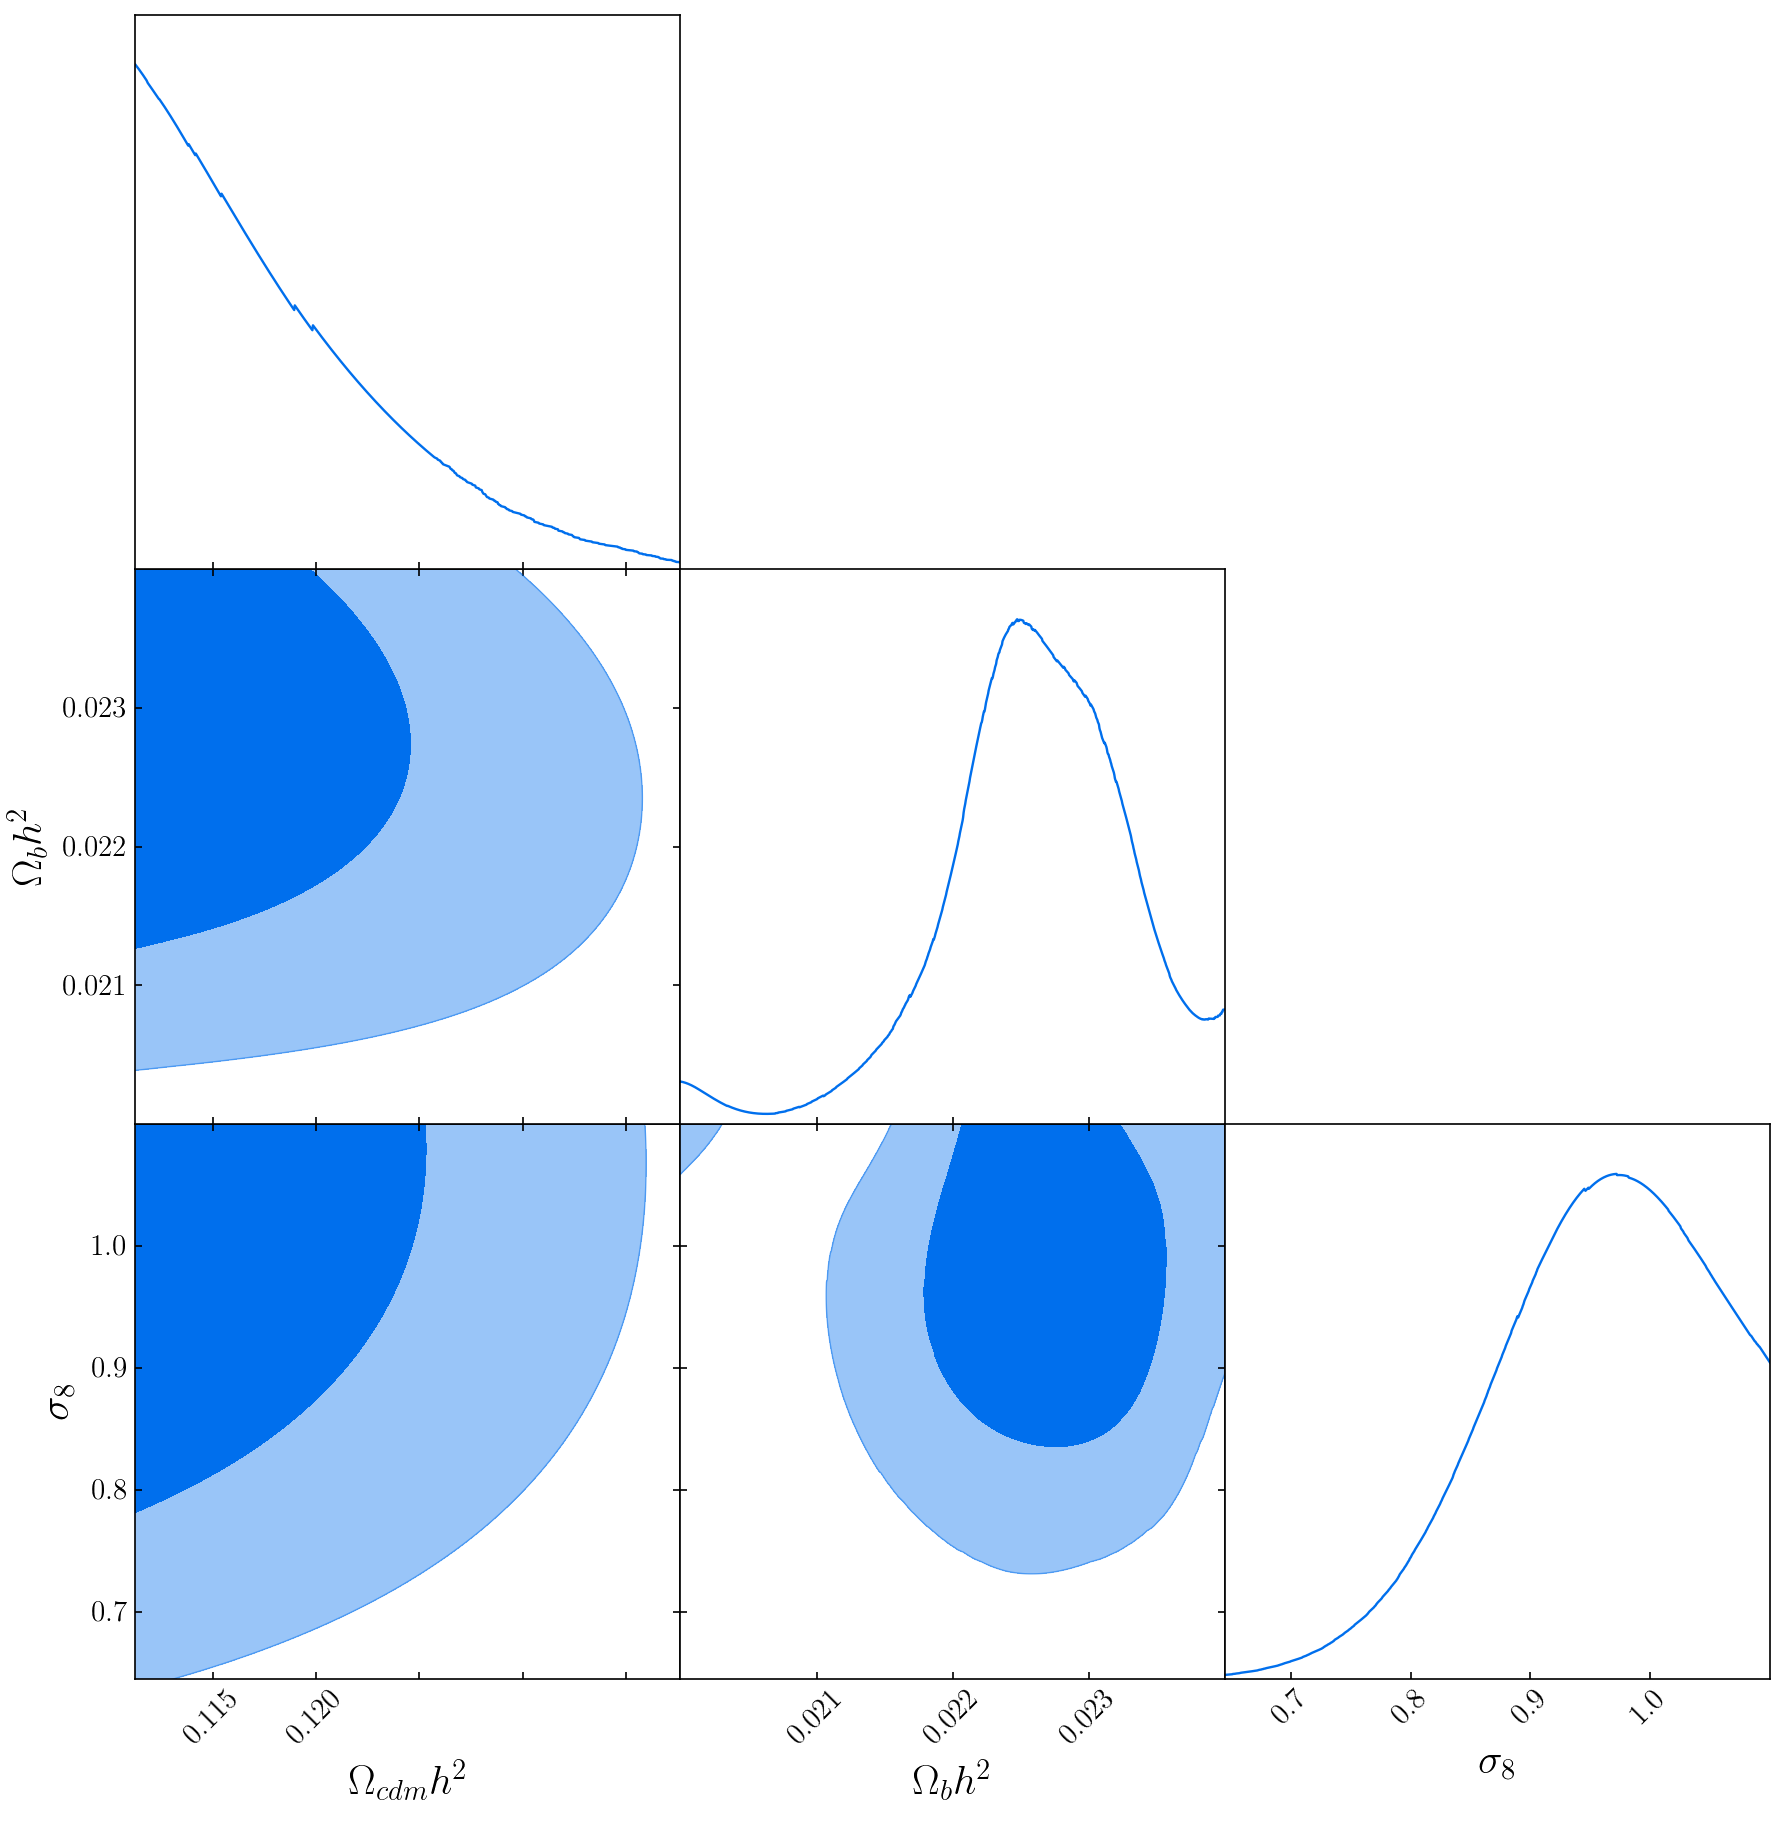

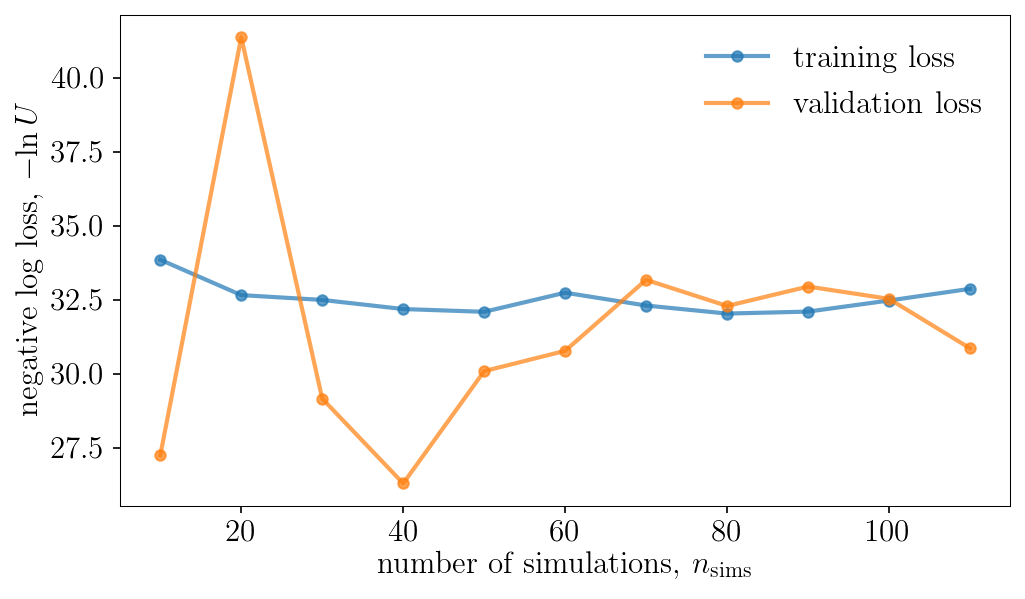

Population 19/50
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-bf964c0600c7>", line 2, in <module>
    save_intermediate_posteriors=True)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi_edit.py", line 468, in sequential_training
    self.train_ndes(training_data=[self.x_train, self.y_train], batch_size=max(self.n_sims//8, batch_size), validation_split=0.1, epochs=epochs, patience=patience)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi_edit.py", line 510, in train_ndes
    val_loss, train_loss = self.trainer[n].train(self.sess, training_data, validation_split = validation_split, epochs=epochs, batch_size=batch_size, progress_bar=self.progress_bar, patience=patience, saver_name=self.graph_restore_filename, mode=mode)
  File "/

KeyboardInterrupt: 

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 438, in _run_callback
    callback(*args, **kwargs)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 404, in schedule_dispatch
    self.io_loop.add_callback(lambda: None)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 177, in add_callback
    call_soon(self._run_callback, functools.partial(callback, *args, **kwargs))
KeyboardInterrupt


In [ ]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)

## Sample the learned posterior

In [21]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


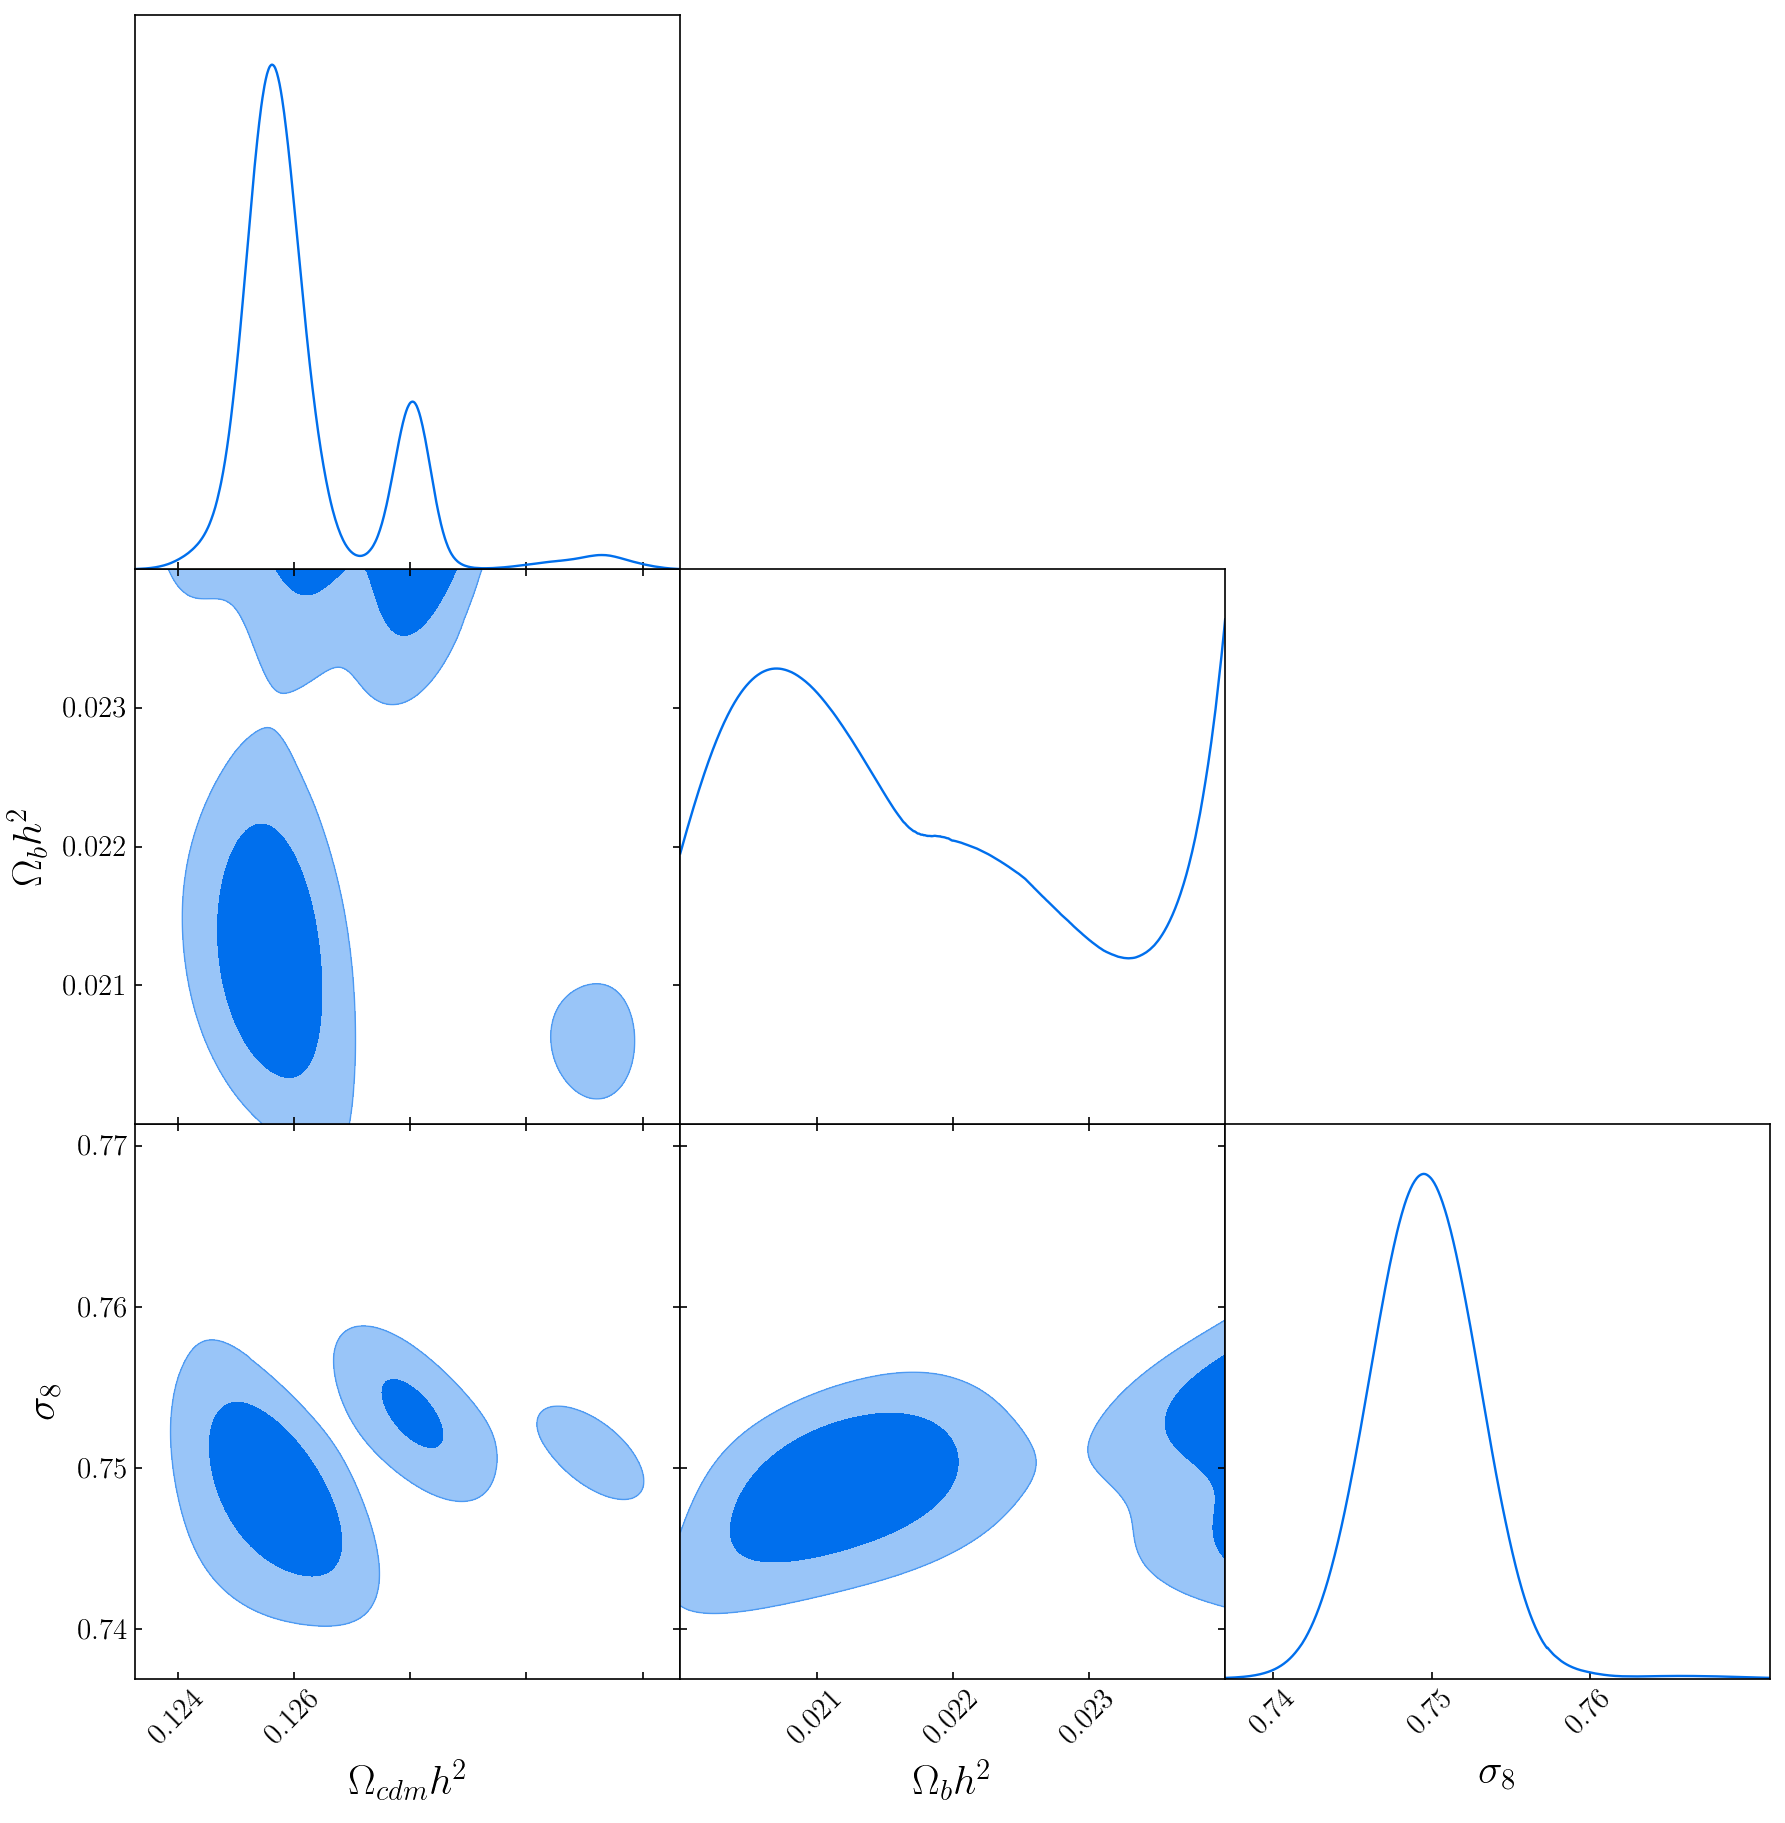

In [22]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])
